In [ ]:
!pip install kan
!pip install torch
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
models = []

dim = 2
np_i = 51
np_b = 51
ranges = [-1, 1]


def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)
def fun2(func,x,create_graph = False):
    return

sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])


sampling_mode = 'mesh'
x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':

    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:

    x_i = torch.rand((np_i**2,2))*2-1

x_i = x_i.to(device)

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

x_b = x_b.to(device)

# alpha = 0.01
# log = 1


# grids = [5,10,20]
# steps = 50
alpha = 0.01
log = 1


grids = [5]
steps = 5

pde_losses = []
bc_losses = []
l2_losses = []

for grid in grids:
    if grid == grids[0]:
        model = KAN(width=[2,2,1], grid=grid, k=3, seed=1, device=device)
        model = model.speed()

        modelo = model
    else:
        model.save_act = True
        model.get_act(x_i)
        model = model.refine(grid)
        model = model.speed()

    def train():
        optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        pbar = tqdm(range(steps), desc='description', ncols=100)

        for _ in pbar:
            def closure():
                global pde_loss, bc_loss
                optimizer.zero_grad()
                # interior loss
                sol = sol_fun(x_i)
                sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
                sol_D1 = sol_D1_fun(x_i)
                sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
                lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)

                source = source_fun(x_i)
                pde_loss = torch.mean((lap - source)**2)

                # boundary loss
                bc_true = sol_fun(x_b)
                bc_pred = model(x_b)
                bc_loss = torch.mean((bc_pred-bc_true)**2)

                loss = alpha * pde_loss + bc_loss
                loss.backward()
                return loss

            if _ % 5 == 0 and _ < 20:
                model.update_grid_from_samples(x_i)

            optimizer.step(closure)
            sol = sol_fun(x_i)
            loss = alpha * pde_loss + bc_loss
            l2 = torch.mean((model(x_i) - sol)**2)

            if _ % log == 0:
                pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

            pde_losses.append(pde_loss.cpu().detach().numpy())
            bc_losses.append(bc_loss.cpu().detach().numpy())
            l2_losses.append(l2.cpu().detach().numpy())


    train()

cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 4.29e+00 | bc loss: 1.04e-02 | l2: 8.56e-03 : 100%|█████████| 5/5 [00:16<00:00,  3.36s/it]


In [ ]:

modelo.plot(beta=10)


cannot plot since data are not saved. Set save_act=True first.


IndexError: list index out of range

In [ ]:

model.fix_symbolic(0,0,0,'x')
model.fix_symbolic(0,0,1,'x')
model.fix_symbolic(0,1,0,'x')
model.fix_symbolic(0,1,1,'x')

IndexError: list index out of range

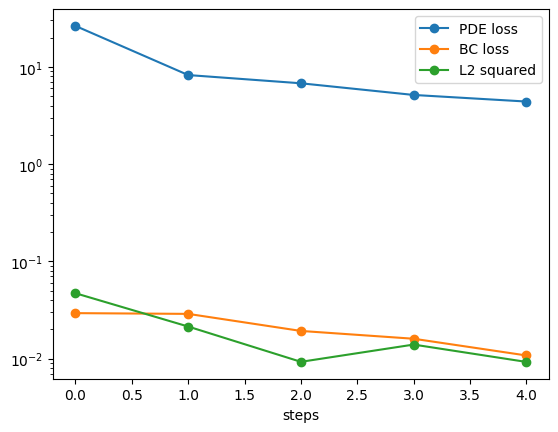

In [ ]:
plt.plot(pde_losses, marker='o')
plt.plot(bc_losses, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['PDE loss', 'BC loss', 'L2 squared'])

In [ ]:

import torch
import torch.nn as nn

# Assuming the model is already instantiated
# Replace the KAN model initialization with your specific model
# model = KAN(width=[2, 2, 1], grid=grid, k=3, seed=1, device=device)
model = KAN(width=[2,4,1], grid=20, k=3, seed=1, device=device)
# Function to count the number of parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the total number of parameters in the KAN model
print(f"Total number of trainable parameters in the model: {count_params(model)}")




checkpoint directory created: ./model
saving model version 0.0
Total number of trainable parameters in the model: 348


Using device: cuda
checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.05e+00 | bc loss: 2.03e-03 | l2: 3.00e-03 : 100%|███████| 50/50 [01:07<00:00,  1.34s/it]
pde loss: 5.71e-01 | bc loss: 5.19e-04 | l2: 1.07e-03 : 100%|███████| 50/50 [00:55<00:00,  1.11s/it]
pde loss: 9.89e-02 | bc loss: 4.12e-05 | l2: 7.75e-05 : 100%|███████| 50/50 [01:05<00:00,  1.31s/it]


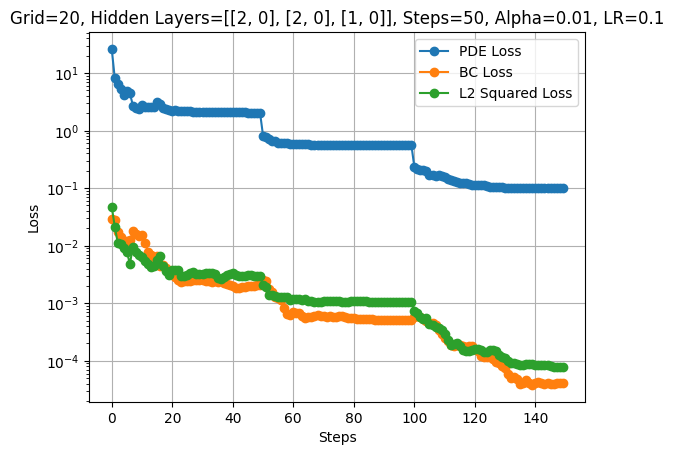

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.00e+00 | bc loss: 2.11e-03 | l2: 2.85e-03 : 100%|█████| 100/100 [01:46<00:00,  1.06s/it]
pde loss: 5.57e-01 | bc loss: 5.09e-04 | l2: 1.01e-03 : 100%|█████| 100/100 [01:22<00:00,  1.21it/s]
pde loss: 9.73e-02 | bc loss: 3.01e-05 | l2: 6.80e-05 : 100%|█████| 100/100 [02:02<00:00,  1.23s/it]


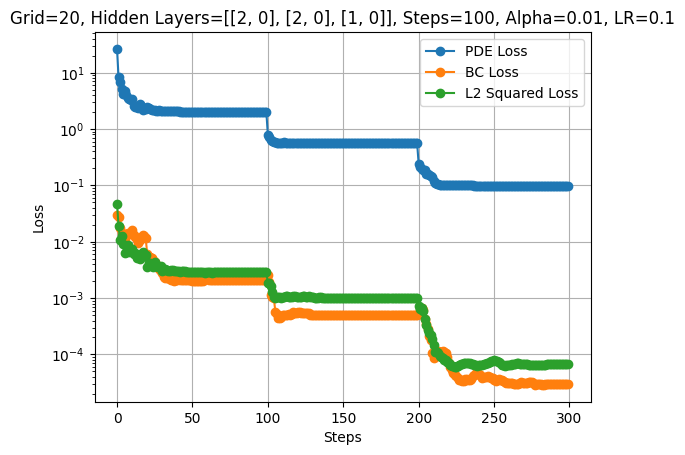

checkpoint directory created: ./model
saving model version 0.0


pde loss: 7.76e-01 | bc loss: 1.15e-03 | l2: 5.79e-04 : 100%|███████| 50/50 [01:05<00:00,  1.31s/it]
pde loss: 9.39e-02 | bc loss: 1.43e-04 | l2: 3.00e-05 : 100%|███████| 50/50 [01:05<00:00,  1.32s/it]
pde loss: 1.66e-02 | bc loss: 7.80e-05 | l2: 1.91e-05 : 100%|███████| 50/50 [01:06<00:00,  1.32s/it]


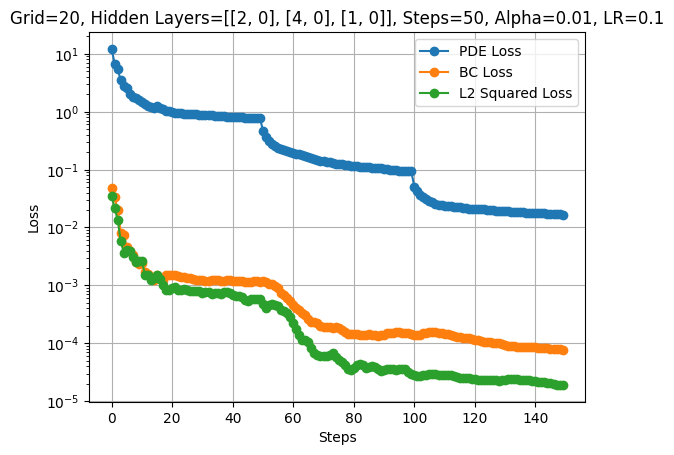

checkpoint directory created: ./model
saving model version 0.0


pde loss: 6.55e-01 | bc loss: 3.44e-04 | l2: 1.40e-04 : 100%|█████| 100/100 [02:12<00:00,  1.33s/it]
pde loss: 7.80e-02 | bc loss: 5.39e-05 | l2: 1.26e-05 : 100%|█████| 100/100 [02:11<00:00,  1.31s/it]
pde loss: 9.36e-03 | bc loss: 2.22e-05 | l2: 7.07e-06 : 100%|█████| 100/100 [02:10<00:00,  1.31s/it]


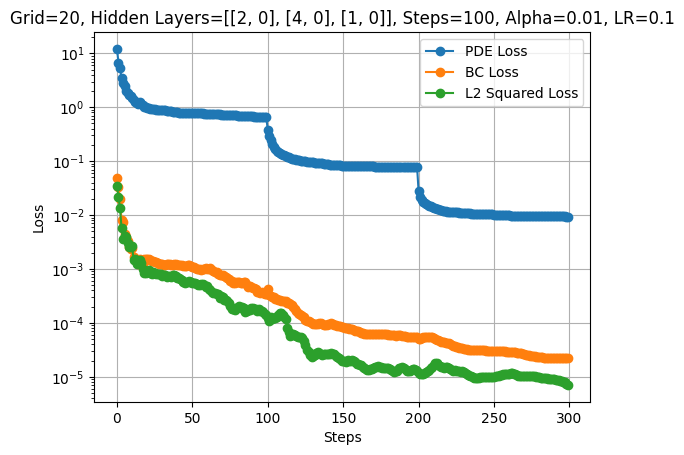

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.12e+00 | bc loss: 1.89e-03 | l2: 3.15e-03 : 100%|███████| 50/50 [01:05<00:00,  1.31s/it]
pde loss: 5.72e-01 | bc loss: 5.23e-04 | l2: 1.07e-03 : 100%|███████| 50/50 [00:59<00:00,  1.19s/it]
pde loss: 9.96e-02 | bc loss: 3.89e-05 | l2: 8.13e-05 : 100%|███████| 50/50 [01:04<00:00,  1.29s/it]


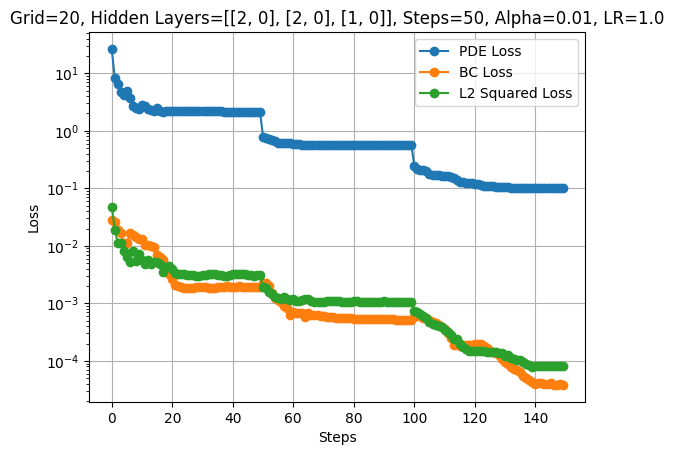

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.01e+00 | bc loss: 2.08e-03 | l2: 2.86e-03 : 100%|█████| 100/100 [02:12<00:00,  1.33s/it]
pde loss: 5.60e-01 | bc loss: 5.18e-04 | l2: 1.02e-03 : 100%|█████| 100/100 [01:36<00:00,  1.03it/s]
pde loss: 9.72e-02 | bc loss: 3.10e-05 | l2: 6.89e-05 : 100%|█████| 100/100 [02:08<00:00,  1.29s/it]


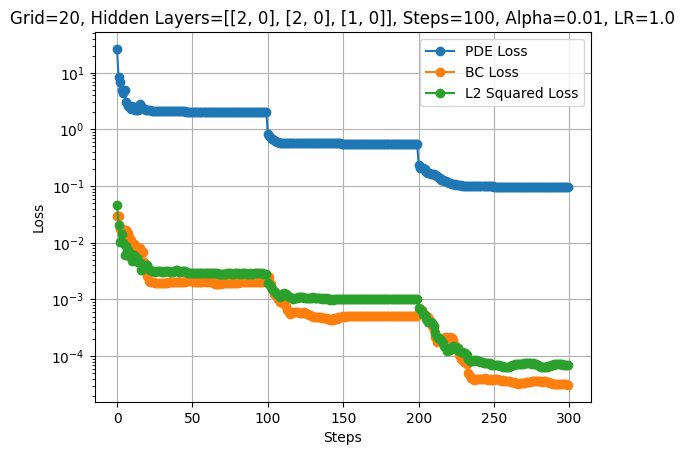

checkpoint directory created: ./model
saving model version 0.0


pde loss: 7.67e-01 | bc loss: 9.01e-04 | l2: 4.10e-04 : 100%|███████| 50/50 [01:05<00:00,  1.31s/it]
pde loss: 8.40e-02 | bc loss: 4.19e-05 | l2: 9.49e-06 : 100%|███████| 50/50 [01:05<00:00,  1.32s/it]
pde loss: 1.26e-02 | bc loss: 3.58e-05 | l2: 5.92e-06 : 100%|███████| 50/50 [01:06<00:00,  1.33s/it]


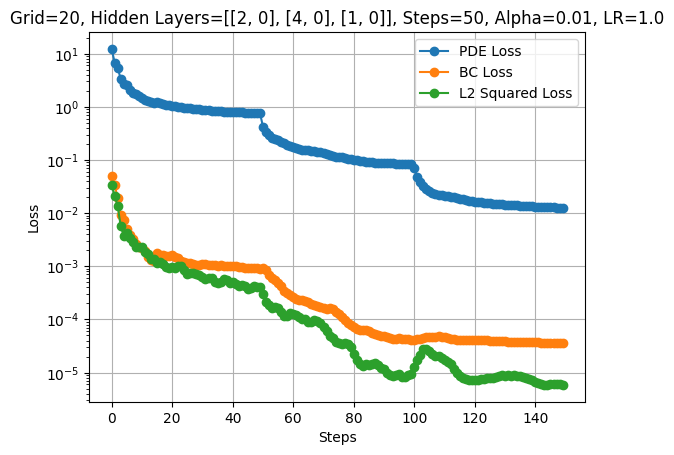

checkpoint directory created: ./model
saving model version 0.0


pde loss: 7.29e-01 | bc loss: 7.76e-04 | l2: 3.94e-04 : 100%|█████| 100/100 [02:11<00:00,  1.32s/it]
pde loss: 8.07e-02 | bc loss: 4.01e-05 | l2: 1.51e-05 : 100%|█████| 100/100 [02:11<00:00,  1.31s/it]
pde loss: 1.14e-02 | bc loss: 2.06e-05 | l2: 1.15e-05 : 100%|█████| 100/100 [02:11<00:00,  1.32s/it]


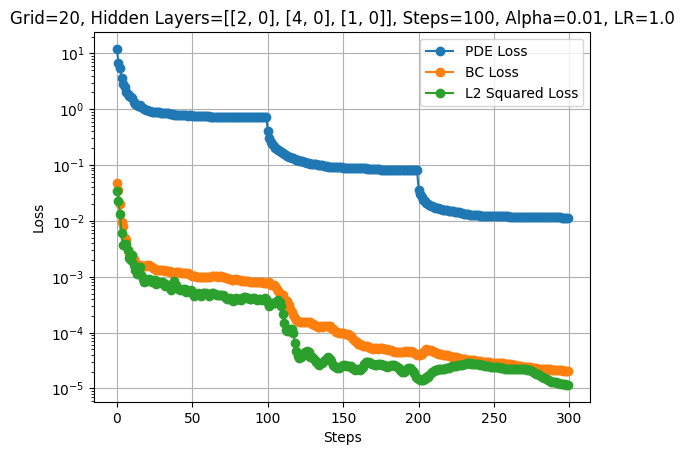

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.22e+00 | bc loss: 5.32e-02 | l2: 1.88e-02 : 100%|███████| 50/50 [01:06<00:00,  1.32s/it]
pde loss: 2.95e-01 | bc loss: 3.33e-02 | l2: 1.02e-02 : 100%|███████| 50/50 [01:04<00:00,  1.29s/it]
pde loss: 1.15e-01 | bc loss: 2.61e-02 | l2: 7.93e-03 : 100%|███████| 50/50 [00:50<00:00,  1.02s/it]


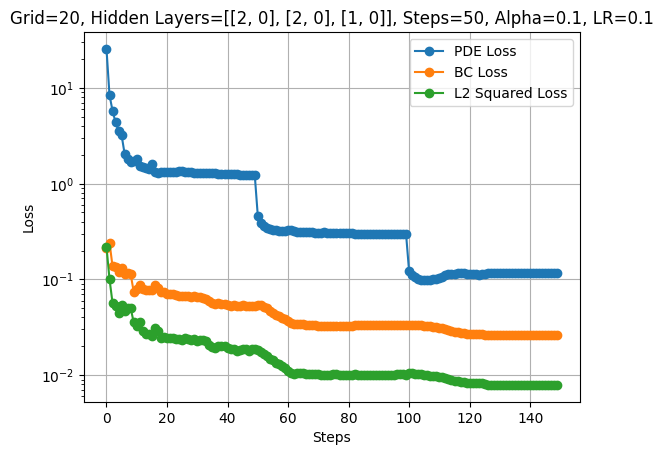

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.58e+00 | bc loss: 2.25e-02 | l2: 7.97e-03 : 100%|█████| 100/100 [02:14<00:00,  1.35s/it]
pde loss: 3.86e-01 | bc loss: 8.35e-03 | l2: 3.02e-03 : 100%|█████| 100/100 [01:08<00:00,  1.45it/s]
pde loss: 7.45e-02 | bc loss: 1.07e-03 | l2: 4.64e-04 : 100%|█████| 100/100 [02:14<00:00,  1.34s/it]


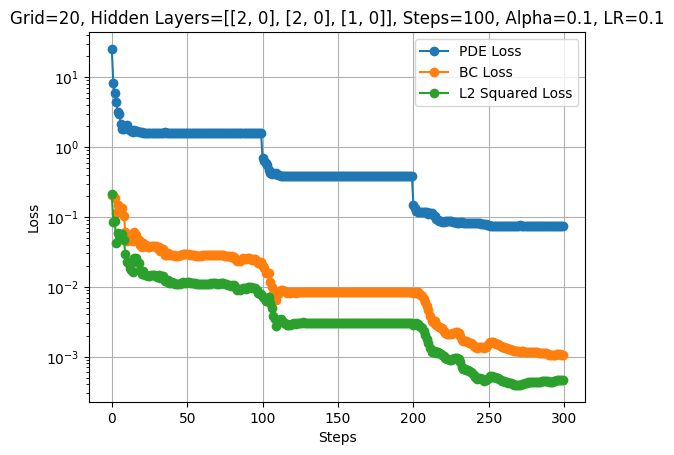

checkpoint directory created: ./model
saving model version 0.0


pde loss: 8.12e-01 | bc loss: 1.00e-02 | l2: 3.70e-03 : 100%|███████| 50/50 [01:07<00:00,  1.35s/it]
pde loss: 1.07e-01 | bc loss: 2.67e-03 | l2: 7.76e-04 : 100%|███████| 50/50 [01:06<00:00,  1.34s/it]
pde loss: 1.67e-02 | bc loss: 2.08e-03 | l2: 5.14e-04 : 100%|███████| 50/50 [01:08<00:00,  1.36s/it]


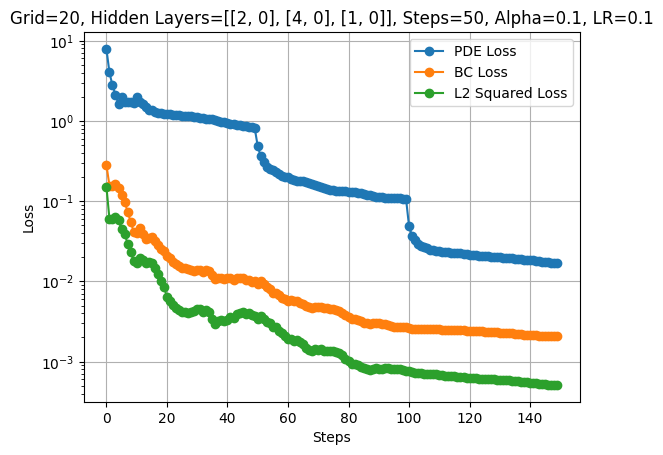

checkpoint directory created: ./model
saving model version 0.0


pde loss: 6.65e-01 | bc loss: 7.15e-03 | l2: 2.50e-03 : 100%|█████| 100/100 [02:13<00:00,  1.34s/it]
pde loss: 7.43e-02 | bc loss: 1.11e-03 | l2: 4.64e-04 : 100%|█████| 100/100 [02:12<00:00,  1.33s/it]
pde loss: 8.86e-03 | bc loss: 4.21e-04 | l2: 2.02e-04 : 100%|█████| 100/100 [02:14<00:00,  1.35s/it]


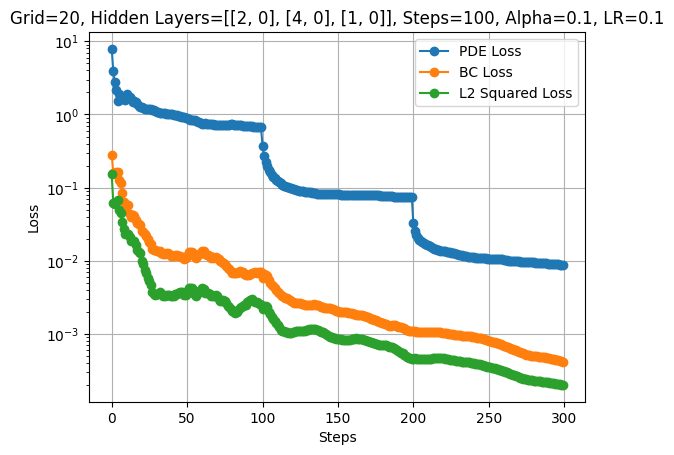

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.30e+00 | bc loss: 5.38e-02 | l2: 2.00e-02 : 100%|███████| 50/50 [01:06<00:00,  1.32s/it]
pde loss: 2.97e-01 | bc loss: 3.31e-02 | l2: 1.02e-02 : 100%|███████| 50/50 [01:05<00:00,  1.31s/it]
pde loss: 1.39e-01 | bc loss: 1.61e-02 | l2: 5.15e-03 : 100%|███████| 50/50 [01:06<00:00,  1.33s/it]


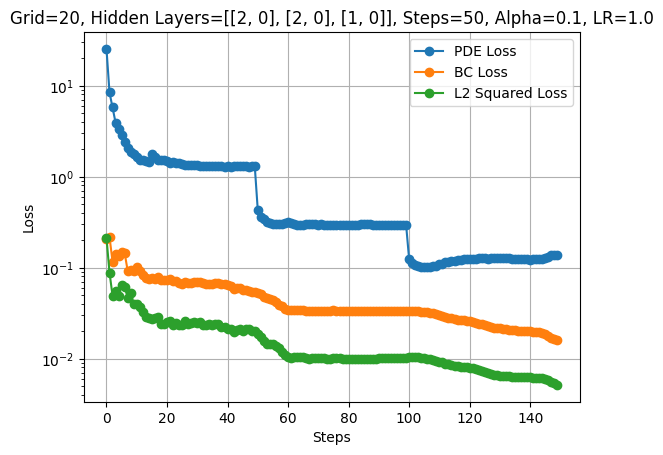

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.17e+00 | bc loss: 4.95e-02 | l2: 1.71e-02 : 100%|█████| 100/100 [02:10<00:00,  1.30s/it]
pde loss: 2.93e-01 | bc loss: 3.37e-02 | l2: 1.03e-02 : 100%|█████| 100/100 [01:49<00:00,  1.10s/it]
pde loss: 9.21e-02 | bc loss: 5.66e-03 | l2: 1.68e-03 : 100%|█████| 100/100 [02:11<00:00,  1.31s/it]


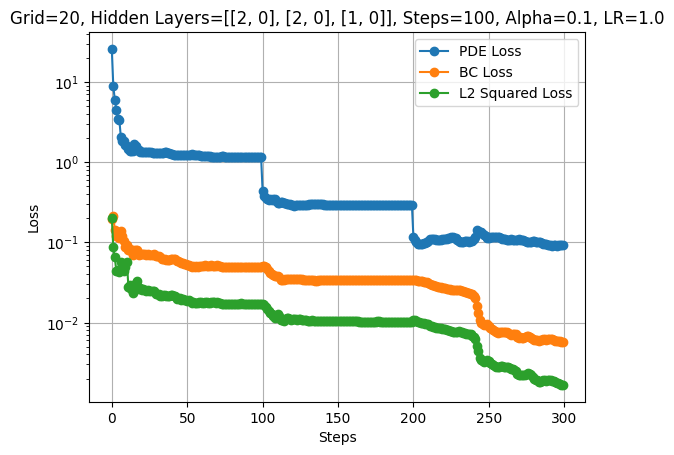

checkpoint directory created: ./model
saving model version 0.0


pde loss: 8.22e-01 | bc loss: 1.08e-02 | l2: 3.04e-03 : 100%|███████| 50/50 [01:06<00:00,  1.32s/it]
pde loss: 9.77e-02 | bc loss: 2.87e-03 | l2: 6.85e-04 : 100%|███████| 50/50 [01:05<00:00,  1.31s/it]
pde loss: 1.56e-02 | bc loss: 2.28e-03 | l2: 4.98e-04 : 100%|███████| 50/50 [01:04<00:00,  1.30s/it]


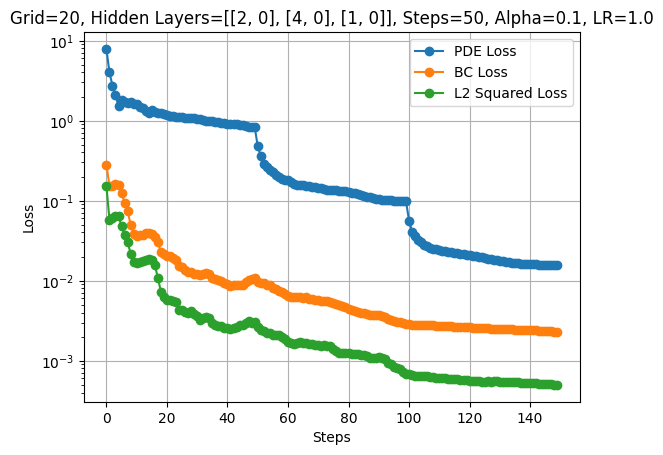

checkpoint directory created: ./model
saving model version 0.0


pde loss: 6.97e-01 | bc loss: 9.36e-03 | l2: 2.36e-03 : 100%|█████| 100/100 [02:14<00:00,  1.34s/it]
pde loss: 1.00e-01 | bc loss: 2.84e-03 | l2: 7.06e-04 : 100%|█████| 100/100 [02:14<00:00,  1.34s/it]
pde loss: 1.58e-02 | bc loss: 1.71e-03 | l2: 3.79e-04 : 100%|█████| 100/100 [02:13<00:00,  1.34s/it]


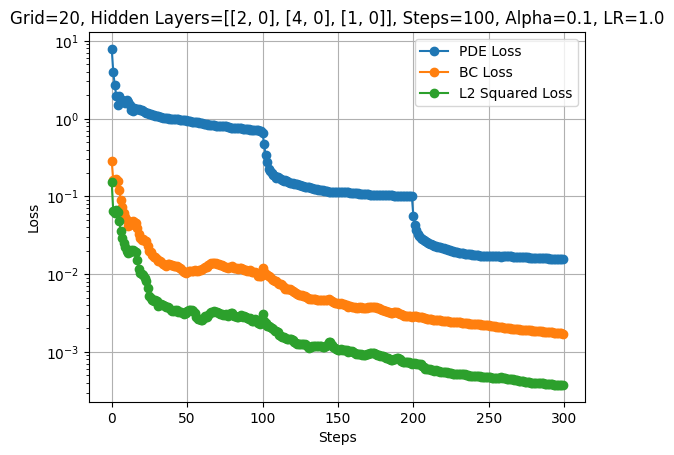

    Alpha  Learning Rate  Grid             Hidden Layers  Steps  \
0    0.01            0.1    20  [[2, 0], [2, 0], [1, 0]]     50   
1    0.01            0.1    20  [[2, 0], [2, 0], [1, 0]]    100   
2    0.01            0.1    20  [[2, 0], [4, 0], [1, 0]]     50   
3    0.01            0.1    20  [[2, 0], [4, 0], [1, 0]]    100   
4    0.01            1.0    20  [[2, 0], [2, 0], [1, 0]]     50   
5    0.01            1.0    20  [[2, 0], [2, 0], [1, 0]]    100   
6    0.01            1.0    20  [[2, 0], [4, 0], [1, 0]]     50   
7    0.01            1.0    20  [[2, 0], [4, 0], [1, 0]]    100   
8    0.10            0.1    20  [[2, 0], [2, 0], [1, 0]]     50   
9    0.10            0.1    20  [[2, 0], [2, 0], [1, 0]]    100   
10   0.10            0.1    20  [[2, 0], [4, 0], [1, 0]]     50   
11   0.10            0.1    20  [[2, 0], [4, 0], [1, 0]]    100   
12   0.10            1.0    20  [[2, 0], [2, 0], [1, 0]]     50   
13   0.10            1.0    20  [[2, 0], [2, 0], [1, 0]]    10

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1081: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(w_large, w_large))
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0+z0)))


Visualize model =  [0.1, 0.1, [[2, 0], [4, 0], [1, 0]], 100]
Visualize model =  [0.1, 1.0, [[2, 0], [2, 0], [1, 0]], 50]
Visualize model =  [0.1, 1.0, [[2, 0], [2, 0], [1, 0]], 100]
Visualize model =  [0.1, 1.0, [[2, 0], [4, 0], [1, 0]], 50]
Visualize model =  [0.1, 1.0, [[2, 0], [4, 0], [1, 0]], 100]


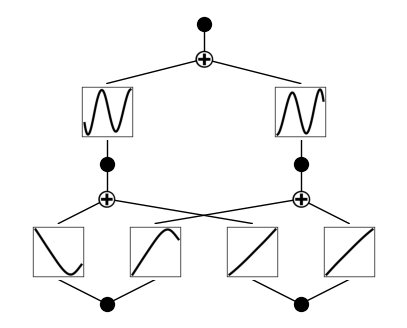

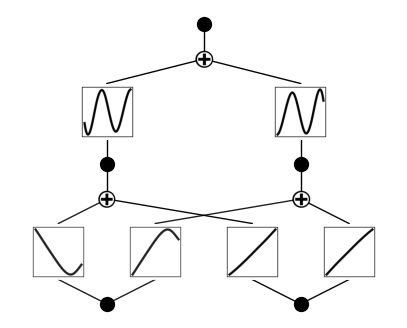

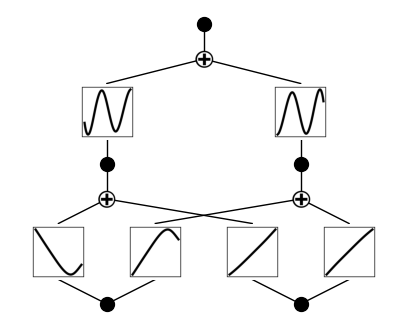

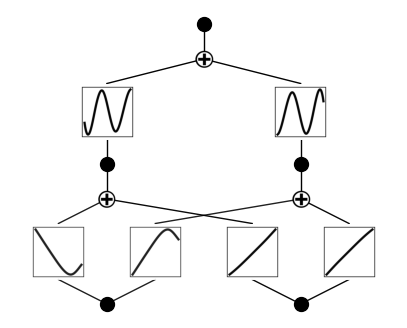

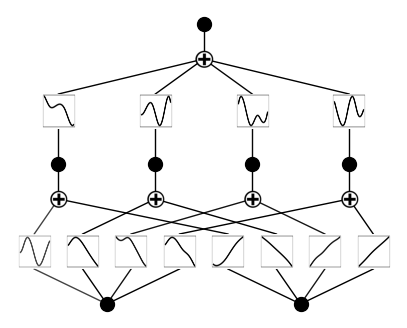

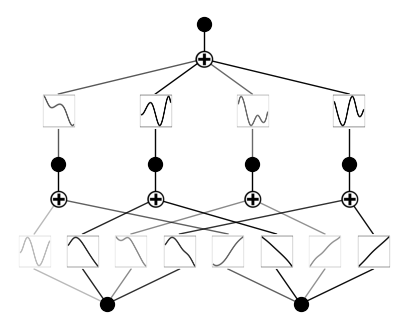

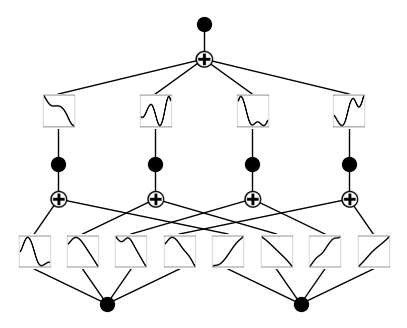

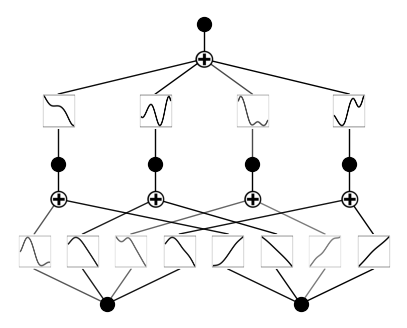

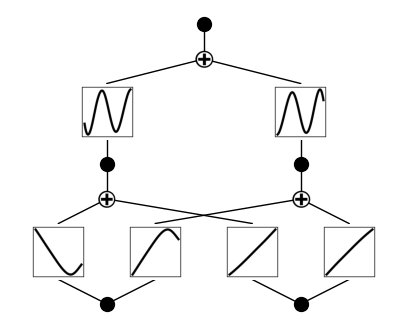

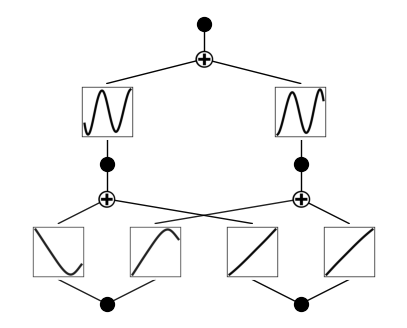

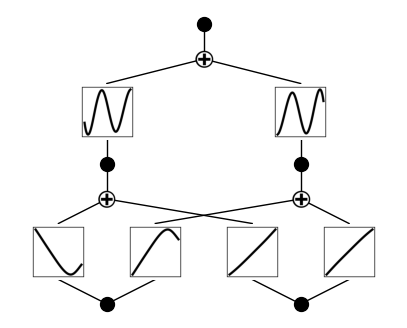

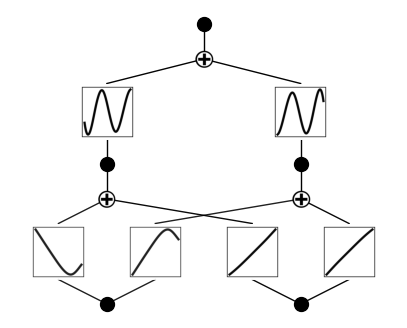

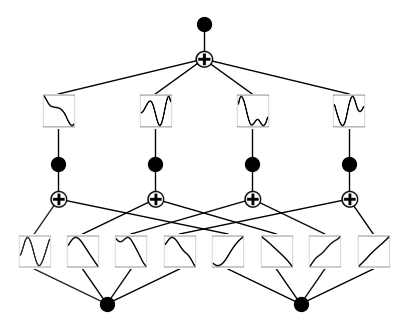

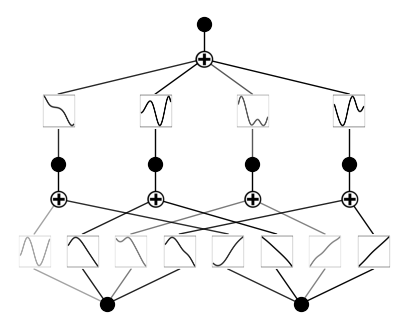

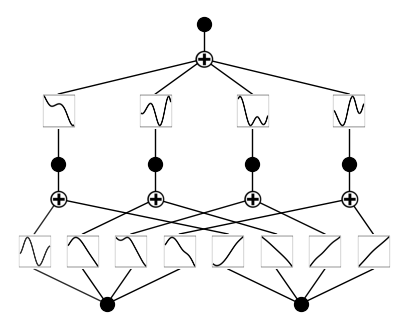

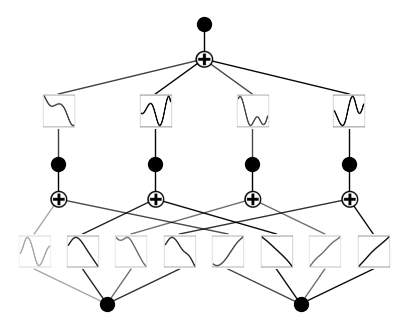

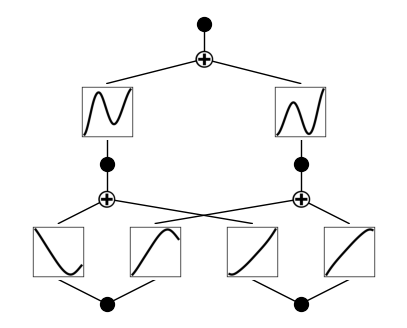

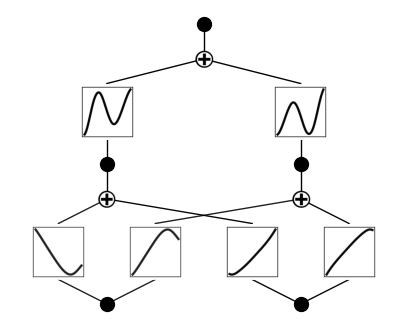

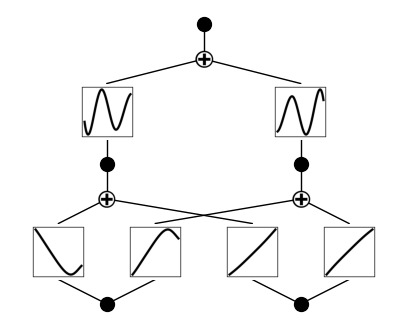

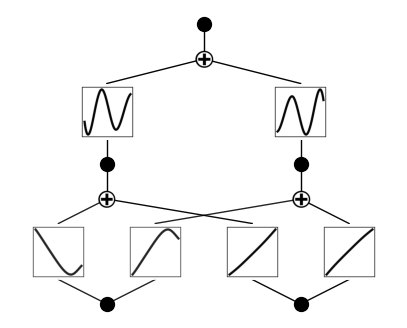

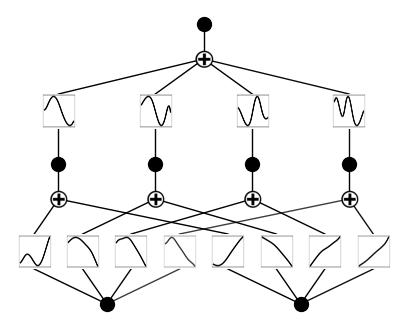

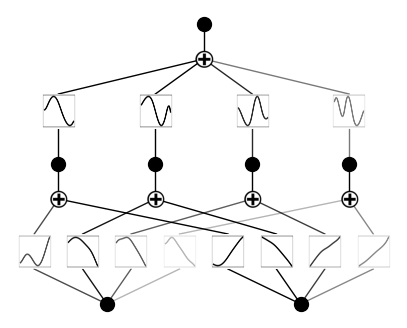

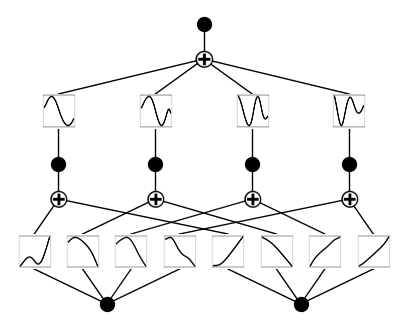

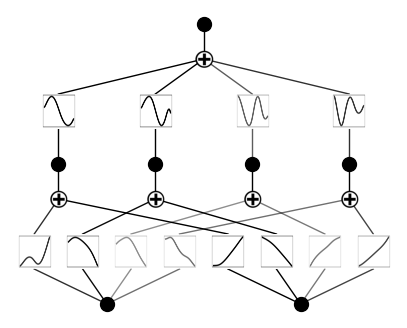

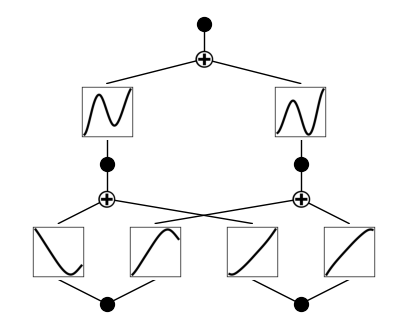

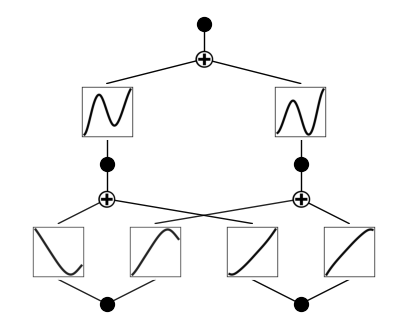

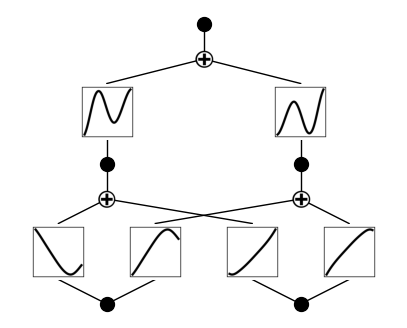

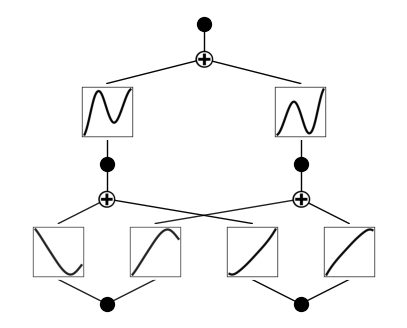

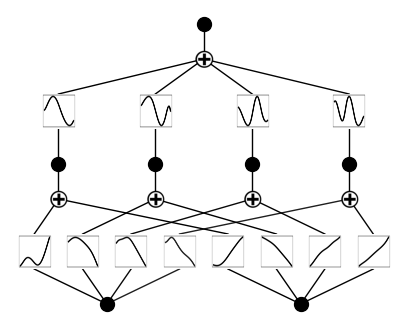

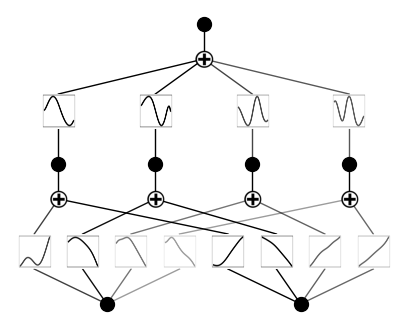

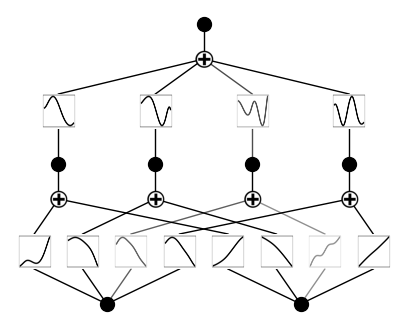

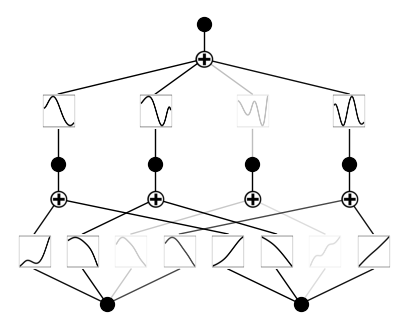

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []

dim = 2
np_i = 51
np_b = 51
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
sampling_mode = 'mesh'  # 'random' or 'mesh'
grids = [5, 10, 20]
steps = 50

sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])
source_fun = lambda x: -2 * torch.pi**2 * torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

if sampling_mode == 'mesh':
    x_i = torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
else:
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

x_i = x_i.to(device)

helper = lambda X, Y: torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0).to(device)

# Training function
def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # Boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if step % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses




alphas = [0.01, 0.1]
learning_rates = [ 0.1, 1.0]
grids = [5,10,20]
hidden_layers_list = [[2, 2, 1], [2, 4,1]]
steps_list = [50, 100]

pde_losses, bc_losses,l2_losses = [],[],[]

log = 1


# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):

    pde_losses ,bc_losses,l2_losses = [],[],[]
    for grid in grids:
      if grid == grids[0]:
          model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
          models.append(model)
          parameters_to_print.append([alpha, learning_rate,hidden_layers, steps])
          model = model.speed()
      else:
          model.save_act = True
          model.get_act(x_i)
          model = model.refine(grid)
          model = model.speed()
      # Train model
      pde_losses, bc_losses, l2_losses= train_model(model, x_i, x_b, steps, alpha, log_interval)
      # Store results
    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        'Final PDE Loss': pde_losses[-1],
        'Final BC Loss': bc_losses[-1],
        'Final L2 Loss': l2_losses[-1]
    })

    plt.plot(pde_losses, marker='o', label='PDE Loss')
    plt.plot(bc_losses, marker='o', label='BC Loss')
    plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    plt.grid(True)
    plt.show()


# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save results to CSV and print
results_df.to_csv('kan_hyperparameter_results.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))
for i in range(len(models)):
  print("Visualize model = ",parameters_to_print[i])
  models[i].plot(beta = 10)
  models[i].plot()


Using device: cuda
checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.41e-01 | bc loss: 7.71e-06 | l2: 1.25e-05 : 100%|███████| 50/50 [01:03<00:00,  1.28s/it]
pde loss: 1.68e-02 | bc loss: 2.86e-07 | l2: 7.89e-07 : 100%|███████| 50/50 [01:01<00:00,  1.23s/it]
pde loss: 2.37e-03 | bc loss: 1.84e-07 | l2: 3.82e-07 : 100%|███████| 50/50 [00:49<00:00,  1.02it/s]


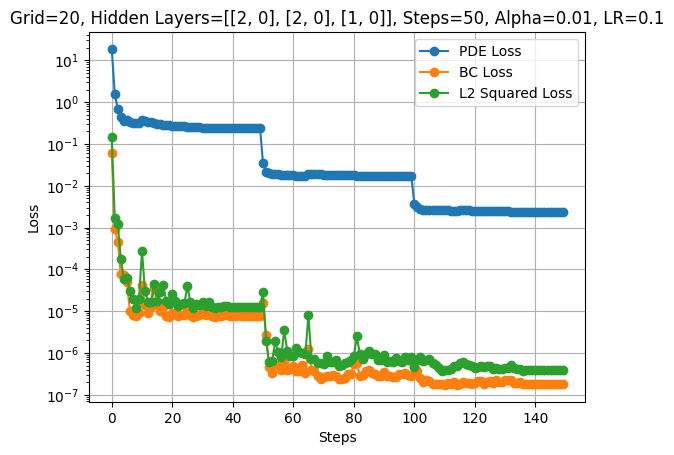

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.42e-01 | bc loss: 7.71e-06 | l2: 1.25e-05 : 100%|█████| 100/100 [01:25<00:00,  1.18it/s]
pde loss: 1.64e-02 | bc loss: 2.50e-07 | l2: 5.35e-07 : 100%|█████| 100/100 [01:17<00:00,  1.30it/s]
pde loss: 2.36e-03 | bc loss: 2.21e-07 | l2: 4.91e-07 : 100%|█████| 100/100 [01:00<00:00,  1.64it/s]


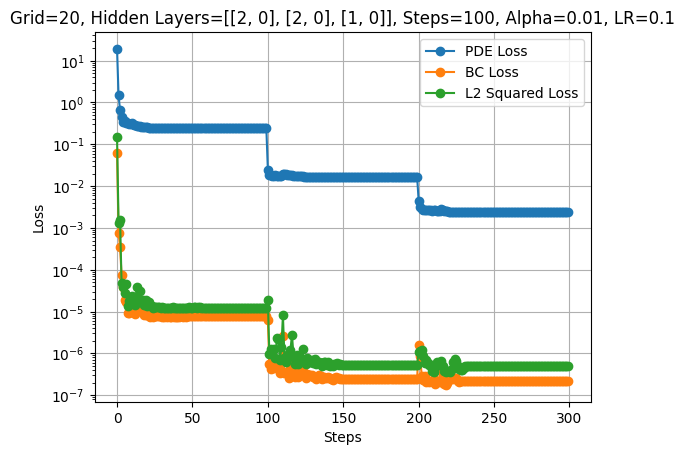

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.17e-01 | bc loss: 1.78e-05 | l2: 1.39e-05 : 100%|███████| 50/50 [01:02<00:00,  1.25s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:11<00:00,  1.43s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:11<00:00,  1.44s/it]


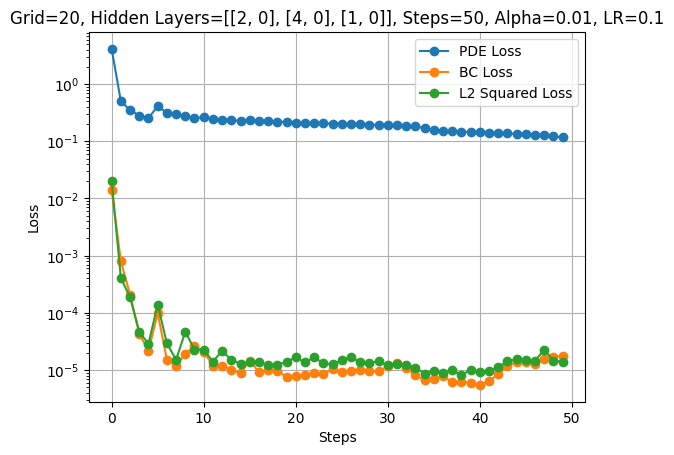

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.18e-02 | bc loss: 8.21e-07 | l2: 8.50e-07 : 100%|█████| 100/100 [02:04<00:00,  1.24s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:22<00:00,  1.43s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:22<00:00,  1.43s/it]


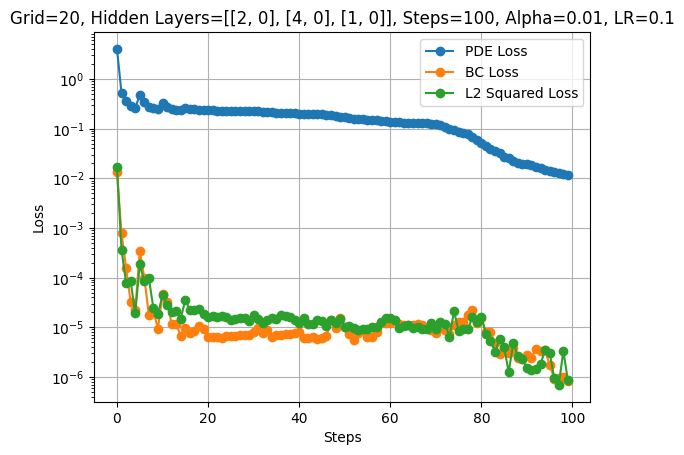

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.42e-01 | bc loss: 8.00e-06 | l2: 1.30e-05 : 100%|███████| 50/50 [00:50<00:00,  1.00s/it]
pde loss: 1.66e-02 | bc loss: 2.75e-07 | l2: 6.12e-07 : 100%|███████| 50/50 [00:57<00:00,  1.14s/it]
pde loss: 2.35e-03 | bc loss: 2.58e-07 | l2: 5.27e-07 : 100%|███████| 50/50 [00:36<00:00,  1.37it/s]


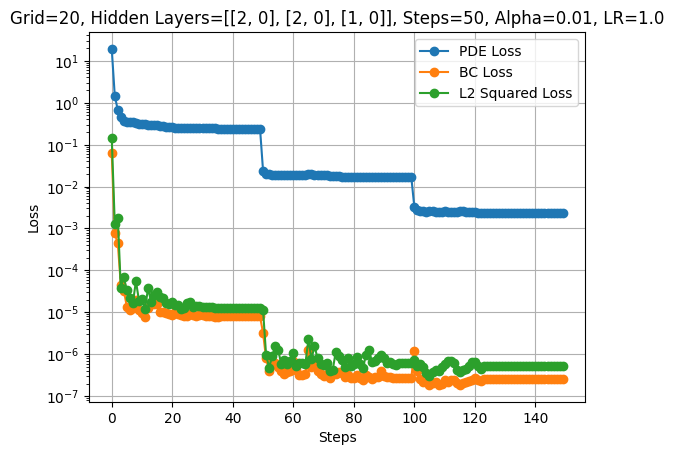

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.48e-01 | bc loss: 7.44e-06 | l2: 1.28e-05 : 100%|█████| 100/100 [01:18<00:00,  1.27it/s]
pde loss: 1.59e-02 | bc loss: 2.33e-07 | l2: 5.42e-07 : 100%|█████| 100/100 [01:34<00:00,  1.06it/s]
pde loss: 2.36e-03 | bc loss: 2.23e-07 | l2: 4.42e-07 : 100%|█████| 100/100 [01:06<00:00,  1.50it/s]


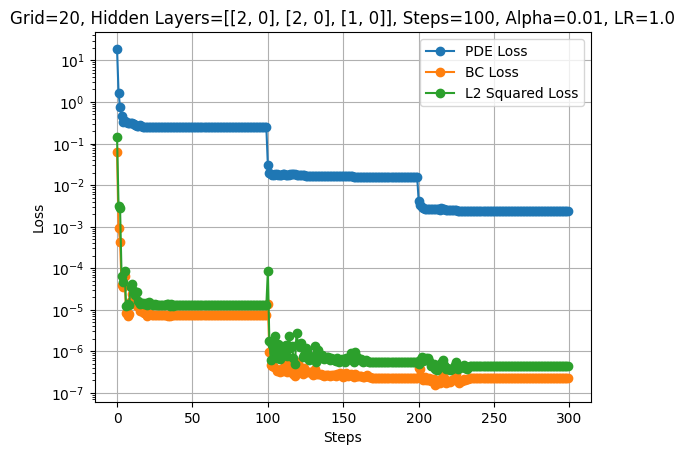

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.78e-01 | bc loss: 8.10e-06 | l2: 2.09e-05 : 100%|███████| 50/50 [01:02<00:00,  1.25s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:12<00:00,  1.44s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:12<00:00,  1.44s/it]


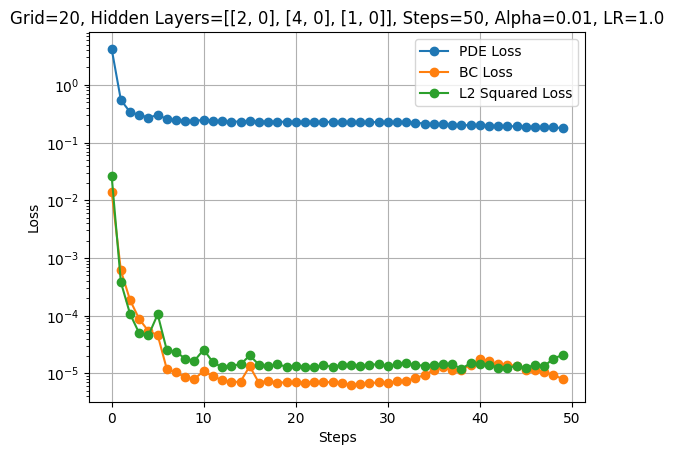

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.23e-02 | bc loss: 6.75e-07 | l2: 3.59e-07 : 100%|█████| 100/100 [02:04<00:00,  1.24s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:23<00:00,  1.44s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:23<00:00,  1.44s/it]


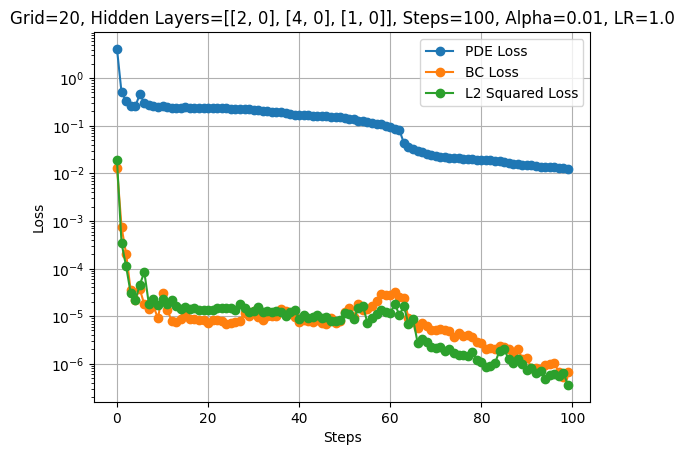

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.59e-01 | bc loss: 3.58e-05 | l2: 1.99e-05 : 100%|███████| 50/50 [01:00<00:00,  1.21s/it]
pde loss: 1.74e-02 | bc loss: 1.16e-06 | l2: 1.38e-06 : 100%|███████| 50/50 [01:00<00:00,  1.21s/it]
pde loss: 2.54e-03 | bc loss: 1.33e-06 | l2: 9.00e-07 : 100%|███████| 50/50 [01:00<00:00,  1.20s/it]


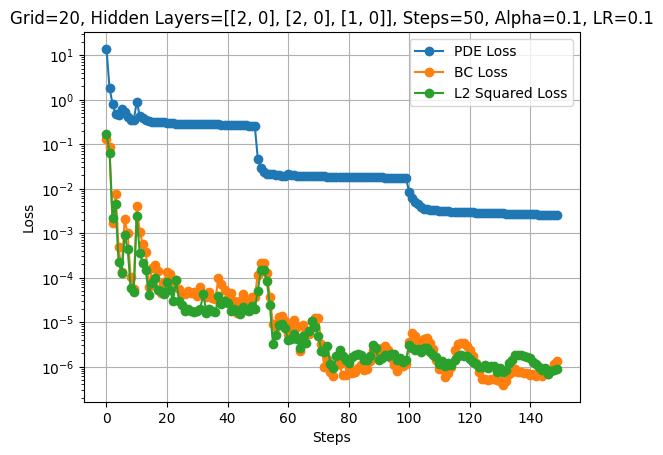

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.46e-01 | bc loss: 1.73e-05 | l2: 2.17e-05 : 100%|█████| 100/100 [02:03<00:00,  1.24s/it]
pde loss: 1.55e-02 | bc loss: 8.95e-07 | l2: 1.81e-06 : 100%|█████| 100/100 [02:02<00:00,  1.23s/it]
pde loss: 2.45e-03 | bc loss: 1.61e-06 | l2: 4.46e-06 : 100%|█████| 100/100 [01:07<00:00,  1.49it/s]


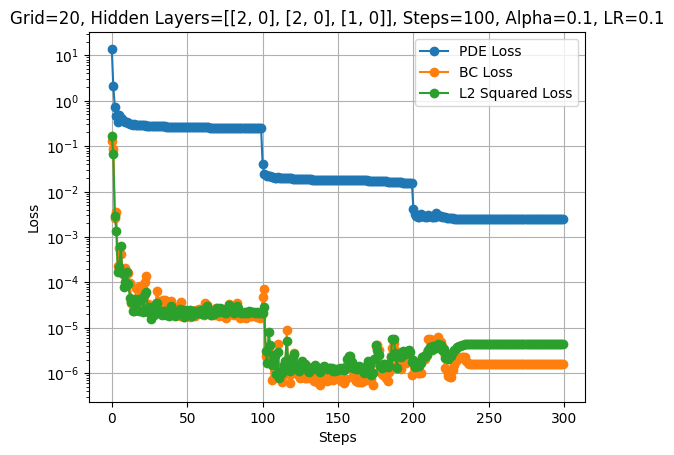

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.55e-02 | bc loss: 6.10e-06 | l2: 3.16e-06 : 100%|███████| 50/50 [01:01<00:00,  1.24s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:12<00:00,  1.45s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:12<00:00,  1.46s/it]


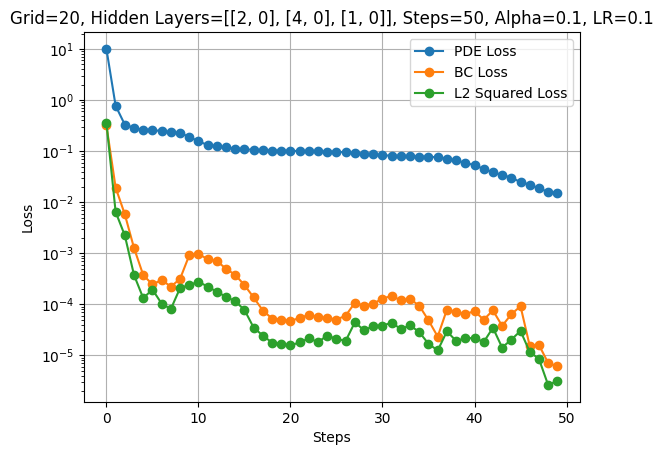

checkpoint directory created: ./model
saving model version 0.0


pde loss: 6.77e-03 | bc loss: 3.10e-06 | l2: 1.68e-06 : 100%|█████| 100/100 [02:00<00:00,  1.20s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:23<00:00,  1.43s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:23<00:00,  1.43s/it]


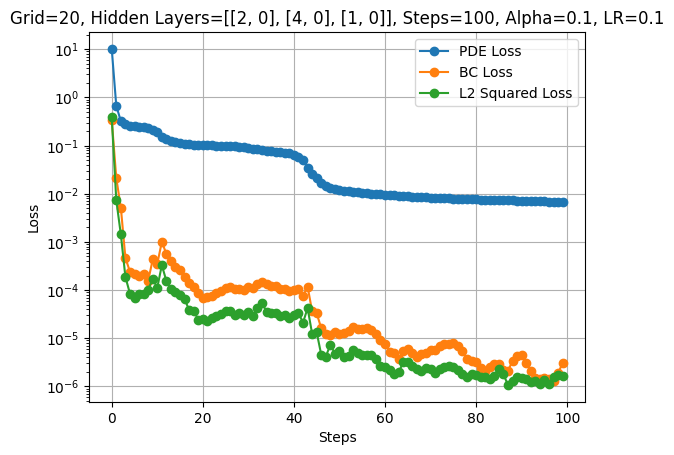

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.42e-01 | bc loss: 8.87e-06 | l2: 1.62e-05 : 100%|███████| 50/50 [01:01<00:00,  1.22s/it]
pde loss: 1.69e-02 | bc loss: 9.73e-07 | l2: 1.09e-06 : 100%|███████| 50/50 [00:59<00:00,  1.18s/it]
pde loss: 2.70e-03 | bc loss: 4.84e-07 | l2: 6.65e-07 : 100%|███████| 50/50 [00:32<00:00,  1.53it/s]


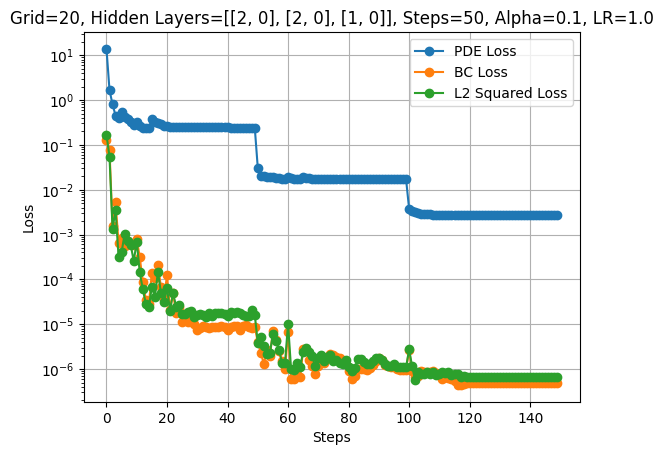

checkpoint directory created: ./model
saving model version 0.0


pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:20<00:00,  1.41s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:22<00:00,  1.43s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:22<00:00,  1.43s/it]


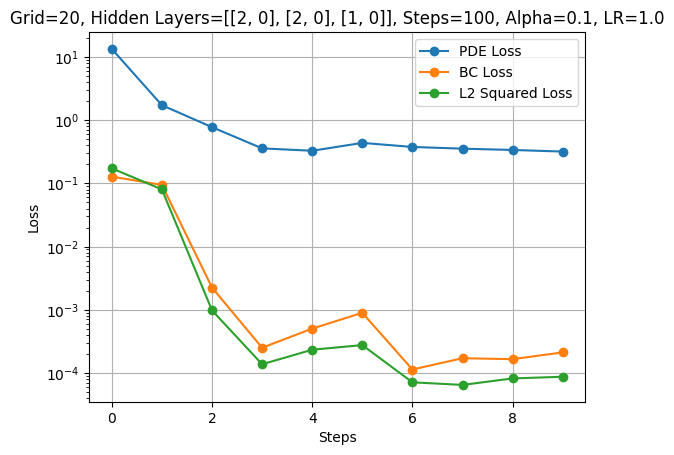

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.35e-02 | bc loss: 6.00e-05 | l2: 1.68e-05 : 100%|███████| 50/50 [01:00<00:00,  1.21s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:12<00:00,  1.44s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|██████████████████████| 50/50 [01:12<00:00,  1.44s/it]


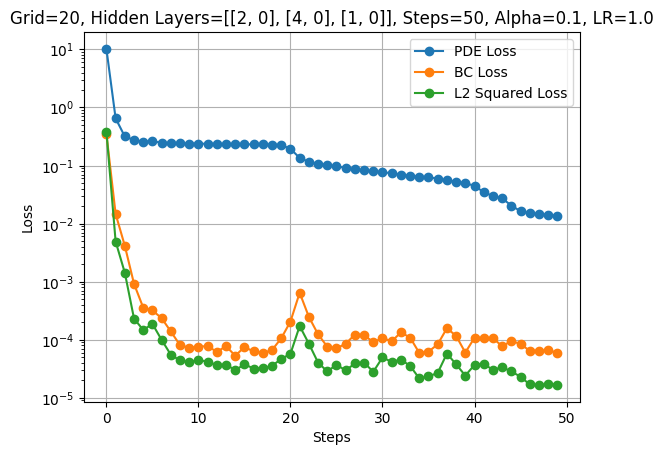

checkpoint directory created: ./model
saving model version 0.0


pde loss: 7.07e-03 | bc loss: 1.29e-06 | l2: 1.02e-06 : 100%|█████| 100/100 [02:01<00:00,  1.22s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:24<00:00,  1.44s/it]
pde loss: nan | bc loss: nan | l2: nan : 100%|████████████████████| 100/100 [02:24<00:00,  1.44s/it]


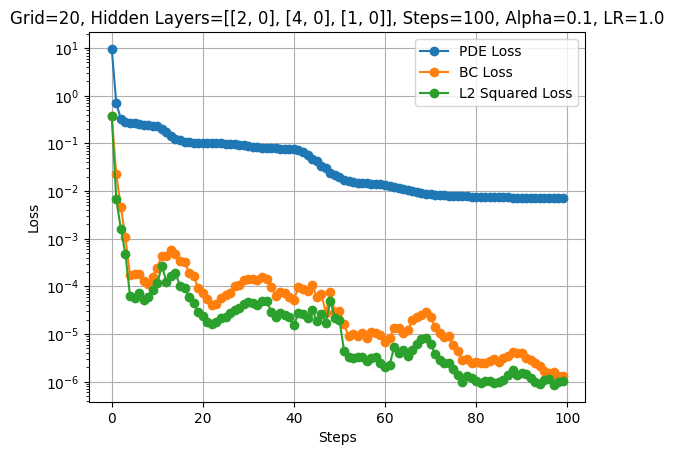

    Alpha  Learning Rate  Grid             Hidden Layers  Steps  \
0    0.01            0.1    20  [[2, 0], [2, 0], [1, 0]]     50   
1    0.01            0.1    20  [[2, 0], [2, 0], [1, 0]]    100   
2    0.01            0.1    20  [[2, 0], [4, 0], [1, 0]]     50   
3    0.01            0.1    20  [[2, 0], [4, 0], [1, 0]]    100   
4    0.01            1.0    20  [[2, 0], [2, 0], [1, 0]]     50   
5    0.01            1.0    20  [[2, 0], [2, 0], [1, 0]]    100   
6    0.01            1.0    20  [[2, 0], [4, 0], [1, 0]]     50   
7    0.01            1.0    20  [[2, 0], [4, 0], [1, 0]]    100   
8    0.10            0.1    20  [[2, 0], [2, 0], [1, 0]]     50   
9    0.10            0.1    20  [[2, 0], [2, 0], [1, 0]]    100   
10   0.10            0.1    20  [[2, 0], [4, 0], [1, 0]]     50   
11   0.10            0.1    20  [[2, 0], [4, 0], [1, 0]]    100   
12   0.10            1.0    20  [[2, 0], [2, 0], [1, 0]]     50   
13   0.10            1.0    20  [[2, 0], [2, 0], [1, 0]]    10

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1081: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(w_large, w_large))
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0+z0)))


Visualize model =  [0.1, 0.1, [[2, 0], [4, 0], [1, 0]], 100]
Visualize model =  [0.1, 1.0, [[2, 0], [2, 0], [1, 0]], 50]
Visualize model =  [0.1, 1.0, [[2, 0], [2, 0], [1, 0]], 100]


UnboundLocalError: local variable 'alpha_mask' referenced before assignment

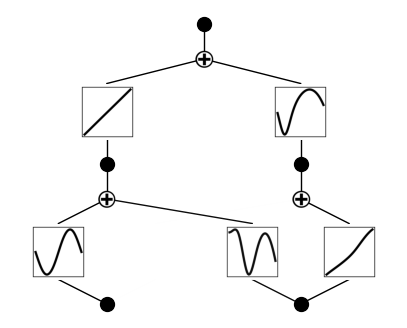

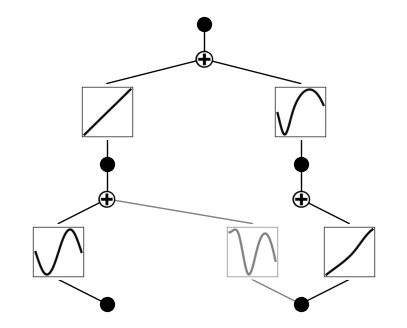

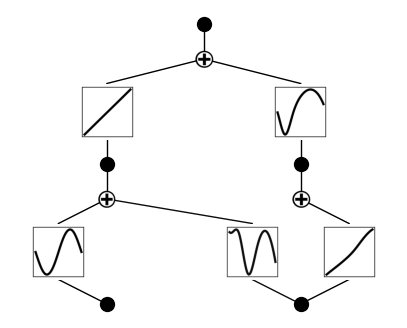

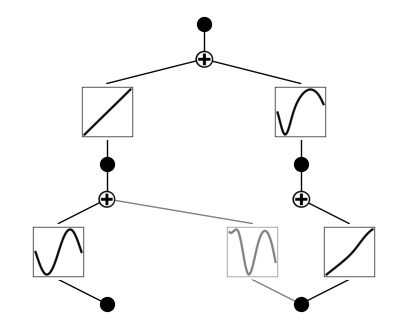

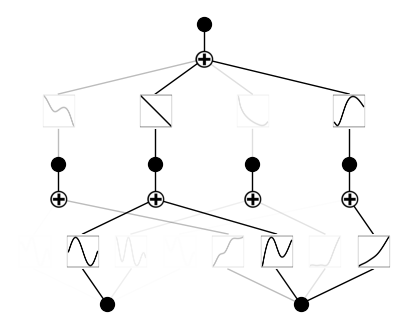

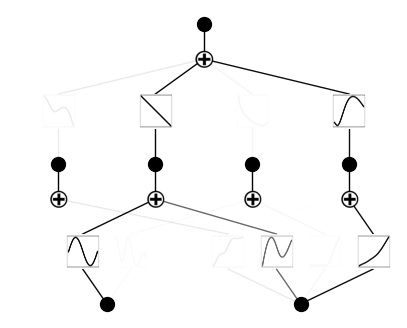

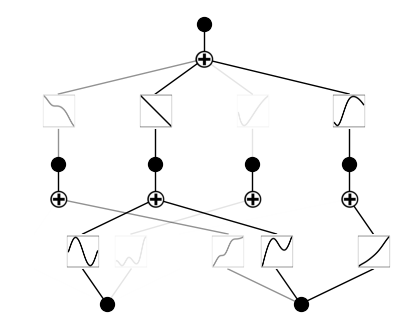

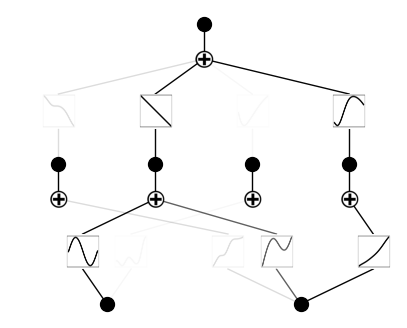

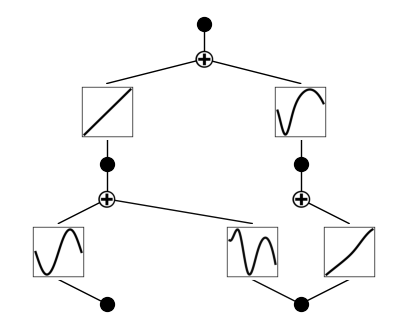

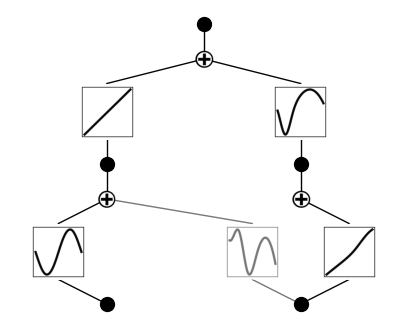

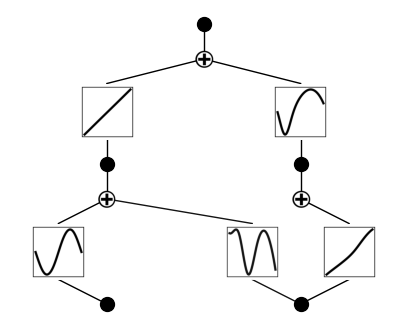

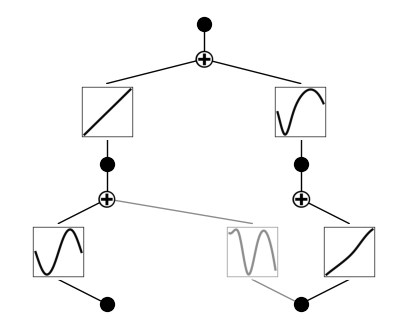

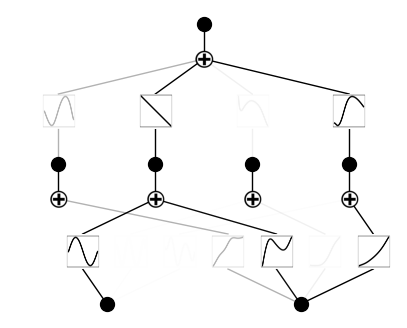

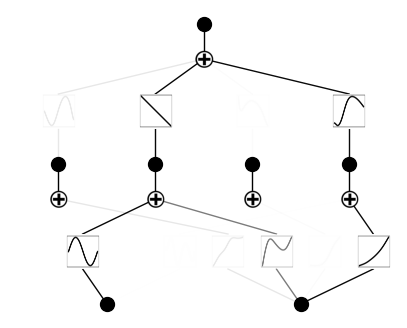

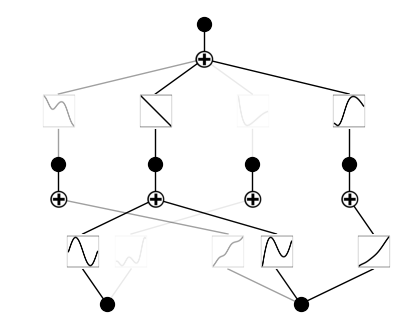

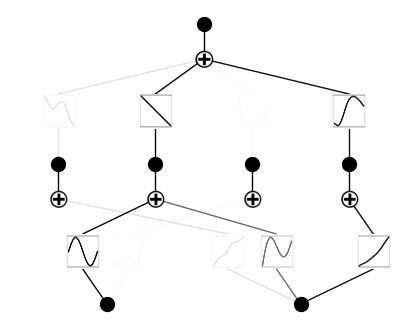

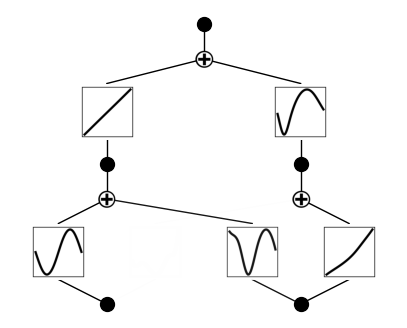

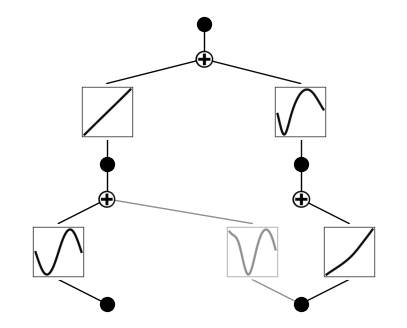

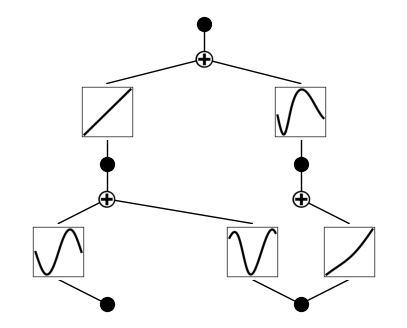

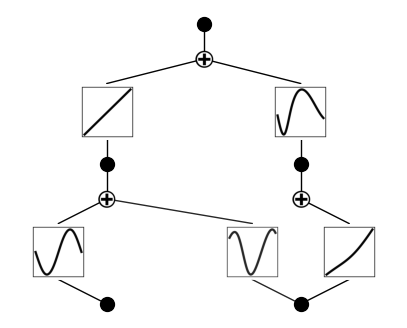

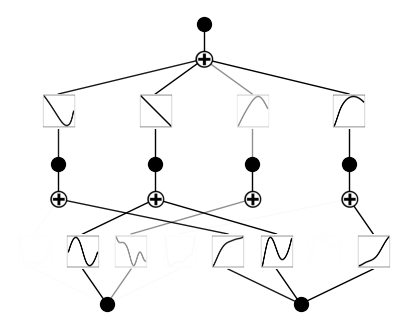

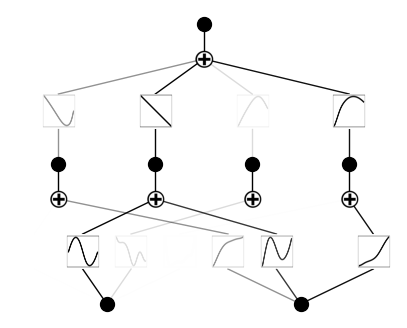

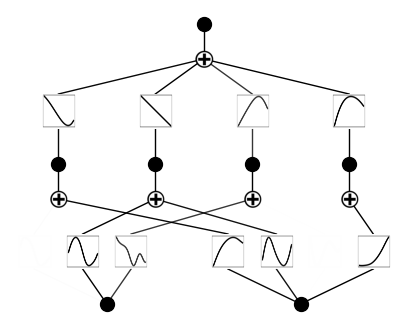

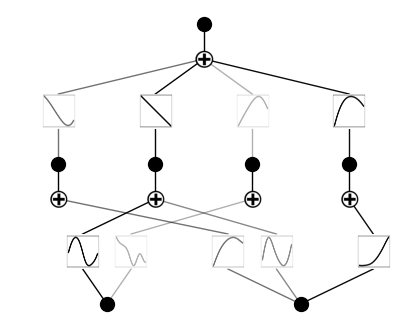

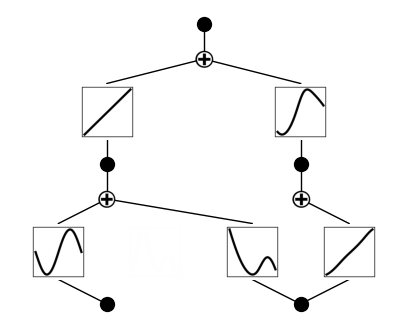

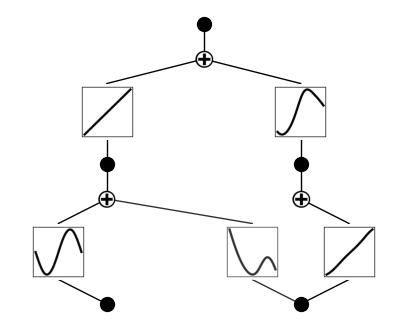

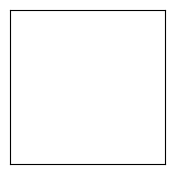

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools
from kan import *
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []

# Hyperparameters
dim = 2
np_i = 51
np_b = 51
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
sampling_mode = 'mesh'  # 'random' or 'mesh'
grids = [5, 10, 20]
steps = 5

# Define functions
sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) + torch.sin(torch.pi * x[:, [1]])
source_fun = lambda x: - torch.pi**2 * torch.sin(torch.pi * x[:, [0]]) -torch.pi**2* torch.sin(torch.pi * x[:, [1]])

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

# Prepare data
x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

if sampling_mode == 'mesh':
    x_i = torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
else:
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

x_i = x_i.to(device)

helper = lambda X, Y: torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0).to(device)

# Training function
def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # Boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if step % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses


alphas = [0.01, 0.1]
learning_rates = [ 0.1, 1.0]
grids = [5,10,20]
hidden_layers_list = [[2, 2, 1], [2, 4,1]]
steps_list = [50, 100]

pde_losses, bc_losses,l2_losses = [],[],[]

log = 1


# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):

    pde_losses ,bc_losses,l2_losses = [],[],[]
    for grid in grids:
      if grid == grids[0]:
          model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
          models.append(model)
          parameters_to_print.append([alpha, learning_rate,hidden_layers, steps])
          model = model.speed()
      else:
          model.save_act = True
          model.get_act(x_i)
          model = model.refine(grid)
          model = model.speed()

      pde_losses, bc_losses, l2_losses= train_model(model, x_i, x_b, steps, alpha, log_interval)
      # Store results
    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        'Final PDE Loss': pde_losses[-1],
        'Final BC Loss': bc_losses[-1],
        'Final L2 Loss': l2_losses[-1]
    })

    plt.plot(pde_losses, marker='o', label='PDE Loss')
    plt.plot(bc_losses, marker='o', label='BC Loss')
    plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    plt.grid(True)
    plt.show()

results_df = pd.DataFrame(results)

results_df.to_csv('kan_hyperparameter_results.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))
for i in range(len(models)):
  print("Visualize model = ",parameters_to_print[i])
  models[i].plot(beta = 10)
  models[i].plot()
  formula = models[i].symbolic_formula()[0][0]
  ex_round(formula,6)

Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 5.05e-02 | bc loss: 7.02e-07 | l2: 9.20e-05 : 100%|███████| 50/50 [00:23<00:00,  2.10it/s]
pde loss: 5.76e-03 | bc loss: 1.72e-08 | l2: 1.49e-05 : 100%|███████| 50/50 [00:16<00:00,  3.00it/s]
pde loss: 1.98e-03 | bc loss: 2.46e-07 | l2: 1.34e-05 : 100%|███████| 50/50 [00:10<00:00,  4.72it/s]


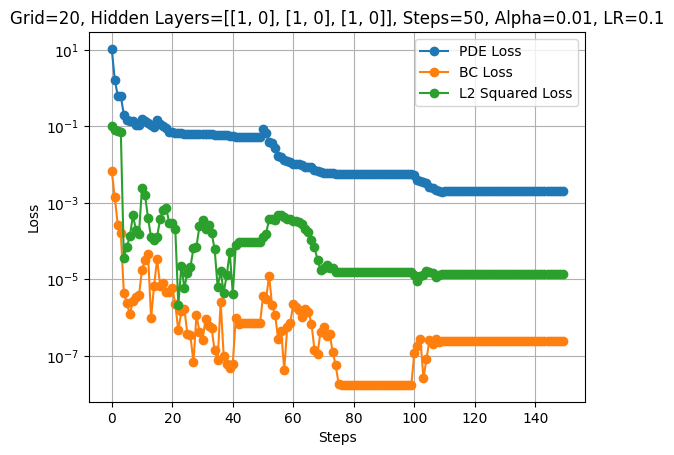

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.43e-01 | bc loss: 1.92e-07 | l2: 1.13e-04 : 100%|█████| 100/100 [00:24<00:00,  4.05it/s]
pde loss: 1.00e-02 | bc loss: 7.05e-08 | l2: 5.82e-06 : 100%|█████| 100/100 [00:26<00:00,  3.72it/s]
pde loss: 2.49e-03 | bc loss: 3.21e-07 | l2: 5.25e-06 : 100%|█████| 100/100 [00:20<00:00,  4.82it/s]


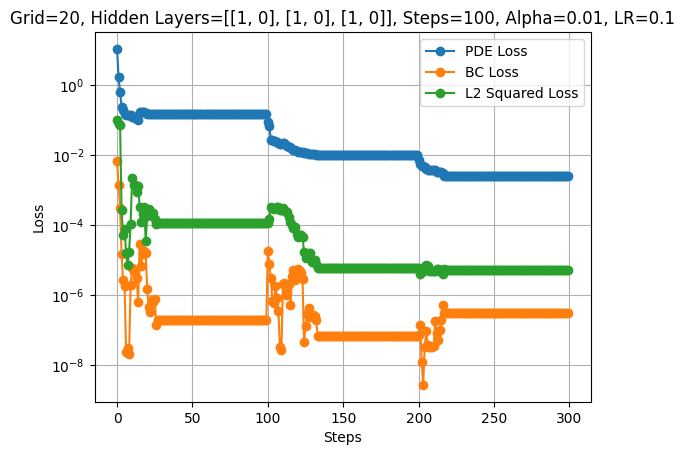

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.83e-03 | bc loss: 4.46e-08 | l2: 5.08e-06 : 100%|███████| 50/50 [00:16<00:00,  2.97it/s]
pde loss: 1.38e-04 | bc loss: 2.19e-09 | l2: 1.38e-06 : 100%|███████| 50/50 [00:21<00:00,  2.35it/s]
pde loss: 3.96e-06 | bc loss: 1.50e-10 | l2: 9.74e-07 : 100%|███████| 50/50 [00:12<00:00,  4.09it/s]


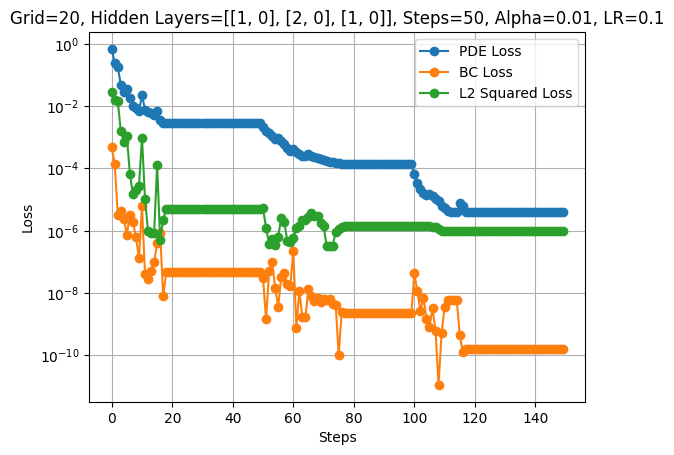

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.42e-03 | bc loss: 7.11e-11 | l2: 2.06e-07 : 100%|█████| 100/100 [00:33<00:00,  3.01it/s]
pde loss: 8.50e-05 | bc loss: 1.95e-10 | l2: 8.62e-07 : 100%|█████| 100/100 [00:28<00:00,  3.55it/s]
pde loss: 1.06e-05 | bc loss: 9.63e-10 | l2: 5.26e-08 : 100%|█████| 100/100 [00:24<00:00,  4.06it/s]


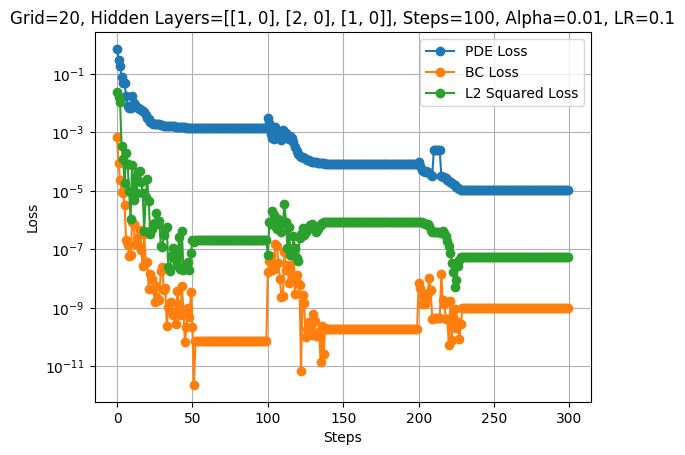

checkpoint directory created: ./model
saving model version 0.0


pde loss: 3.65e-04 | bc loss: 2.17e-11 | l2: 4.46e-07 : 100%|███████| 50/50 [00:26<00:00,  1.91it/s]
pde loss: 1.64e-05 | bc loss: 7.06e-12 | l2: 1.63e-07 : 100%|███████| 50/50 [00:26<00:00,  1.87it/s]
pde loss: 1.15e-06 | bc loss: 1.80e-10 | l2: 4.30e-07 : 100%|███████| 50/50 [00:15<00:00,  3.19it/s]


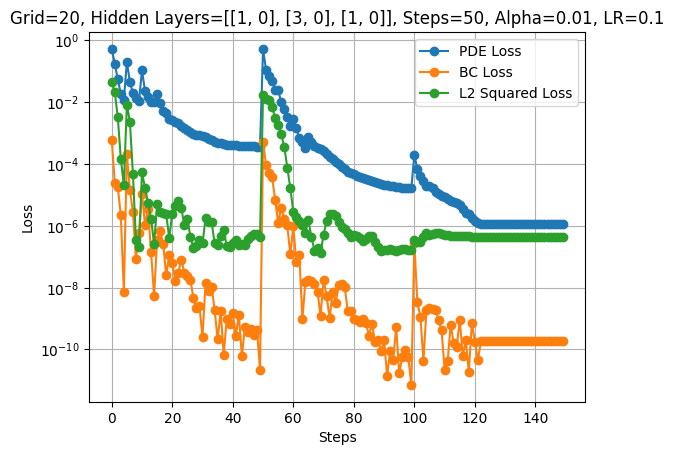

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.16e-04 | bc loss: 7.41e-11 | l2: 5.70e-06 : 100%|█████| 100/100 [00:37<00:00,  2.66it/s]
pde loss: 1.07e-05 | bc loss: 8.09e-12 | l2: 1.64e-07 : 100%|█████| 100/100 [00:33<00:00,  2.96it/s]
pde loss: 9.82e-08 | bc loss: 3.35e-11 | l2: 1.56e-07 : 100%|█████| 100/100 [00:19<00:00,  5.03it/s]


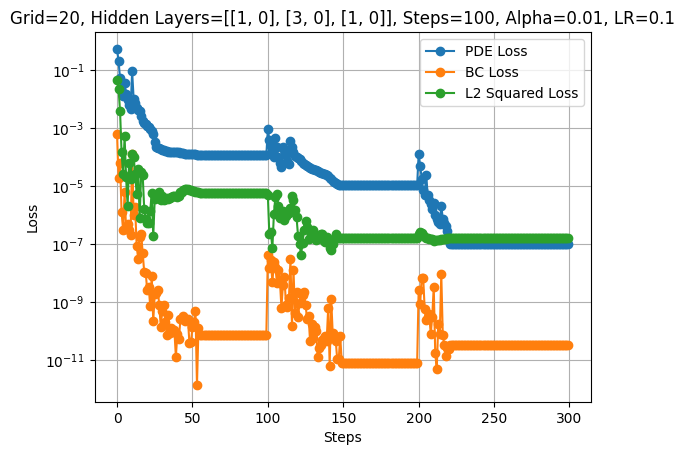

checkpoint directory created: ./model
saving model version 0.0


pde loss: 4.22e-02 | bc loss: 2.63e-07 | l2: 1.27e-05 : 100%|███████| 50/50 [00:25<00:00,  1.97it/s]
pde loss: 1.54e-02 | bc loss: 3.90e-07 | l2: 2.66e-04 : 100%|███████| 50/50 [00:14<00:00,  3.47it/s]
pde loss: 5.18e-03 | bc loss: 8.26e-07 | l2: 2.39e-04 : 100%|███████| 50/50 [00:12<00:00,  3.87it/s]


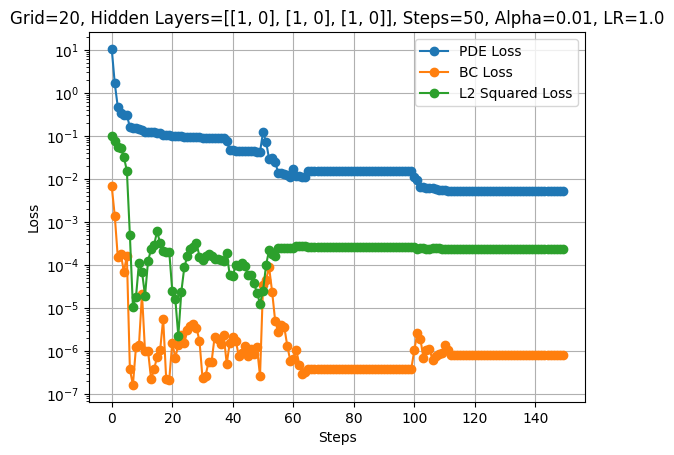

checkpoint directory created: ./model
saving model version 0.0


pde loss: 6.58e-02 | bc loss: 2.16e-08 | l2: 3.66e-06 : 100%|█████| 100/100 [00:33<00:00,  2.94it/s]
pde loss: 6.12e-03 | bc loss: 5.10e-09 | l2: 1.94e-06 : 100%|█████| 100/100 [00:27<00:00,  3.63it/s]
pde loss: 1.21e-03 | bc loss: 4.02e-08 | l2: 1.64e-06 : 100%|█████| 100/100 [00:18<00:00,  5.37it/s]


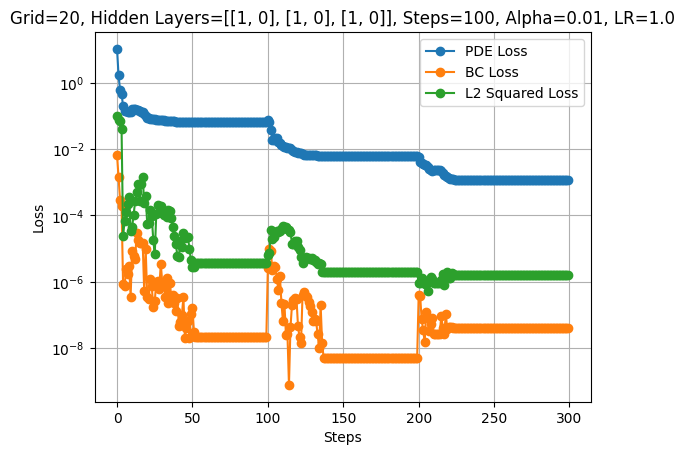

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.62e-04 | bc loss: 3.45e-10 | l2: 4.96e-07 : 100%|███████| 50/50 [00:25<00:00,  1.95it/s]
pde loss: 9.75e-05 | bc loss: 5.05e-09 | l2: 3.14e-07 : 100%|███████| 50/50 [00:18<00:00,  2.69it/s]
pde loss: 2.11e-05 | bc loss: 1.40e-09 | l2: 7.49e-08 : 100%|███████| 50/50 [00:12<00:00,  4.10it/s]


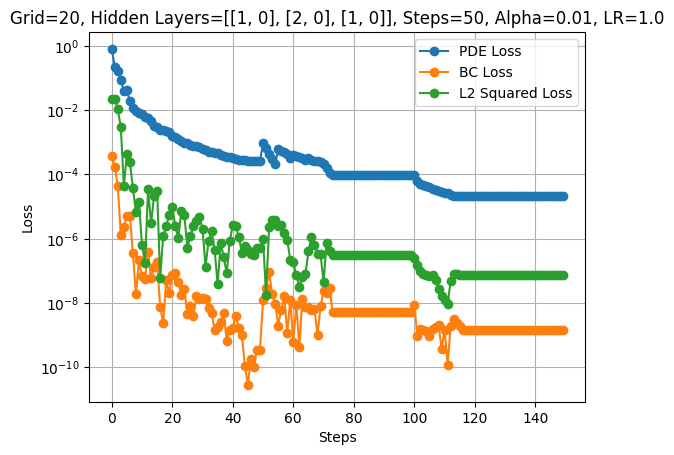

checkpoint directory created: ./model
saving model version 0.0


pde loss: 5.44e-04 | bc loss: 3.38e-10 | l2: 1.81e-06 : 100%|█████| 100/100 [00:29<00:00,  3.34it/s]
pde loss: 4.55e-05 | bc loss: 2.22e-10 | l2: 3.17e-07 : 100%|█████| 100/100 [00:35<00:00,  2.81it/s]
pde loss: 7.74e-05 | bc loss: 2.09e-10 | l2: 9.07e-09 : 100%|█████| 100/100 [00:24<00:00,  4.00it/s]


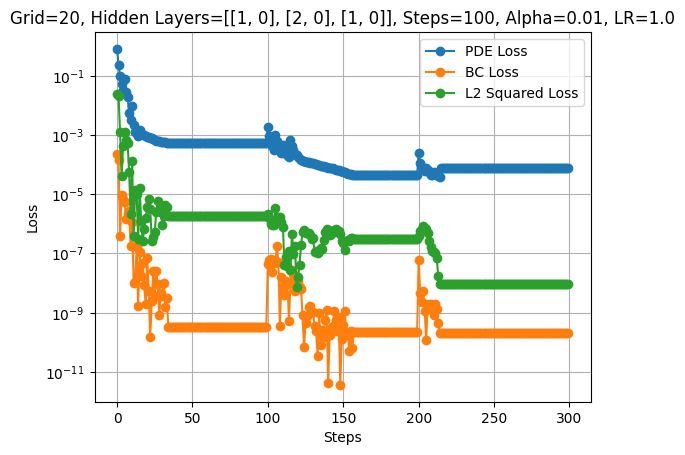

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.91e-04 | bc loss: 1.27e-10 | l2: 1.23e-06 : 100%|███████| 50/50 [00:26<00:00,  1.88it/s]
pde loss: 5.58e-05 | bc loss: 1.21e-11 | l2: 1.12e-04 : 100%|███████| 50/50 [00:26<00:00,  1.89it/s]
pde loss: 1.91e-04 | bc loss: 3.41e-09 | l2: 1.22e-04 : 100%|███████| 50/50 [00:12<00:00,  4.05it/s]


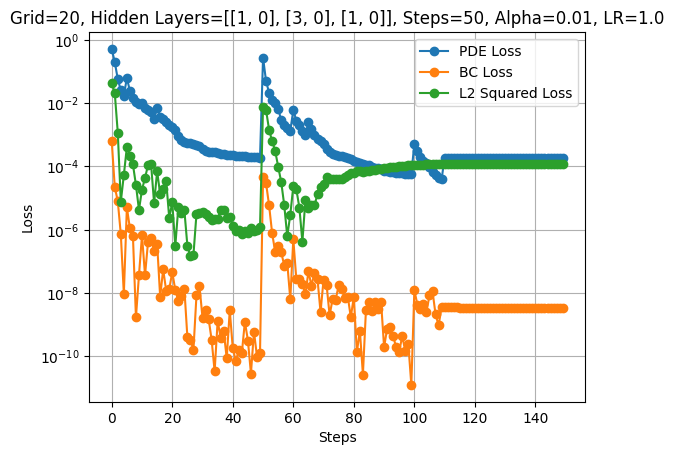

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.72e-01 | bc loss: 1.26e-05 | l2: 1.18e-05 : 100%|█████| 100/100 [00:28<00:00,  3.51it/s]
pde loss: 6.54e-06 | bc loss: 3.99e-12 | l2: 1.05e-07 : 100%|█████| 100/100 [00:35<00:00,  2.83it/s]
pde loss: 3.62e-06 | bc loss: 4.48e-12 | l2: 1.03e-07 : 100%|█████| 100/100 [00:23<00:00,  4.33it/s]


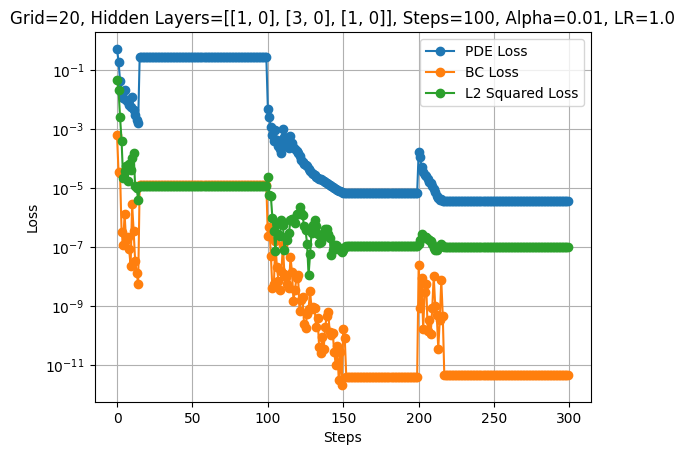

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.38e-01 | bc loss: 6.12e-05 | l2: 3.84e-04 : 100%|███████| 50/50 [00:19<00:00,  2.55it/s]
pde loss: 1.07e-02 | bc loss: 2.03e-05 | l2: 1.35e-04 : 100%|███████| 50/50 [00:25<00:00,  1.95it/s]
pde loss: 3.53e-03 | bc loss: 2.49e-05 | l2: 1.17e-04 : 100%|███████| 50/50 [00:15<00:00,  3.14it/s]


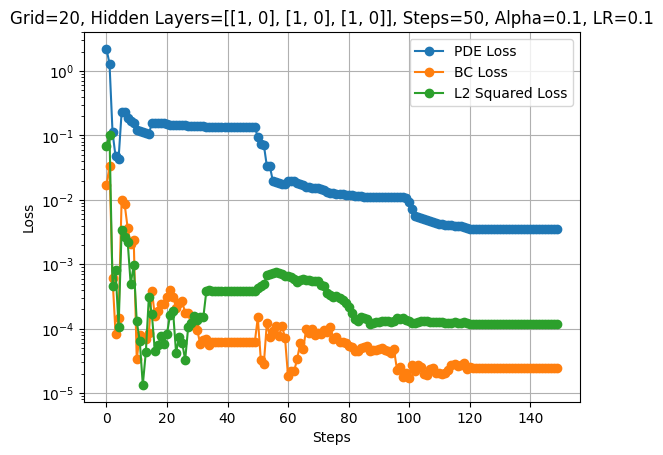

checkpoint directory created: ./model
saving model version 0.0


pde loss: 7.76e-02 | bc loss: 1.44e-05 | l2: 1.01e-04 : 100%|█████| 100/100 [00:33<00:00,  3.02it/s]
pde loss: 1.05e-02 | bc loss: 3.64e-05 | l2: 1.84e-04 : 100%|█████| 100/100 [00:19<00:00,  5.03it/s]
pde loss: 3.59e-03 | bc loss: 3.57e-05 | l2: 1.63e-04 : 100%|█████| 100/100 [00:22<00:00,  4.51it/s]


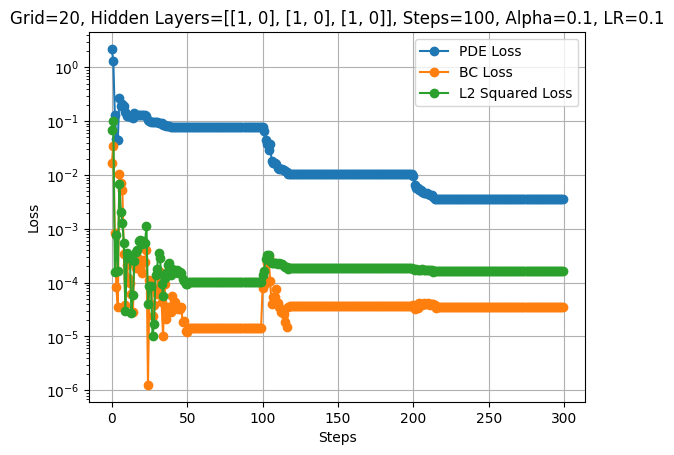

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.01e-03 | bc loss: 1.01e-07 | l2: 3.11e-06 : 100%|███████| 50/50 [00:20<00:00,  2.45it/s]
pde loss: 7.03e-05 | bc loss: 4.77e-08 | l2: 8.95e-08 : 100%|███████| 50/50 [00:19<00:00,  2.56it/s]
pde loss: 1.85e-06 | bc loss: 2.35e-08 | l2: 1.03e-08 : 100%|███████| 50/50 [00:10<00:00,  4.70it/s]


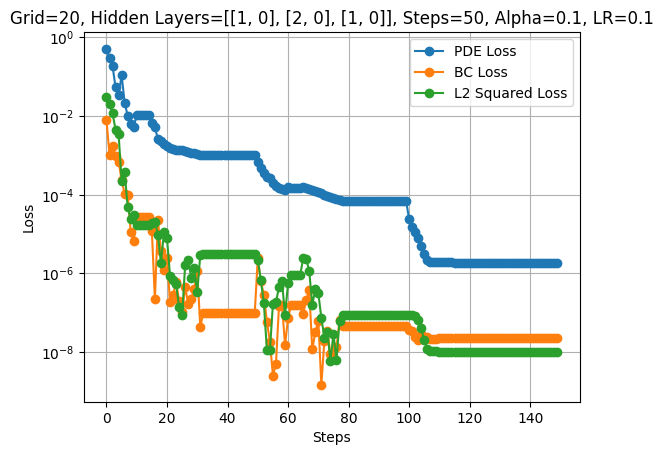

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.34e-03 | bc loss: 1.43e-07 | l2: 1.23e-06 : 100%|█████| 100/100 [00:37<00:00,  2.64it/s]
pde loss: 4.55e-05 | bc loss: 1.52e-08 | l2: 6.77e-08 : 100%|█████| 100/100 [00:29<00:00,  3.34it/s]
pde loss: 1.47e-05 | bc loss: 1.52e-09 | l2: 1.25e-07 : 100%|█████| 100/100 [00:21<00:00,  4.57it/s]


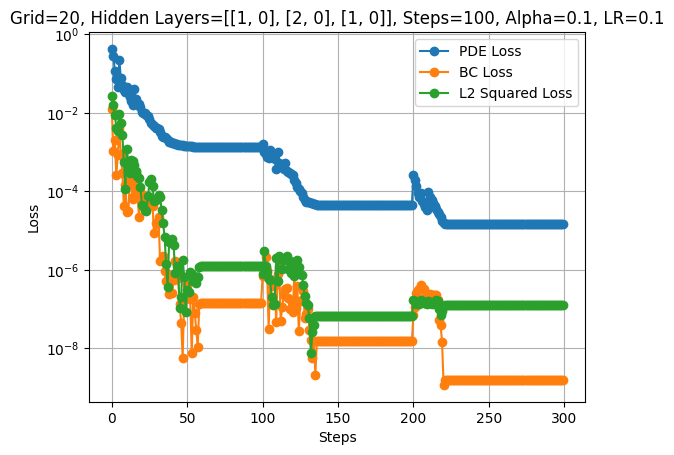

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.42e-03 | bc loss: 2.99e-08 | l2: 2.82e-07 : 100%|███████| 50/50 [00:26<00:00,  1.86it/s]
pde loss: 8.90e-06 | bc loss: 4.00e-10 | l2: 5.77e-07 : 100%|███████| 50/50 [00:23<00:00,  2.16it/s]
pde loss: 7.79e-07 | bc loss: 1.54e-09 | l2: 1.18e-06 : 100%|███████| 50/50 [00:17<00:00,  2.93it/s]


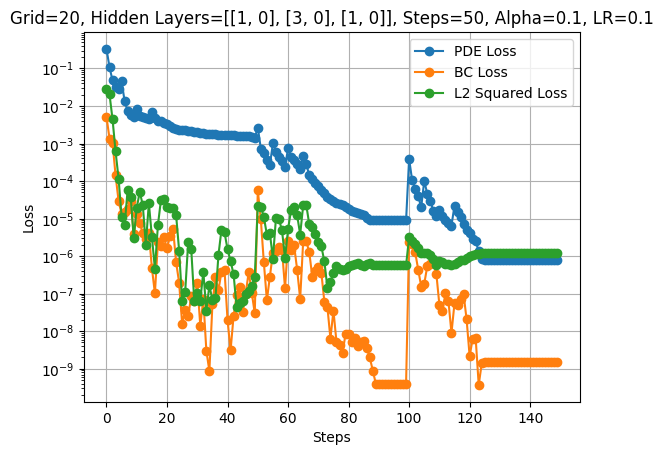

checkpoint directory created: ./model
saving model version 0.0


pde loss: 3.19e-04 | bc loss: 1.95e-09 | l2: 3.85e-06 : 100%|█████| 100/100 [00:38<00:00,  2.57it/s]
pde loss: 7.61e-06 | bc loss: 7.08e-10 | l2: 3.87e-07 : 100%|█████| 100/100 [00:38<00:00,  2.62it/s]
pde loss: 2.32e-06 | bc loss: 1.32e-09 | l2: 1.38e-07 : 100%|█████| 100/100 [00:22<00:00,  4.38it/s]


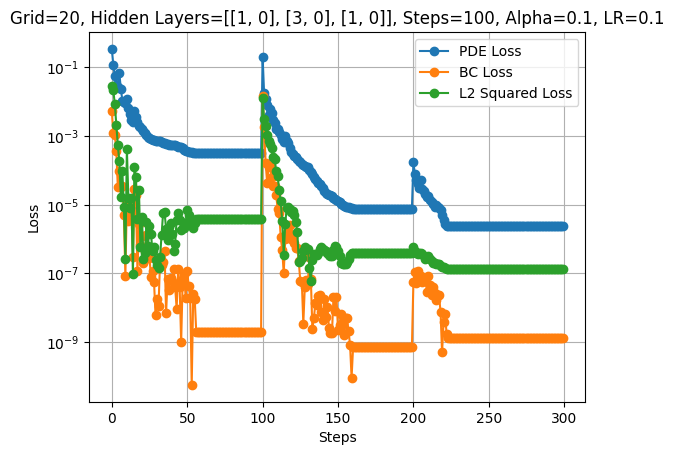

checkpoint directory created: ./model
saving model version 0.0


pde loss: 9.81e-02 | bc loss: 3.16e-04 | l2: 2.51e-03 : 100%|███████| 50/50 [00:26<00:00,  1.89it/s]
pde loss: 2.24e-02 | bc loss: 2.82e-04 | l2: 2.00e-03 : 100%|███████| 50/50 [00:18<00:00,  2.77it/s]
pde loss: 1.49e-02 | bc loss: 2.72e-04 | l2: 1.94e-03 : 100%|███████| 50/50 [00:12<00:00,  3.86it/s]


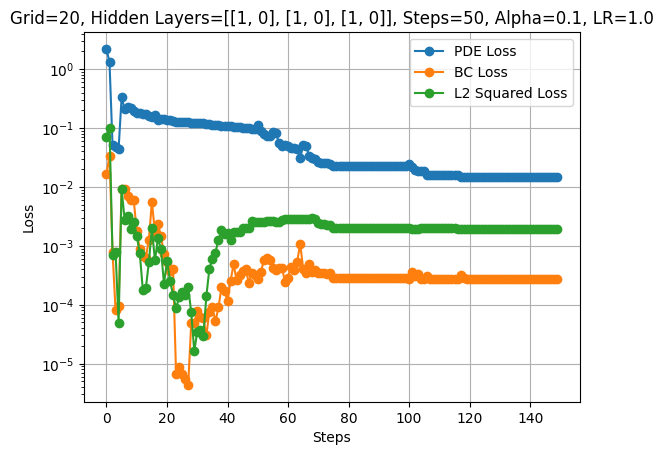

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.05e-01 | bc loss: 8.64e-05 | l2: 3.14e-04 : 100%|█████| 100/100 [00:30<00:00,  3.25it/s]
pde loss: 5.49e-02 | bc loss: 2.64e-04 | l2: 1.37e-04 : 100%|█████| 100/100 [00:24<00:00,  4.12it/s]
pde loss: 1.46e-02 | bc loss: 2.60e-04 | l2: 1.53e-04 : 100%|█████| 100/100 [00:20<00:00,  4.81it/s]


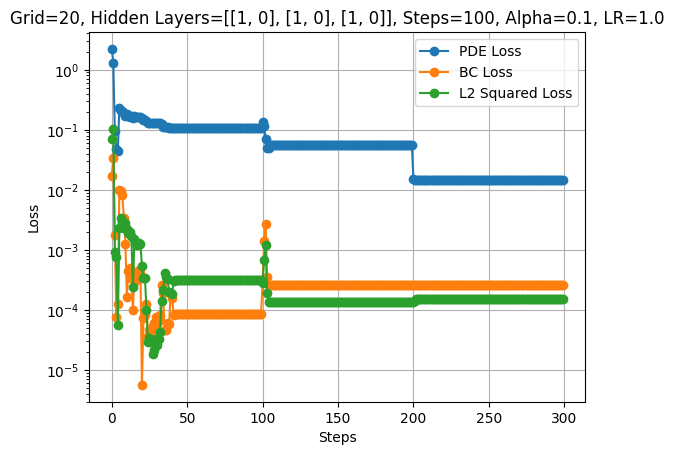

checkpoint directory created: ./model
saving model version 0.0


pde loss: 8.66e-04 | bc loss: 6.53e-07 | l2: 2.11e-06 : 100%|███████| 50/50 [00:17<00:00,  2.81it/s]
pde loss: 1.65e-04 | bc loss: 1.10e-06 | l2: 2.23e-06 : 100%|███████| 50/50 [00:14<00:00,  3.55it/s]
pde loss: 3.09e-05 | bc loss: 1.03e-07 | l2: 2.22e-06 : 100%|███████| 50/50 [00:13<00:00,  3.81it/s]


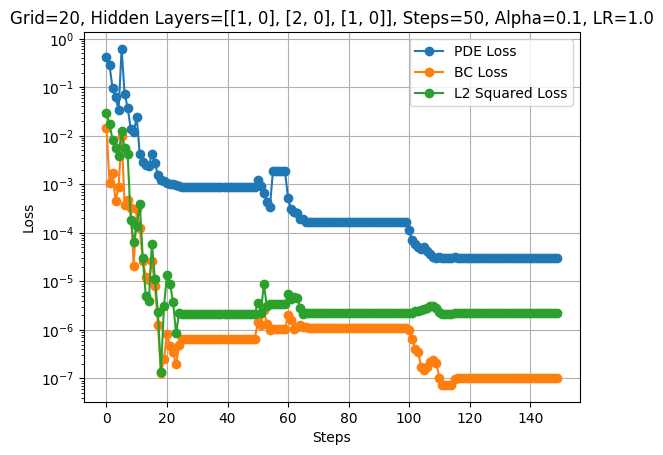

checkpoint directory created: ./model
saving model version 0.0


pde loss: 5.80e-04 | bc loss: 4.95e-07 | l2: 5.40e-07 : 100%|█████| 100/100 [00:27<00:00,  3.59it/s]
pde loss: 3.77e-05 | bc loss: 2.25e-09 | l2: 1.62e-07 : 100%|█████| 100/100 [00:26<00:00,  3.82it/s]
pde loss: 9.27e-06 | bc loss: 2.83e-09 | l2: 2.65e-07 : 100%|█████| 100/100 [00:19<00:00,  5.11it/s]


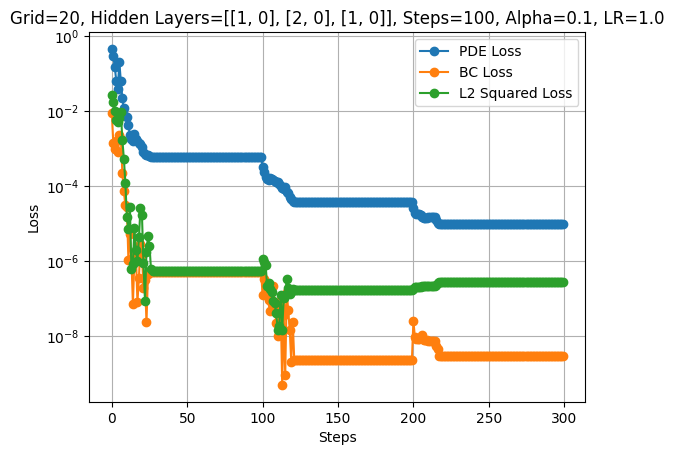

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.39e-03 | bc loss: 6.11e-07 | l2: 1.84e-07 : 100%|███████| 50/50 [00:26<00:00,  1.90it/s]
pde loss: 1.92e-03 | bc loss: 1.16e-06 | l2: 6.77e-07 : 100%|███████| 50/50 [00:14<00:00,  3.34it/s]
pde loss: 4.28e-07 | bc loss: 1.42e-10 | l2: 1.75e-07 : 100%|███████| 50/50 [00:19<00:00,  2.54it/s]


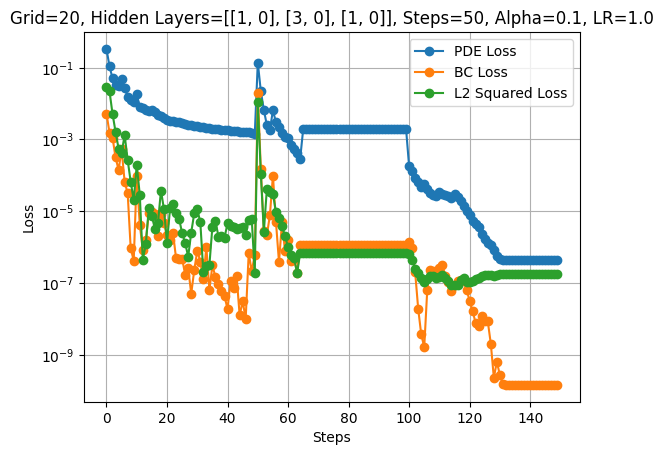

checkpoint directory created: ./model
saving model version 0.0


pde loss: 5.73e-04 | bc loss: 9.85e-08 | l2: 3.33e-06 : 100%|█████| 100/100 [00:52<00:00,  1.89it/s]
pde loss: 7.55e-05 | bc loss: 2.44e-08 | l2: 8.00e-06 : 100%|█████| 100/100 [00:31<00:00,  3.22it/s]
pde loss: 1.29e-06 | bc loss: 9.82e-09 | l2: 3.12e-06 : 100%|█████| 100/100 [00:25<00:00,  3.85it/s]


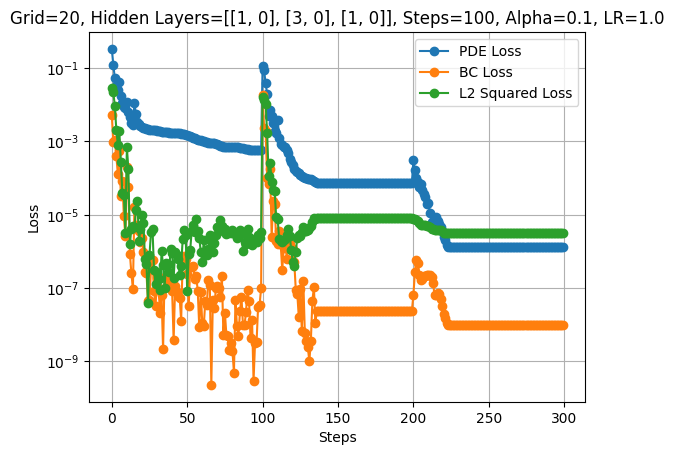

    Alpha  Learning Rate  Grid             Hidden Layers  Steps  \
0    0.01            0.1    20  [[1, 0], [1, 0], [1, 0]]     50   
1    0.01            0.1    20  [[1, 0], [1, 0], [1, 0]]    100   
2    0.01            0.1    20  [[1, 0], [2, 0], [1, 0]]     50   
3    0.01            0.1    20  [[1, 0], [2, 0], [1, 0]]    100   
4    0.01            0.1    20  [[1, 0], [3, 0], [1, 0]]     50   
5    0.01            0.1    20  [[1, 0], [3, 0], [1, 0]]    100   
6    0.01            1.0    20  [[1, 0], [1, 0], [1, 0]]     50   
7    0.01            1.0    20  [[1, 0], [1, 0], [1, 0]]    100   
8    0.01            1.0    20  [[1, 0], [2, 0], [1, 0]]     50   
9    0.01            1.0    20  [[1, 0], [2, 0], [1, 0]]    100   
10   0.01            1.0    20  [[1, 0], [3, 0], [1, 0]]     50   
11   0.01            1.0    20  [[1, 0], [3, 0], [1, 0]]    100   
12   0.10            0.1    20  [[1, 0], [1, 0], [1, 0]]     50   
13   0.10            0.1    20  [[1, 0], [1, 0], [1, 0]]    10

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1081: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(w_large, w_large))
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0+z0)))


Visualize model =  [0.01, 1.0, [[1, 0], [3, 0], [1, 0]], 100]
Visualize model =  [0.1, 0.1, [[1, 0], [1, 0], [1, 0]], 50]
Visualize model =  [0.1, 0.1, [[1, 0], [1, 0], [1, 0]], 100]
Visualize model =  [0.1, 0.1, [[1, 0], [2, 0], [1, 0]], 50]
Visualize model =  [0.1, 0.1, [[1, 0], [2, 0], [1, 0]], 100]
Visualize model =  [0.1, 0.1, [[1, 0], [3, 0], [1, 0]], 50]
Visualize model =  [0.1, 0.1, [[1, 0], [3, 0], [1, 0]], 100]
Visualize model =  [0.1, 1.0, [[1, 0], [1, 0], [1, 0]], 50]
Visualize model =  [0.1, 1.0, [[1, 0], [1, 0], [1, 0]], 100]
Visualize model =  [0.1, 1.0, [[1, 0], [2, 0], [1, 0]], 50]
Visualize model =  [0.1, 1.0, [[1, 0], [2, 0], [1, 0]], 100]
Visualize model =  [0.1, 1.0, [[1, 0], [3, 0], [1, 0]], 50]
Visualize model =  [0.1, 1.0, [[1, 0], [3, 0], [1, 0]], 100]


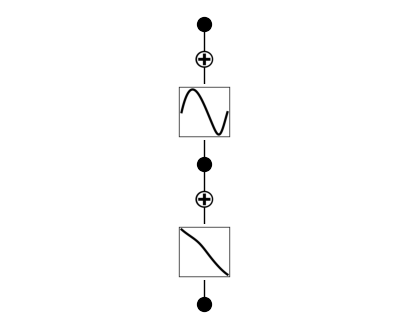

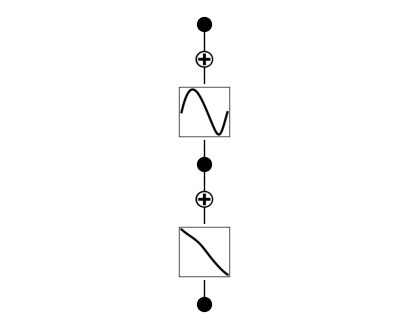

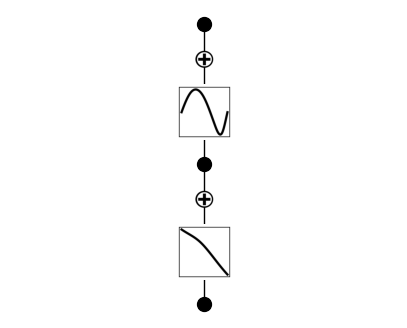

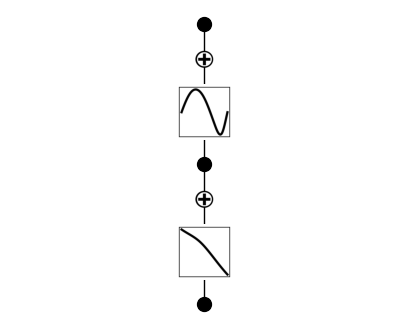

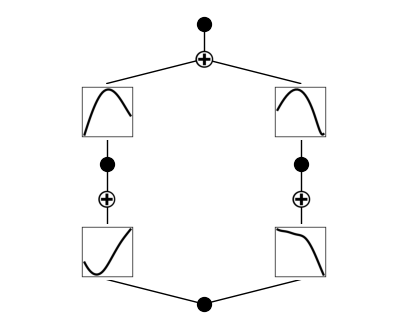

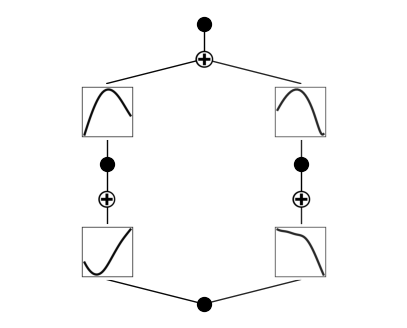

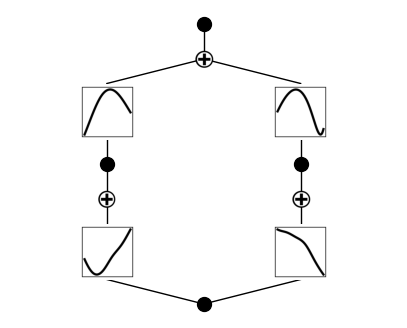

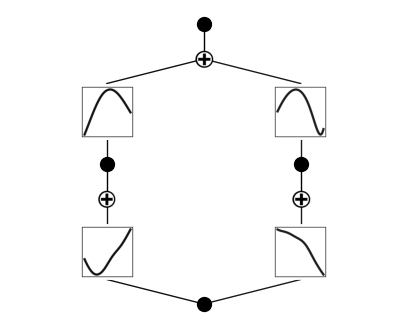

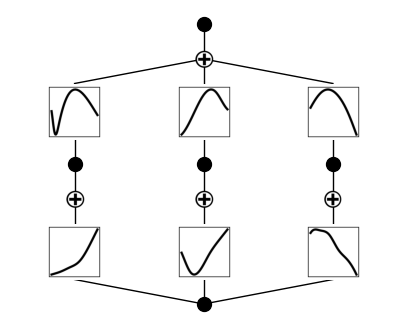

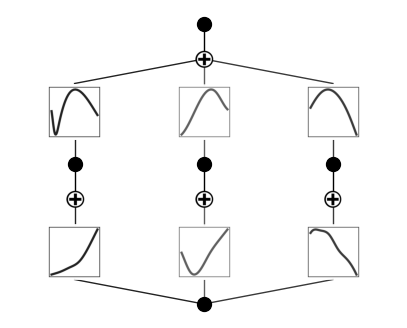

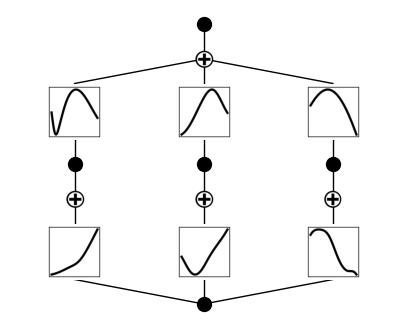

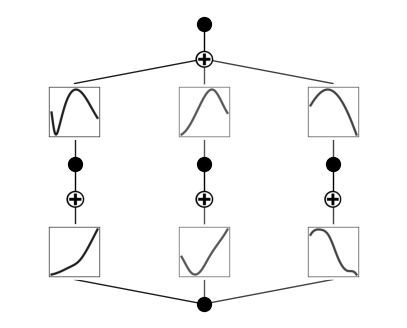

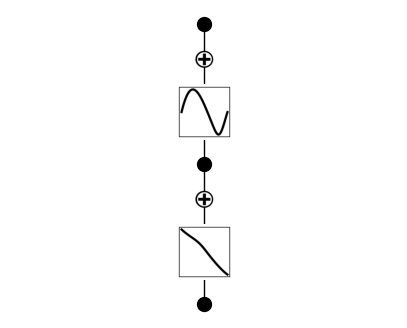

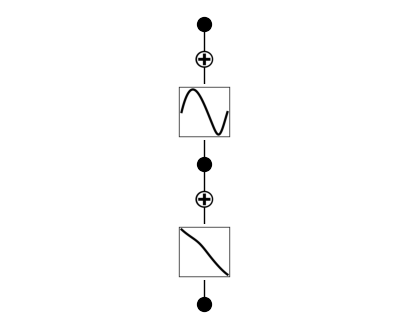

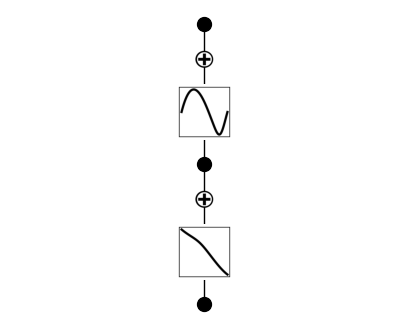

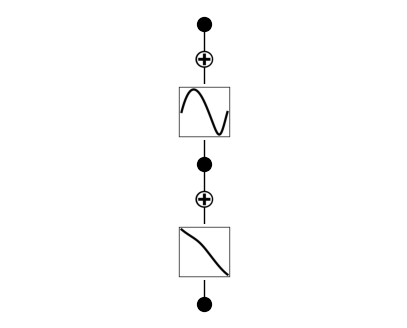

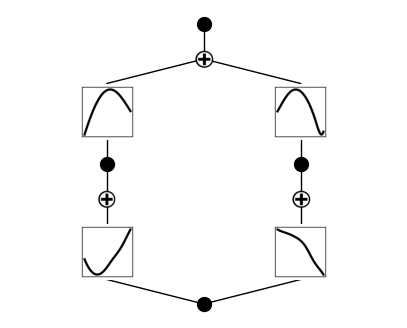

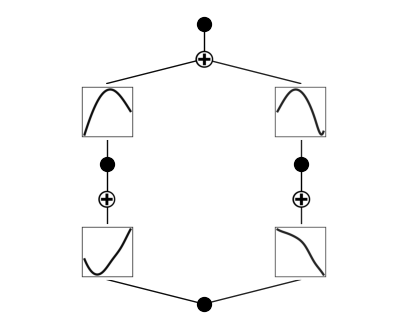

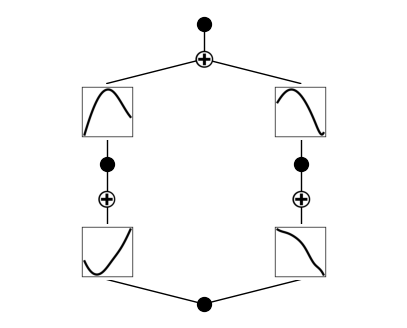

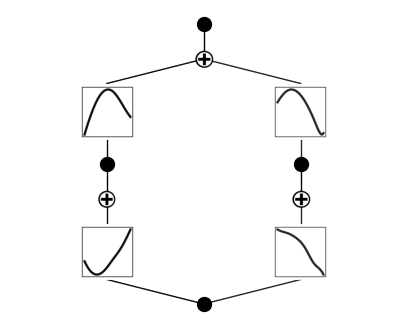

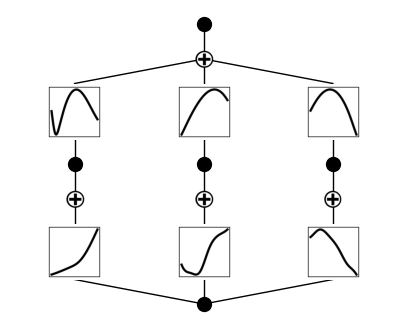

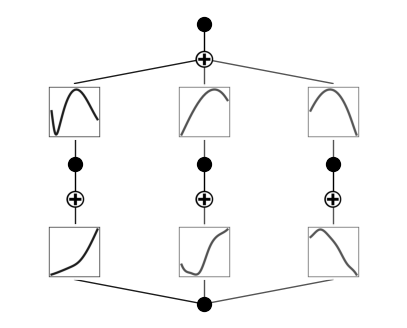

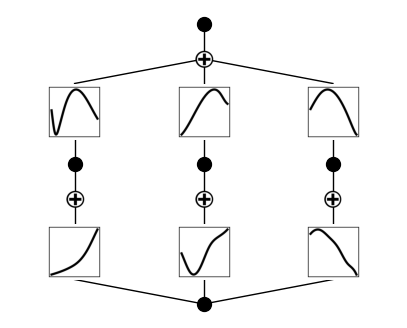

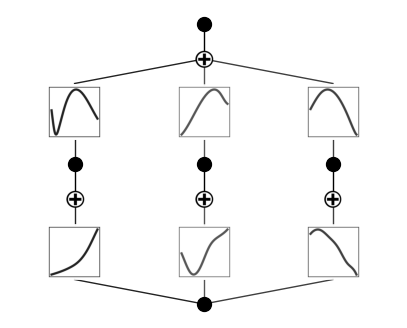

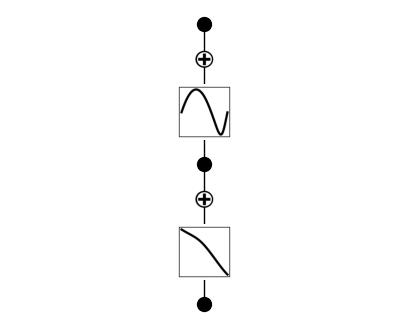

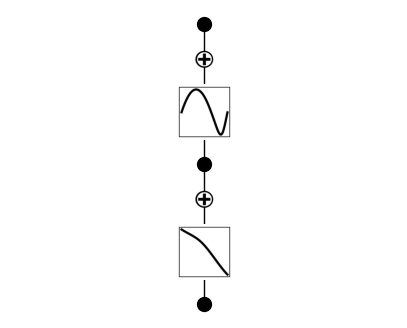

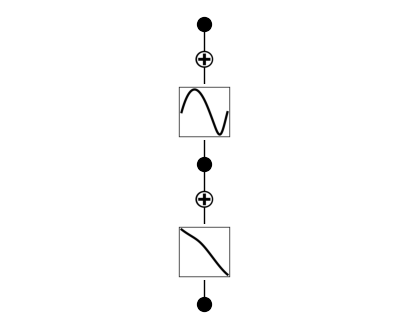

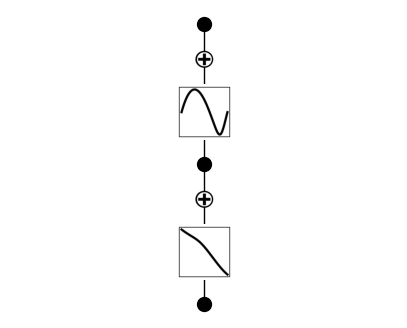

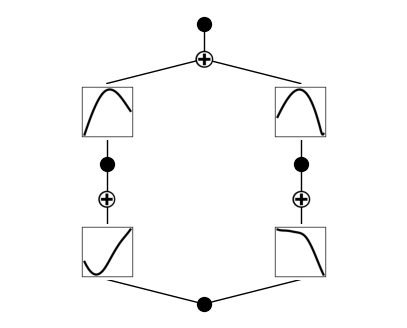

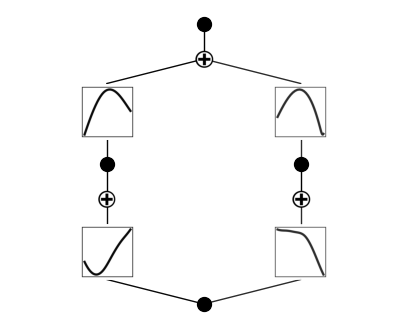

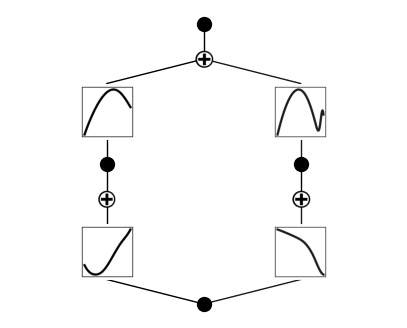

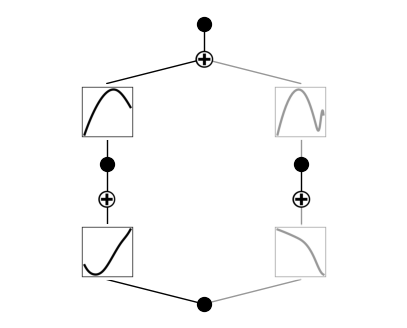

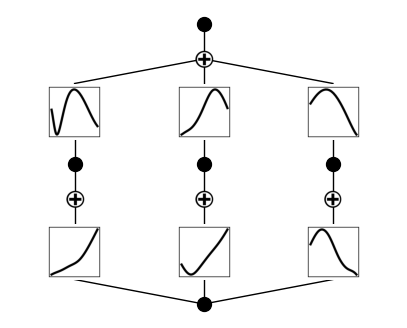

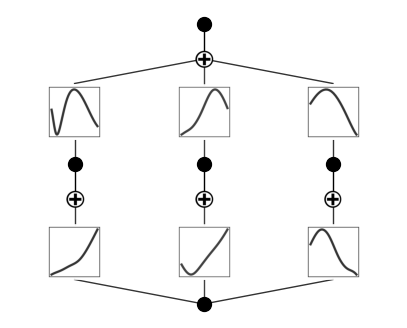

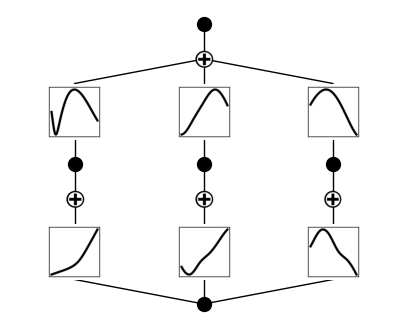

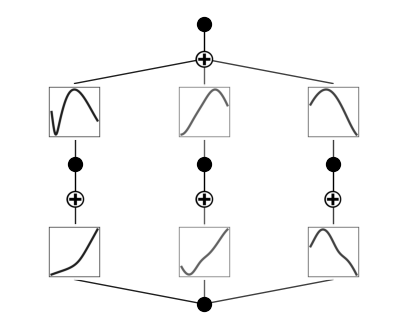

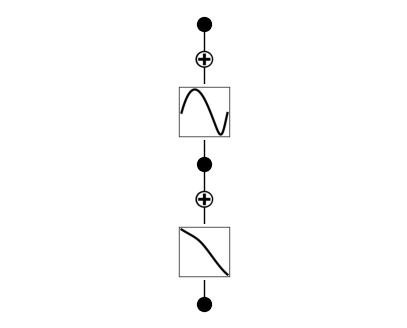

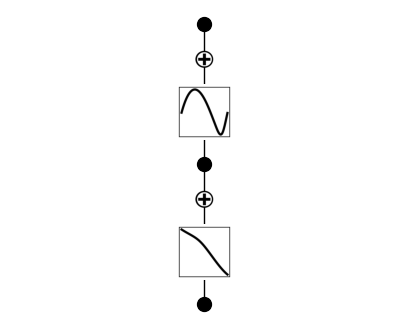

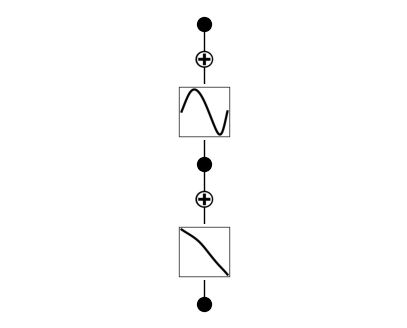

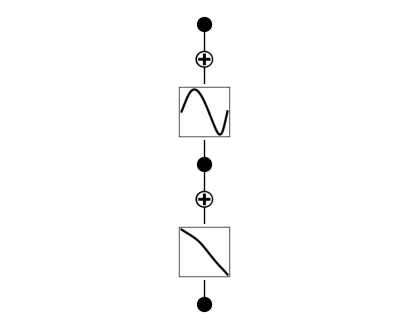

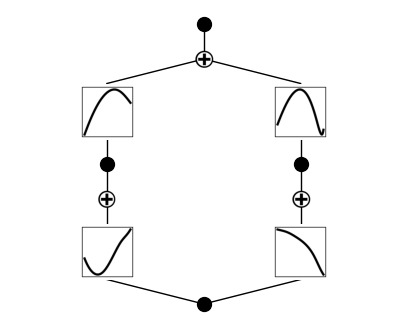

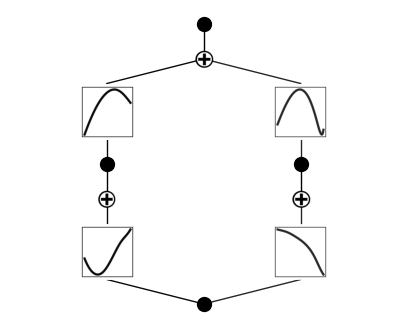

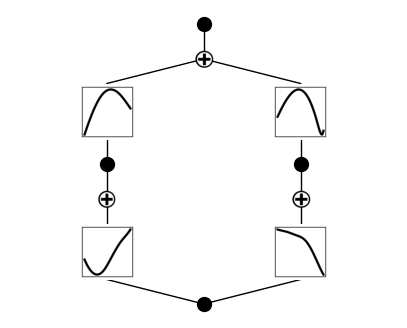

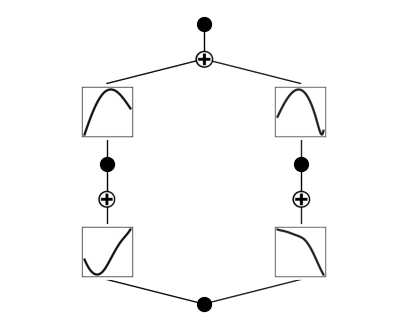

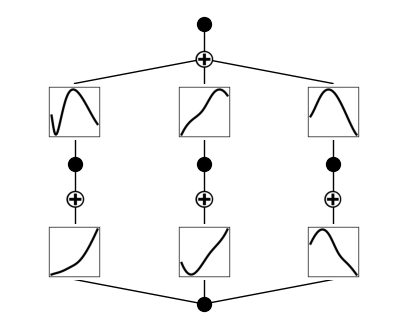

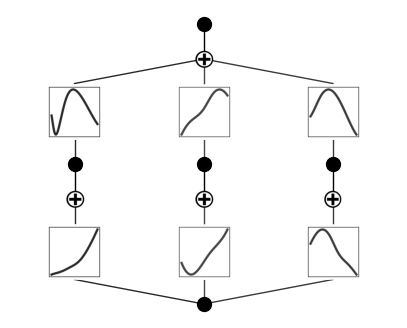

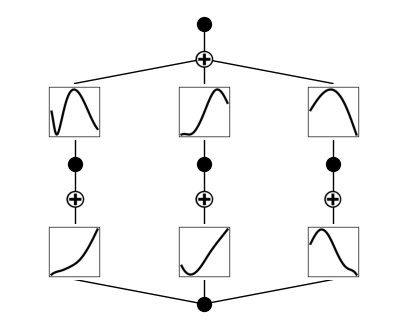

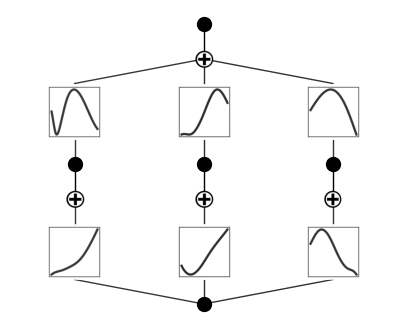

In [ ]:

import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []

# Hyperparameters
dim = 1
np_i = 51
np_b = 2
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
grids = [5, 10, 20]
steps = 50

# Define functions
sol_fun = lambda x: torch.sin(torch.pi * x)  # Analytical solution
source_fun = lambda x: -(torch.pi**2) * torch.sin(torch.pi * x)  # Source term
def compute_second_derivative(func, x):
    x.requires_grad_(True)
    y = func(x)  # Shape: [batch_size, 1]
    grad1 = autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]  # First derivative
    grad2 = autograd.grad(grad1, x, grad_outputs=torch.ones_like(grad1), create_graph=True)[0]  # Second derivative
    return grad2

x_i = torch.linspace(ranges[0], ranges[1], steps=np_i).unsqueeze(-1).to(device)
x_b = torch.tensor([[ranges[0]], [ranges[1]]], dtype=torch.float32).to(device)

def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)  # Analytical solution
            lap = compute_second_derivative(model, x_i)  # Compute second derivative
            source = source_fun(x_i)  # True source term
            pde_loss = torch.mean((lap - source)**2)  # PDE loss: match Laplacian to source

            # Boundary loss
            bc_true = sol_fun(x_b)  # True solution at boundaries
            bc_pred = model(x_b)   # Predicted solution at boundaries
            bc_loss = torch.mean((bc_pred - bc_true)**2)  # Boundary condition loss

            loss = alpha * pde_loss + bc_loss  # Total loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)  # L2 loss: model vs analytical solution

        if step % log_interval == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " %
                                 (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses



# Define hyperparameter ranges
alphas = [0.01, 0.1]
learning_rates = [0.1, 1.0]
grids = [5, 10, 20]
hidden_layers_list = [[1,1,1],[1, 2, 1],[1, 3, 1]]
steps_list = [50, 100]

pde_losses, bc_losses, l2_losses = [], [], []
log = 1

# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):
    pde_losses, bc_losses, l2_losses = [], [], []
    for grid in grids:
        if grid == grids[0]:
            model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
            models.append(model)
            parameters_to_print.append([alpha, learning_rate, hidden_layers, steps])
            model = model.speed()
        else:
            model.save_act = True
            model.get_act(x_i)
            model = model.refine(grid)
            model = model.speed()

        # Train model
        pde_losses, bc_losses, l2_losses = train_model(model, x_i, x_b, steps, alpha, log_interval)
        # Store results

    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        'Final PDE Loss': pde_losses[-1],
        'Final BC Loss': bc_losses[-1],
        'Final L2 Loss': l2_losses[-1]
    })

    plt.plot(pde_losses, marker='o', label='PDE Loss')
    plt.plot(bc_losses, marker='o', label='BC Loss')
    plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    plt.grid(True)
    plt.show()


# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save results to CSV and print
results_df.to_csv('kan_hyperparameter_results_1d.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))

for i in range(len(models)):
    print("Visualize model = ", parameters_to_print[i])
    models[i].plot(beta=10)
    models[i].plot()



Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 5.24e-04 | bc loss: 2.87e-10 | l2: 9.06e-07 : 100%|███████| 50/50 [00:28<00:00,  1.73it/s]
pde loss: 1.36e-04 | bc loss: 2.17e-10 | l2: 9.99e-07 : 100%|███████| 50/50 [00:25<00:00,  1.98it/s]
pde loss: 3.65e-05 | bc loss: 1.76e-09 | l2: 1.01e-06 : 100%|███████| 50/50 [00:11<00:00,  4.50it/s]


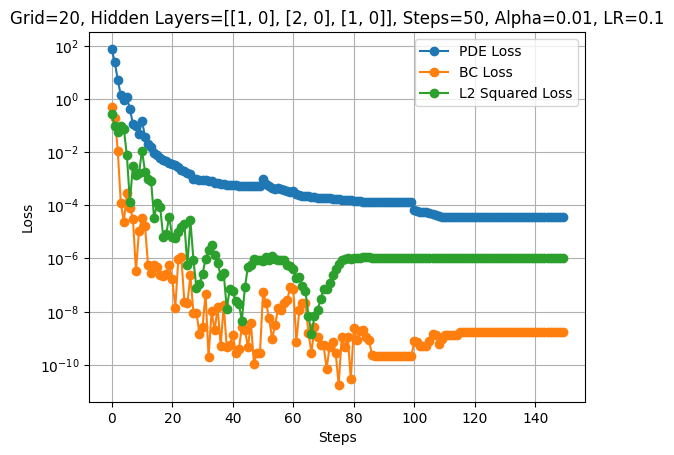

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.26e+01 | bc loss: 6.83e-06 | l2: 3.05e-02 : 100%|█████| 100/100 [00:24<00:00,  4.07it/s]
pde loss: 9.45e-03 | bc loss: 5.35e-07 | l2: 2.76e-04 : 100%|█████| 100/100 [00:25<00:00,  3.94it/s]
pde loss: 4.77e-03 | bc loss: 7.64e-07 | l2: 2.33e-04 : 100%|█████| 100/100 [00:21<00:00,  4.68it/s]


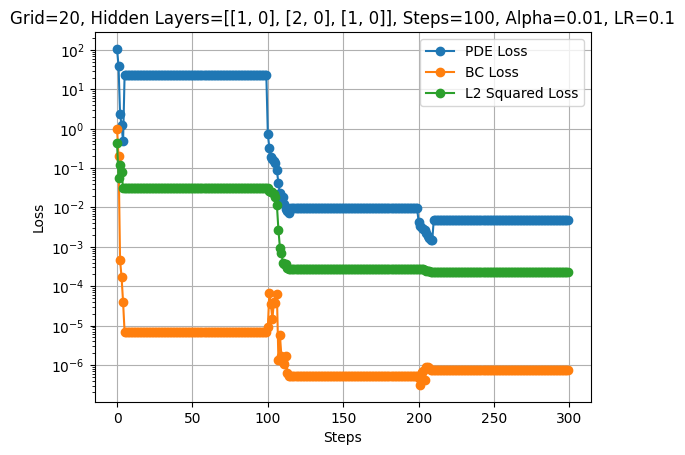

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.08e-01 | bc loss: 1.36e-06 | l2: 1.35e-05 : 100%|███████| 50/50 [00:13<00:00,  3.80it/s]
pde loss: 5.12e-02 | bc loss: 5.38e-05 | l2: 2.24e-05 : 100%|███████| 50/50 [00:11<00:00,  4.23it/s]
pde loss: 2.11e-03 | bc loss: 3.52e-06 | l2: 1.90e-05 : 100%|███████| 50/50 [00:10<00:00,  4.83it/s]


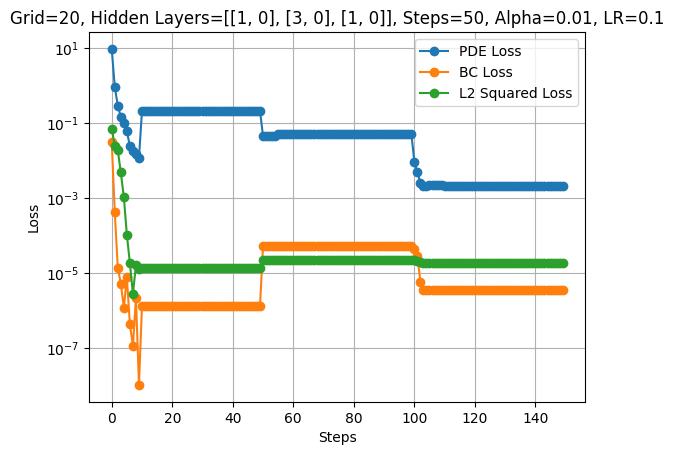

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.89e-04 | bc loss: 1.36e-09 | l2: 2.18e-07 : 100%|█████| 100/100 [00:57<00:00,  1.73it/s]
pde loss: 2.28e-03 | bc loss: 6.79e-09 | l2: 2.25e-06 : 100%|█████| 100/100 [00:20<00:00,  4.89it/s]
pde loss: 1.04e-04 | bc loss: 1.42e-08 | l2: 2.42e-06 : 100%|█████| 100/100 [00:23<00:00,  4.19it/s]


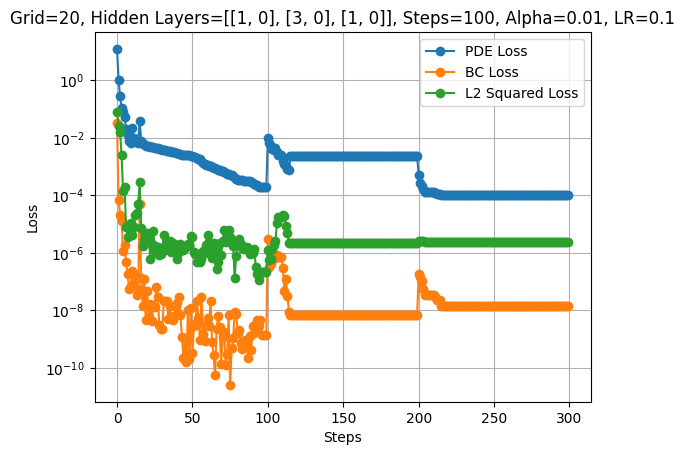

checkpoint directory created: ./model
saving model version 0.0


pde loss: 8.34e-03 | bc loss: 2.87e-07 | l2: 7.20e-05 : 100%|███████| 50/50 [00:14<00:00,  3.41it/s]
pde loss: 1.70e-03 | bc loss: 2.49e-08 | l2: 7.09e-05 : 100%|███████| 50/50 [00:10<00:00,  4.61it/s]
pde loss: 6.88e-04 | bc loss: 6.71e-08 | l2: 7.07e-05 : 100%|███████| 50/50 [00:07<00:00,  6.66it/s]


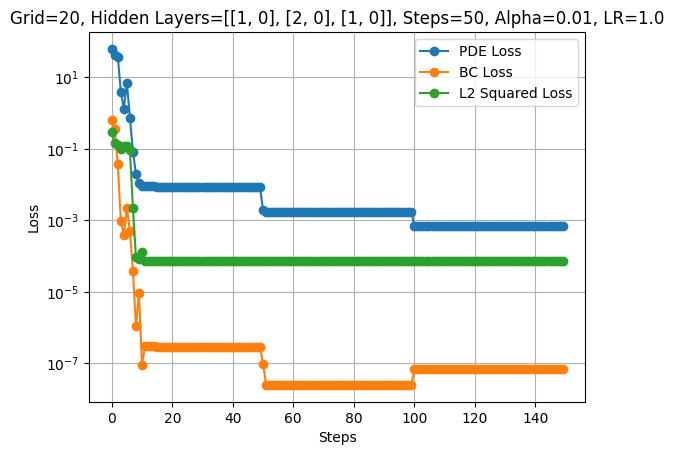

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.89e+00 | bc loss: 9.37e-05 | l2: 1.63e-02 : 100%|█████| 100/100 [00:29<00:00,  3.41it/s]
pde loss: 4.20e-01 | bc loss: 7.90e-05 | l2: 1.49e-02 : 100%|█████| 100/100 [00:20<00:00,  4.89it/s]
pde loss: 1.75e-01 | bc loss: 7.65e-05 | l2: 1.50e-02 : 100%|█████| 100/100 [00:18<00:00,  5.55it/s]


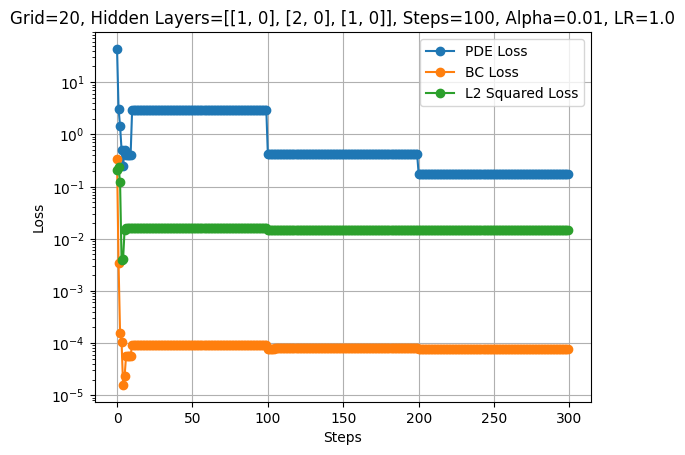

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.37e-03 | bc loss: 3.28e-08 | l2: 2.56e-06 : 100%|███████| 50/50 [00:31<00:00,  1.60it/s]
pde loss: 1.93e-04 | bc loss: 3.77e-09 | l2: 5.36e-06 : 100%|███████| 50/50 [00:27<00:00,  1.84it/s]
pde loss: 5.78e-04 | bc loss: 1.32e-08 | l2: 6.20e-06 : 100%|███████| 50/50 [00:13<00:00,  3.75it/s]


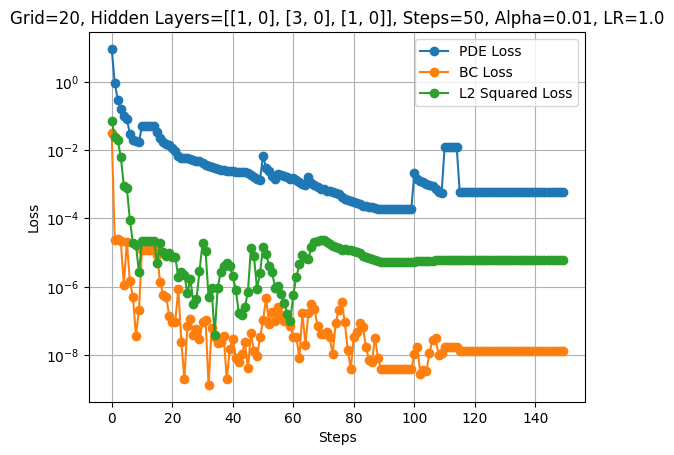

checkpoint directory created: ./model
saving model version 0.0


pde loss: 5.94e-04 | bc loss: 3.29e-11 | l2: 5.27e-07 : 100%|█████| 100/100 [01:05<00:00,  1.54it/s]
pde loss: 8.86e-05 | bc loss: 8.17e-10 | l2: 3.75e-06 : 100%|█████| 100/100 [00:40<00:00,  2.46it/s]
pde loss: 2.06e-04 | bc loss: 5.00e-08 | l2: 3.17e-06 : 100%|█████| 100/100 [00:29<00:00,  3.39it/s]


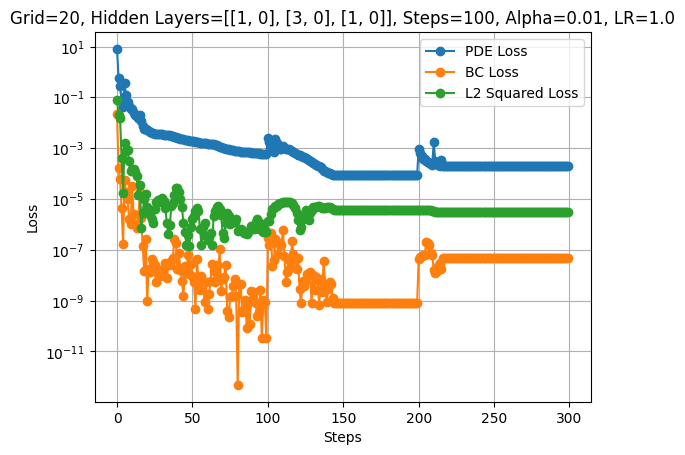

checkpoint directory created: ./model
saving model version 0.0


pde loss: 4.91e-02 | bc loss: 6.67e-05 | l2: 1.84e-04 : 100%|███████| 50/50 [00:21<00:00,  2.35it/s]
pde loss: 1.66e-03 | bc loss: 1.73e-06 | l2: 7.78e-07 : 100%|███████| 50/50 [00:15<00:00,  3.22it/s]
pde loss: 1.80e-04 | bc loss: 2.41e-08 | l2: 7.62e-08 : 100%|███████| 50/50 [00:11<00:00,  4.21it/s]


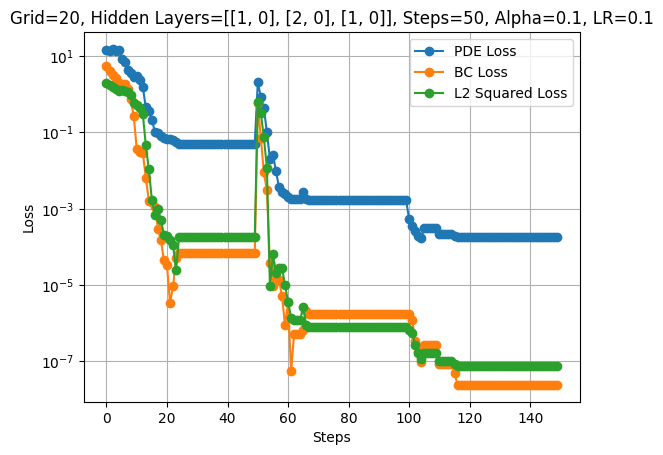

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.23e-02 | bc loss: 4.69e-06 | l2: 1.12e-04 : 100%|█████| 100/100 [00:51<00:00,  1.94it/s]
pde loss: 1.80e-04 | bc loss: 2.73e-07 | l2: 5.09e-06 : 100%|█████| 100/100 [00:30<00:00,  3.25it/s]
pde loss: 9.40e-05 | bc loss: 8.82e-07 | l2: 1.23e-05 : 100%|█████| 100/100 [00:15<00:00,  6.60it/s]


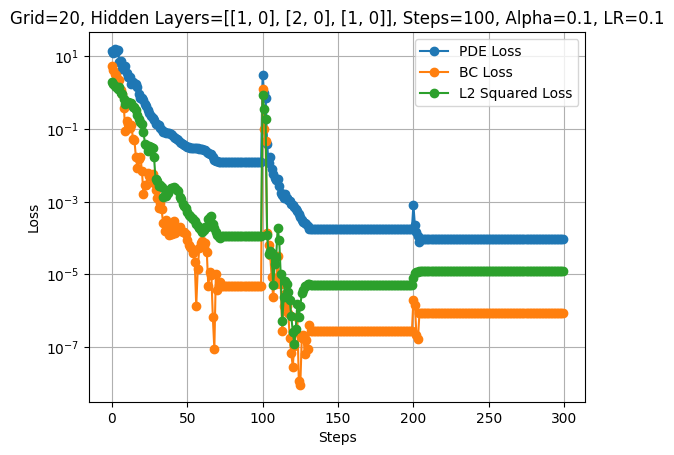

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.08e-03 | bc loss: 8.03e-10 | l2: 7.23e-08 : 100%|███████| 50/50 [00:30<00:00,  1.63it/s]
pde loss: 1.73e-04 | bc loss: 3.75e-08 | l2: 4.87e-07 : 100%|███████| 50/50 [00:30<00:00,  1.63it/s]
pde loss: 5.35e-05 | bc loss: 9.98e-08 | l2: 6.74e-07 : 100%|███████| 50/50 [00:19<00:00,  2.60it/s]


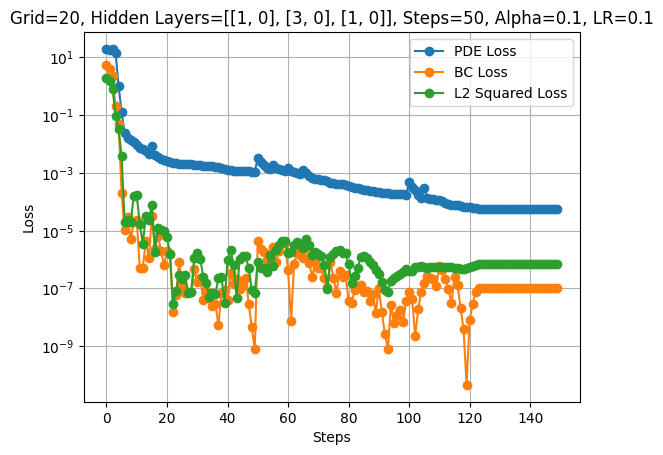

checkpoint directory created: ./model
saving model version 0.0


pde loss: 9.11e-04 | bc loss: 1.07e-06 | l2: 9.87e-07 : 100%|█████| 100/100 [00:39<00:00,  2.55it/s]
pde loss: 4.18e-04 | bc loss: 7.28e-07 | l2: 4.29e-07 : 100%|█████| 100/100 [00:24<00:00,  4.02it/s]
pde loss: 3.96e-05 | bc loss: 1.53e-08 | l2: 5.65e-08 : 100%|█████| 100/100 [00:20<00:00,  4.97it/s]


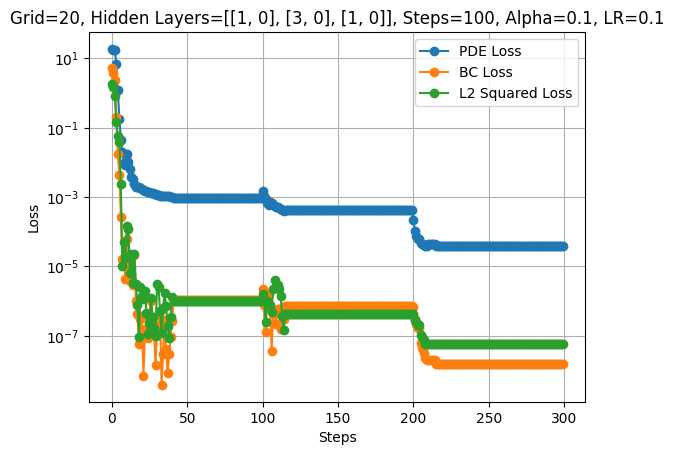

checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.01e-02 | bc loss: 3.43e-07 | l2: 4.22e-06 : 100%|███████| 50/50 [00:32<00:00,  1.54it/s]
pde loss: 1.51e-02 | bc loss: 1.56e-05 | l2: 2.13e-04 : 100%|███████| 50/50 [00:20<00:00,  2.38it/s]
pde loss: 6.50e-03 | bc loss: 3.48e-05 | l2: 2.62e-04 : 100%|███████| 50/50 [00:14<00:00,  3.50it/s]


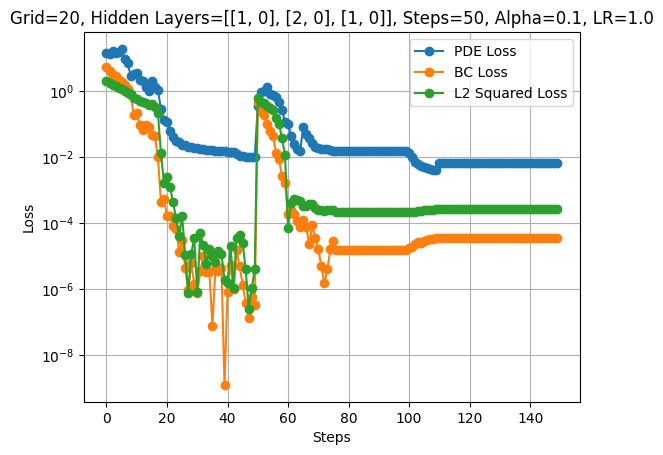

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.60e-03 | bc loss: 1.38e-07 | l2: 8.21e-07 : 100%|█████| 100/100 [00:49<00:00,  2.01it/s]
pde loss: 1.54e-02 | bc loss: 1.03e-04 | l2: 1.01e-01 : 100%|█████| 100/100 [00:34<00:00,  2.89it/s]
pde loss: 1.22e+00 | bc loss: 1.61e-03 | l2: 1.15e-01 : 100%|█████| 100/100 [00:18<00:00,  5.49it/s]


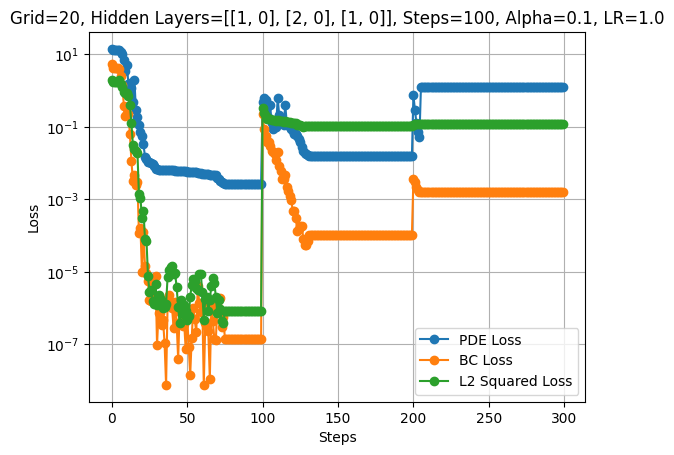

checkpoint directory created: ./model
saving model version 0.0


pde loss: 8.38e+00 | bc loss: 2.35e-03 | l2: 6.97e-03 : 100%|███████| 50/50 [00:18<00:00,  2.73it/s]
pde loss: 3.47e-04 | bc loss: 1.70e-07 | l2: 1.51e-06 : 100%|███████| 50/50 [00:29<00:00,  1.70it/s]
pde loss: 1.43e-04 | bc loss: 6.39e-07 | l2: 2.02e-06 : 100%|███████| 50/50 [00:19<00:00,  2.58it/s]


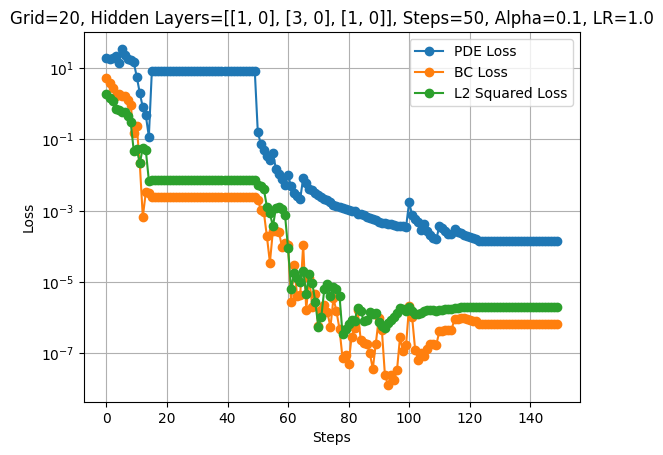

checkpoint directory created: ./model
saving model version 0.0


pde loss: 9.50e-04 | bc loss: 2.18e-08 | l2: 2.56e-07 : 100%|█████| 100/100 [00:36<00:00,  2.75it/s]
pde loss: 2.08e-04 | bc loss: 2.69e-07 | l2: 1.86e-06 : 100%|█████| 100/100 [00:34<00:00,  2.89it/s]
pde loss: 7.44e-04 | bc loss: 7.39e-08 | l2: 9.32e-07 : 100%|█████| 100/100 [00:21<00:00,  4.56it/s]


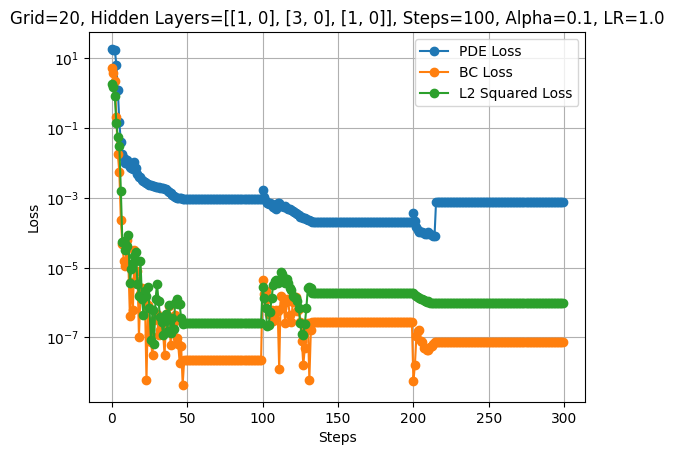

    Alpha  Learning Rate  Grid             Hidden Layers  Steps  \
0    0.01            0.1    20  [[1, 0], [2, 0], [1, 0]]     50   
1    0.01            0.1    20  [[1, 0], [2, 0], [1, 0]]    100   
2    0.01            0.1    20  [[1, 0], [3, 0], [1, 0]]     50   
3    0.01            0.1    20  [[1, 0], [3, 0], [1, 0]]    100   
4    0.01            1.0    20  [[1, 0], [2, 0], [1, 0]]     50   
5    0.01            1.0    20  [[1, 0], [2, 0], [1, 0]]    100   
6    0.01            1.0    20  [[1, 0], [3, 0], [1, 0]]     50   
7    0.01            1.0    20  [[1, 0], [3, 0], [1, 0]]    100   
8    0.10            0.1    20  [[1, 0], [2, 0], [1, 0]]     50   
9    0.10            0.1    20  [[1, 0], [2, 0], [1, 0]]    100   
10   0.10            0.1    20  [[1, 0], [3, 0], [1, 0]]     50   
11   0.10            0.1    20  [[1, 0], [3, 0], [1, 0]]    100   
12   0.10            1.0    20  [[1, 0], [2, 0], [1, 0]]     50   
13   0.10            1.0    20  [[1, 0], [2, 0], [1, 0]]    10

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1081: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(w_large, w_large))
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:1158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0+z0)))


0
Visualize model =  [0.1, 0.1, [[1, 0], [3, 0], [1, 0]], 100]
0
Visualize model =  [0.1, 1.0, [[1, 0], [2, 0], [1, 0]], 50]
0
Visualize model =  [0.1, 1.0, [[1, 0], [2, 0], [1, 0]], 100]
0
Visualize model =  [0.1, 1.0, [[1, 0], [3, 0], [1, 0]], 50]
0
Visualize model =  [0.1, 1.0, [[1, 0], [3, 0], [1, 0]], 100]
0


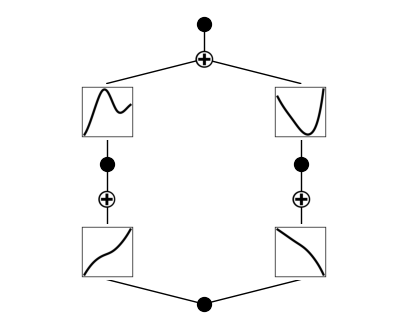

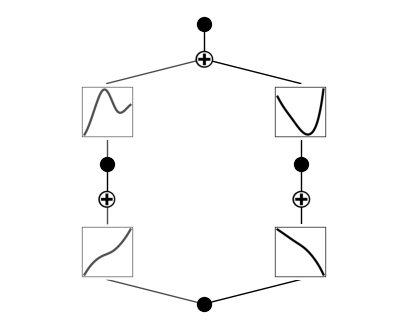

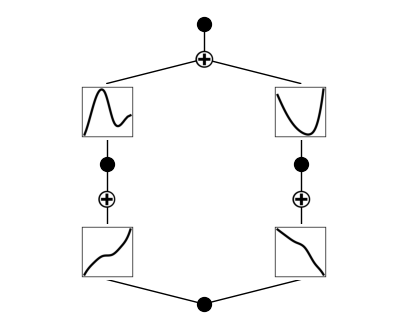

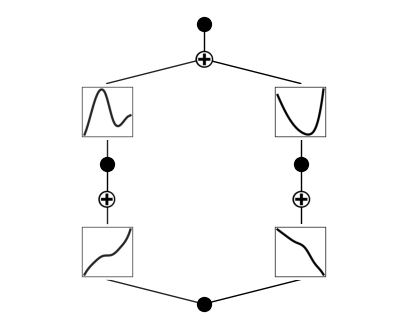

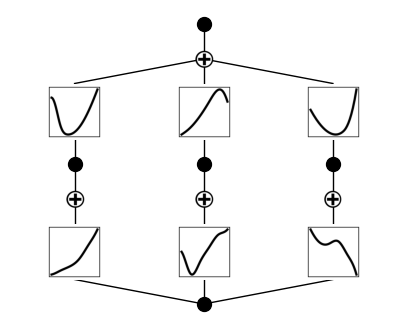

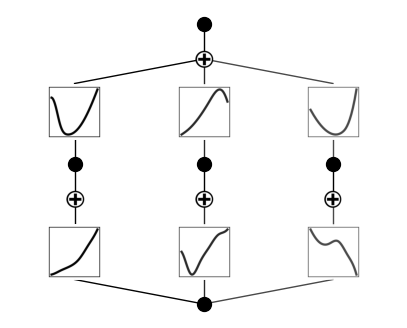

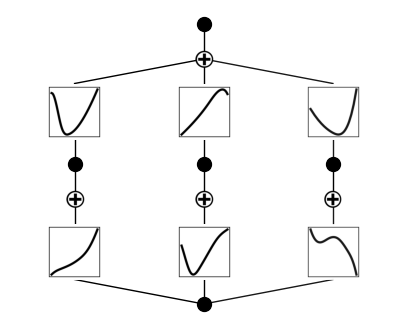

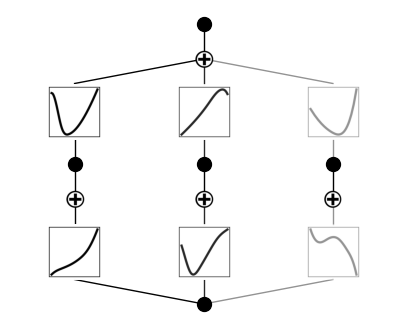

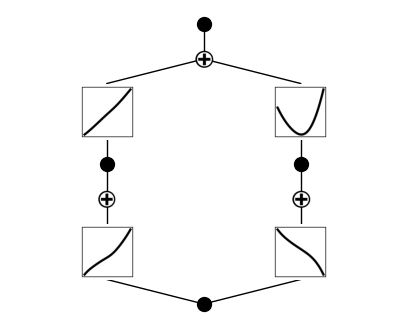

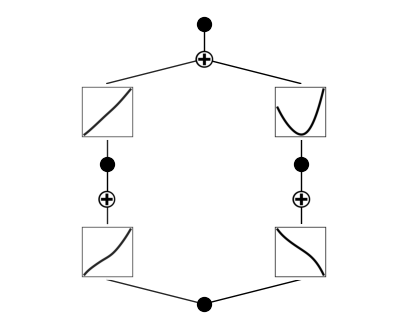

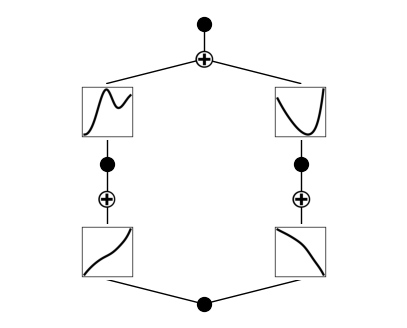

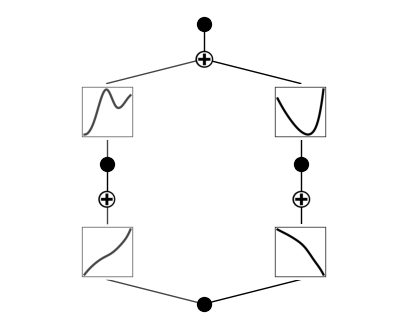

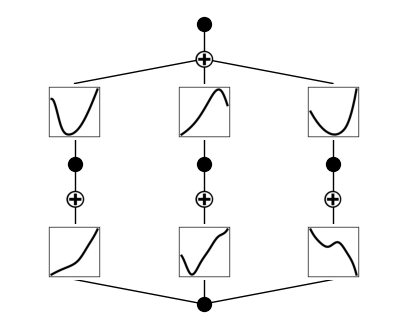

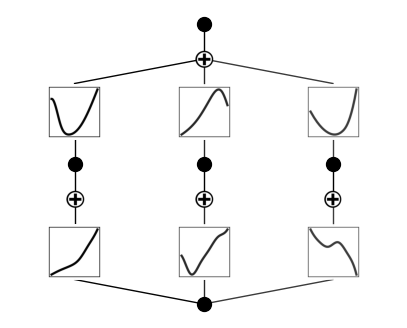

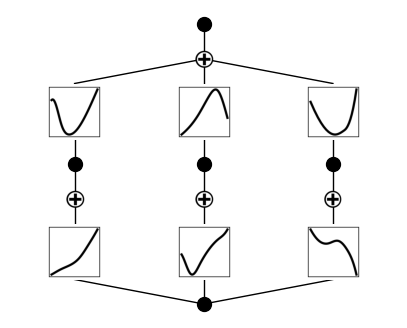

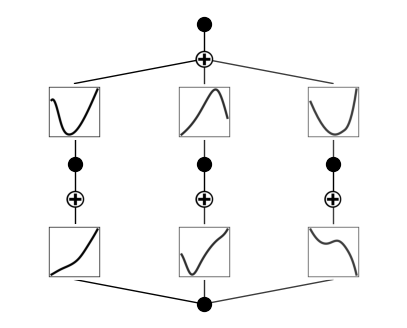

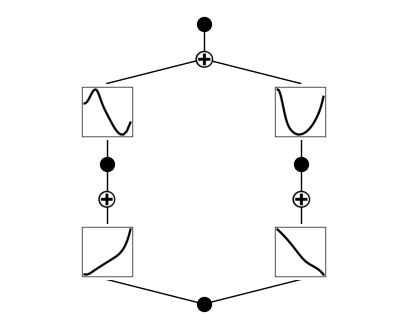

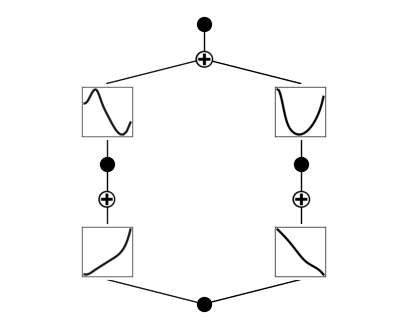

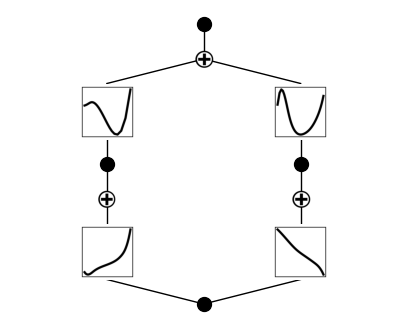

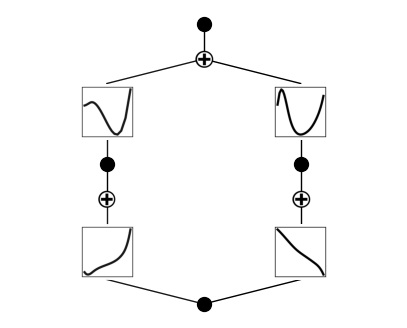

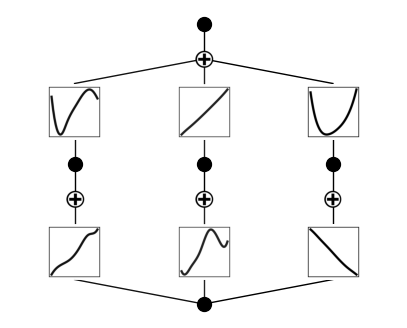

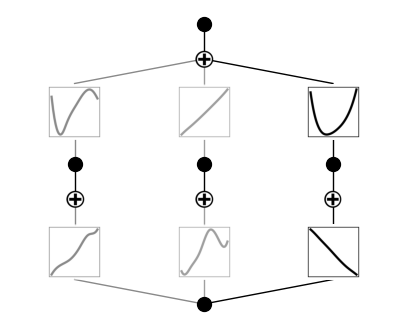

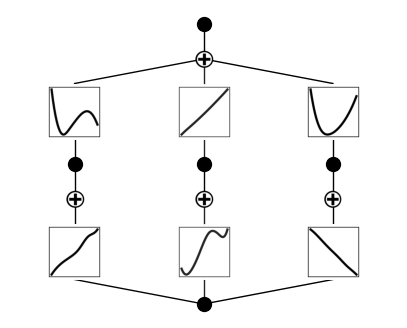

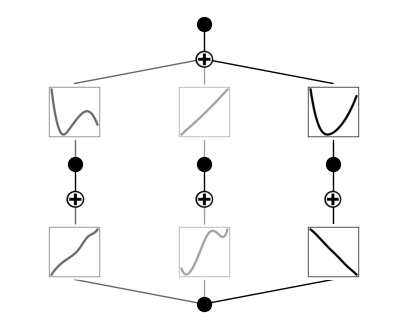

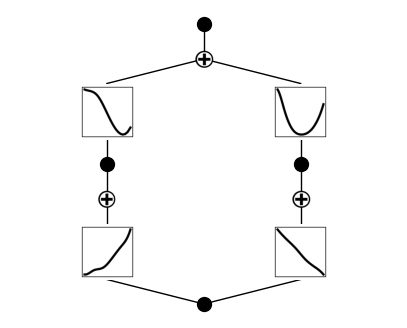

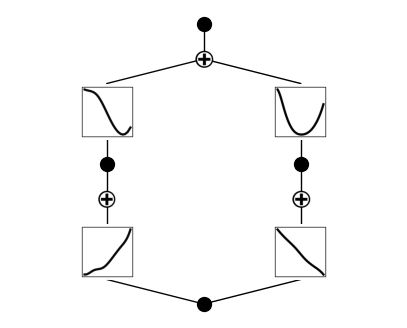

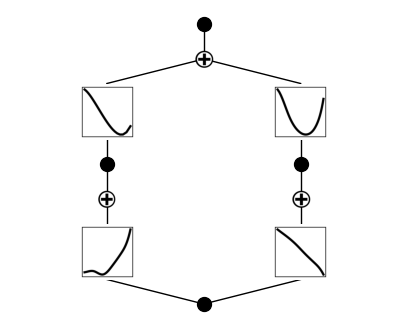

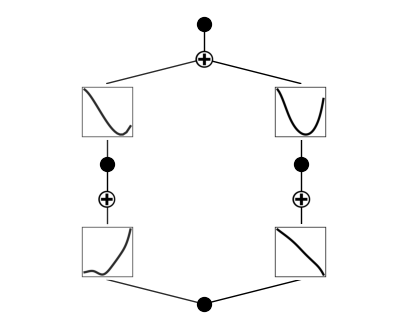

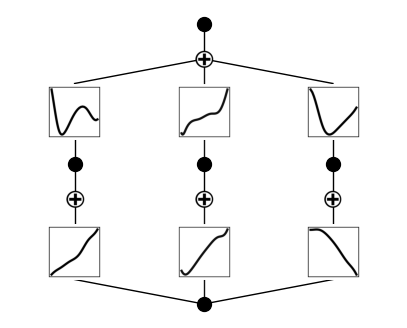

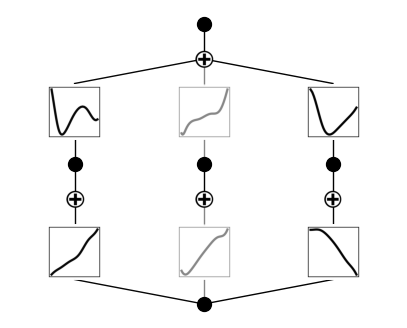

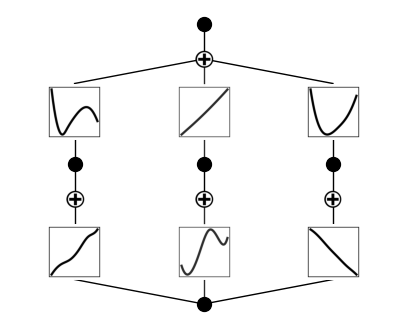

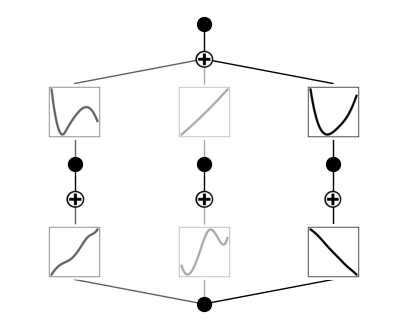

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools
from kan import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []


dim = 1
np_i = 51
np_b = 2
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
grids = [5, 10, 20]
steps = 50

# Define functions
sol_fun = lambda x: torch.exp(x**2)
source_fun = lambda x: 2*(2*x**2+1)*torch.exp(x**2)
def compute_second_derivative(func, x):
    x.requires_grad_(True)
    y = func(x)  # Shape: [batch_size, 1]
    grad1 = autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    grad2 = autograd.grad(grad1, x, grad_outputs=torch.ones_like(grad1), create_graph=True)[0]
    return grad2

x_i = torch.linspace(ranges[0], ranges[1], steps=np_i).unsqueeze(-1).to(device)
x_b = torch.tensor([[ranges[0]], [ranges[1]]], dtype=torch.float32).to(device)

def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)
            lap = compute_second_derivative(model, x_i)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # Boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)  # L2 loss: model vs analytical solution

        if step % log_interval == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " %
                                 (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses



alphas = [0.01, 0.1]
learning_rates = [0.1, 1.0]
grids = [5, 10, 20]
hidden_layers_list = [[1, 2, 1],[1, 3, 1]]
steps_list = [50, 100]


pde_losses, bc_losses, l2_losses = [], [], []
log = 1

# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):
    pde_losses, bc_losses, l2_losses = [], [], []
    for grid in grids:
        if grid == grids[0]:
            model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
            models.append(model)
            parameters_to_print.append([alpha, learning_rate, hidden_layers, steps])
            model = model.speed()
        else:
            model.save_act = True
            model.get_act(x_i)
            model = model.refine(grid)
            model = model.speed()

        pde_losses, bc_losses, l2_losses = train_model(model, x_i, x_b, steps, alpha, log_interval)

    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        'Final PDE Loss': pde_losses[-1],
        'Final BC Loss': bc_losses[-1],
        'Final L2 Loss': l2_losses[-1]
    })

    plt.plot(pde_losses, marker='o', label='PDE Loss')
    plt.plot(bc_losses, marker='o', label='BC Loss')
    plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    plt.grid(True)
    plt.show()


# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save results to CSV and print
results_df.to_csv('kan_hyperparameter_results_1d.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))

for i in range(len(models)):
    print("Visualize model = ", parameters_to_print[i])
    models[i].plot(beta=10)
    models[i].plot()
    formula = models[i].symbolic_formula()[0][0]
    ex_round(formula,6)
    print(formula)




In [ ]:
models[0].fix_symbolic(0,0,0,'x')
models[0].fix_symbolic(0,0,1,'x')
models[0].fix_symbolic(1,0,0,'x')
models[0].fix_symbolic(1,1,0,'x^2')
formula = models[0].symbolic_formula()[0][0]
ex_round(formula,6)

r2 is 0.971756637096405
r2 is 0.9988330602645874
Best value at boundary.
r2 is 0.9002374410629272
r2 is 0.9752529263496399


-0.078905*x_1 + 1.659775*(x_1 + 0.01584)**2 + 0.911382

Model Architecture:
MLP(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
Total number of trainable parameters: 2751

Epoch 0/10000, Loss: 9.9312e+01
Epoch 1000/10000, Loss: 6.3304e+01
Epoch 2000/10000, Loss: 7.3506e-01
Epoch 3000/10000, Loss: 1.3582e-01
Epoch 4000/10000, Loss: 5.8716e-02
Epoch 5000/10000, Loss: 3.2868e-02
Epoch 6000/10000, Loss: 2.3176e-02
Epoch 7000/10000, Loss: 1.6792e-02
Epoch 8000/10000, Loss: 1.1275e-02
Epoch 9000/10000, Loss: 1.2415e-02

Training complete in 155.24 seconds


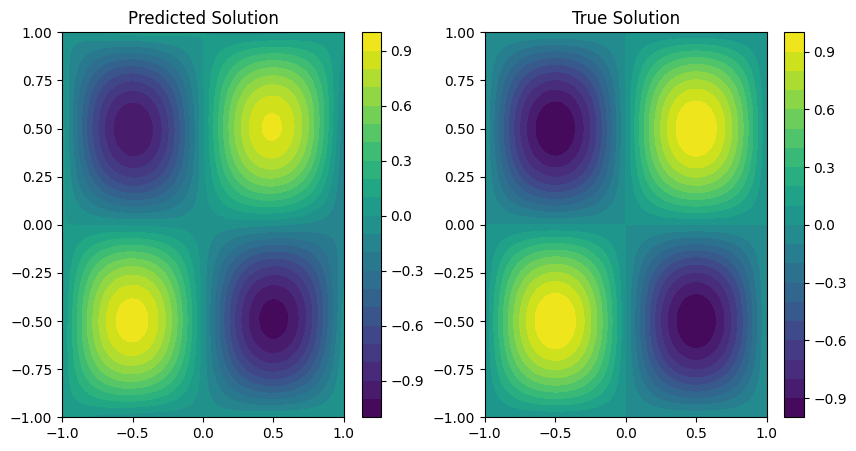

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        return self.fc3(x)


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print model details
print("Model Architecture:")
print(model)
print(f"Total number of trainable parameters: {count_params(model)}\n")

def true_solution(x, y):

    x = torch.tensor(x) if not isinstance(x, torch.Tensor) else x
    y = torch.tensor(y) if not isinstance(y, torch.Tensor) else y
    return torch.sin(np.pi * x) * torch.sin(np.pi * y)



def laplacian(model, x, y):
    x.requires_grad = True
    y.requires_grad = True
    u = model(torch.cat([x, y], dim=1))


    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    return u_xx + u_yy

input_dim = 2
hidden_dim = 50
output_dim = 1
learning_rate = 1e-4
epochs = 10000
batch_size = 1000

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, optimizer, and loss function
model = MLP(input_dim, hidden_dim, output_dim).to(device)  # Move model to the correct device
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()  # Start the timer
# Training loop
for epoch in range(epochs):
    # Randomly sample interior points (x, y) in the domain [-1, 1] x [-1, 1]
    x = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, 1))).to(device)
    y = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, 1))).to(device)

    # Compute the true solution (Ground truth)
    u_true = true_solution(x, y).to(device)


    lap = laplacian(model, x, y)

    pde_loss = torch.mean((lap + 2 * np.pi ** 2 * torch.sin(np.pi * x) * torch.sin(np.pi * y)) ** 2)

    # Sample boundary points: x = -1, x = 1, y = -1, y = 1
    x_bc = torch.cat([torch.full((batch_size // 4, 1), -1.0), torch.full((batch_size // 4, 1), 1.0),
                      torch.rand(batch_size // 2, 1) * 2 - 1], dim=0).to(device)
    y_bc = torch.cat([torch.rand(batch_size // 4, 1) * 2 - 1, torch.full((batch_size // 4, 1), -1.0),
                      torch.full((batch_size // 2, 1), 1.0)], dim=0).to(device)


    boundary_output = model(torch.cat([x_bc, y_bc], dim=1))
    bc_loss = torch.mean(boundary_output ** 2)

    # Total loss (PDE loss + boundary condition loss)
    loss = pde_loss + bc_loss

    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Print the progress
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4e}")
end_time = time.time()  # End the timer
training_time = end_time - start_time

# Print total training time
print(f"\nTraining complete in {training_time:.2f} seconds")

x_grid = np.linspace(-1, 1, 100)
y_grid = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)
X = torch.tensor(X).float().view(-1, 1).to(device)
Y = torch.tensor(Y).float().view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    Z_pred = model(torch.cat([X, Y], dim=1)).cpu().numpy().reshape(100, 100)

Z_true = true_solution(X.cpu().numpy(), Y.cpu().numpy()).reshape(100, 100)

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Predicted Solution")
plt.contourf(X.cpu().numpy().reshape(100, 100), Y.cpu().numpy().reshape(100, 100), Z_pred, 20, cmap="viridis")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("True Solution")
plt.contourf(X.cpu().numpy().reshape(100, 100), Y.cpu().numpy().reshape(100, 100), Z_true, 20, cmap="viridis")
plt.colorbar()

plt.show()




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from tabulate import tabulate


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):

        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        return self.fc3(x)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def laplacian(model, x, y):
    """
    Computes the Laplacian (∂²/∂x² + ∂²/∂y²) of the model's output.
    """
    x.requires_grad_(True)
    y.requires_grad_(True)


    u = model(torch.cat([x, y], dim=1))


    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]


    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    return u_xx + u_yy



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


input_dim = 2
output_dim = 1
epochs = 5000

learning_rates = [1e-3, 1e-4]
hidden_dims = [50, 100]
batch_sizes = [256, 512]
max_norms = [0.5, 1.0]
alphas = [0.01, 0.1]


best_loss = float('inf')
best_params = {}


results = []

for lr in learning_rates:
    for hidden in hidden_dims:
        for batch_size in batch_sizes:
            for max_norm in max_norms:
                for alpha in alphas:
                    print(f"Training with: LR={lr}, Hidden Dim={hidden}, Batch Size={batch_size}, Max Norm={max_norm}, alpha={alpha}")

                    # Initialize the model
                    model = MLP(input_dim, hidden, output_dim).to(device)
                    model_number_parameters = count_params(model)

                    print("Model Architecture:")
                    print(model)
                    print(f"Total number of trainable parameters: {model_number_parameters}\n")

                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    start_time = time.time()

                    # ---- Training Loop ----
                    for epoch in range(epochs):
                        # Sample interior points (x, y) in domain [-1, 1] x [-1, 1]
                        x = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, 1))).to(device)
                        y = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, 1))).to(device)


                        lap = laplacian(model, x, y)

                        rhs = (np.pi**2) * (torch.sin(np.pi * x) + torch.sin(np.pi * y))
                        pde_residual = lap + rhs
                        pde_loss = torch.mean(pde_residual**2)


                        x_bc = torch.cat([
                            torch.full((batch_size // 4, 1), -1.0),
                            torch.full((batch_size // 4, 1), 1.0),
                            torch.rand(batch_size // 2, 1) * 2 - 1
                        ], dim=0).to(device)

                        y_bc = torch.cat([
                            torch.rand(batch_size // 4, 1) * 2 - 1,
                            torch.full((batch_size // 4, 1), -1.0),
                            torch.full((batch_size // 2, 1), 1.0)
                        ], dim=0).to(device)

                        bc_output = model(torch.cat([x_bc, y_bc], dim=1))
                        bc_loss = torch.mean(bc_output**2)

                        # Total loss = alpha * PDE_loss + BC_loss
                        loss = alpha * pde_loss + bc_loss

                        optimizer.zero_grad()
                        loss.backward()


                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

                        optimizer.step()

                        if epoch % 1000 == 0:
                            print(f"Epoch {epoch}/{epochs}, PDE Loss: {pde_loss.item():.4e}, BC Loss: {bc_loss.item():.4e}, Total Loss: {loss.item():.4e}")

                    end_time = time.time()
                    training_time = end_time - start_time

                    # Store current experiment results
                    results.append({
                        'Learning Rate': lr,
                        'Hidden Dim': hidden,
                        'Batch Size': batch_size,
                        'Max Norm': max_norm,
                        'PDE Loss': pde_loss.item(),
                        'BC Loss': bc_loss.item(),
                        'Total Loss': loss.item(),
                        'Training Time': training_time,
                        'number_of_parameters': model_number_parameters,
                        'alpha': alpha
                    })

                    # Track best model
                    if loss.item() < best_loss:
                        best_loss = loss.item()
                        best_params = {
                            'learning_rate': lr,
                            'hidden_dim': hidden,
                            'batch_size': batch_size,
                            'max_norm': max_norm,
                            'alpha': alpha
                        }

# Print the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")

# Convert the results to a table
table_data = [
    [
        r['Learning Rate'],
        r['Hidden Dim'],
        r['Batch Size'],
        r['Max Norm'],
        r['PDE Loss'],
        r['BC Loss'],
        r['Total Loss'],
        r['Training Time'],
        r['number_of_parameters'],
        r['alpha']
    ]
    for r in results
]

headers = [
    'Learning Rate',
    'Hidden Dim',
    'Batch Size',
    'Max Norm',
    'PDE Loss',
    'BC Loss',
    'Total Loss',
    'Training Time',
    'number_of_parameters',
    'alpha'
]

print("\nGrid Search Results:")
print(tabulate(table_data, headers=headers, floatfmt=".4e"))


Using device: cuda
Training with: LR=0.001, Hidden Dim=50, Batch Size=256, Max Norm=0.5, alpha=0.01
Model Architecture:
MLP(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
Total number of trainable parameters: 2751



/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/5000, PDE Loss: 9.9166e+01, BC Loss: 7.0701e-02, Total Loss: 1.0624e+00
Epoch 1000/5000, PDE Loss: 2.2949e+00, BC Loss: 9.6631e-03, Total Loss: 3.2612e-02
Epoch 2000/5000, PDE Loss: 9.0177e-01, BC Loss: 3.8872e-03, Total Loss: 1.2905e-02
Epoch 3000/5000, PDE Loss: 3.5716e-01, BC Loss: 1.7093e-03, Total Loss: 5.2809e-03
Epoch 4000/5000, PDE Loss: 2.8095e-01, BC Loss: 1.3919e-03, Total Loss: 4.2015e-03
Training with: LR=0.001, Hidden Dim=50, Batch Size=256, Max Norm=0.5, alpha=0.1
Model Architecture:
MLP(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
Total number of trainable parameters: 2751

Epoch 0/5000, PDE Loss: 1.0011e+02, BC Loss: 1.0528e-01, Total Loss: 1.0117e+01
Epoch 1000/5000, PDE Loss: 3.2152e-01, BC Loss: 3.1510e-02, Total Loss: 6.3661e-02
Epoch 2000/5000, PDE Loss: 1.7818e-01, BC Loss: 1.1195e-02, Total Loss: 2.9013e-02
Epoch 3000/50

Using device: cuda
Model Architecture:
MLP1D(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
Total number of trainable parameters: 2701
Epoch 0/5000, PDE Loss: 5.0269e+01, BC Loss: 1.0365e-01, Total Loss: 6.0635e-01
Epoch 1000/5000, PDE Loss: 5.1074e-02, BC Loss: 9.9780e-08, Total Loss: 5.1084e-04
Epoch 2000/5000, PDE Loss: 2.2735e-02, BC Loss: 4.2635e-07, Total Loss: 2.2777e-04
Epoch 3000/5000, PDE Loss: 1.6520e-02, BC Loss: 3.4273e-06, Total Loss: 1.6863e-04
Epoch 4000/5000, PDE Loss: 1.2522e-02, BC Loss: 4.5313e-05, Total Loss: 1.7053e-04

Training finished in 22.57 seconds.


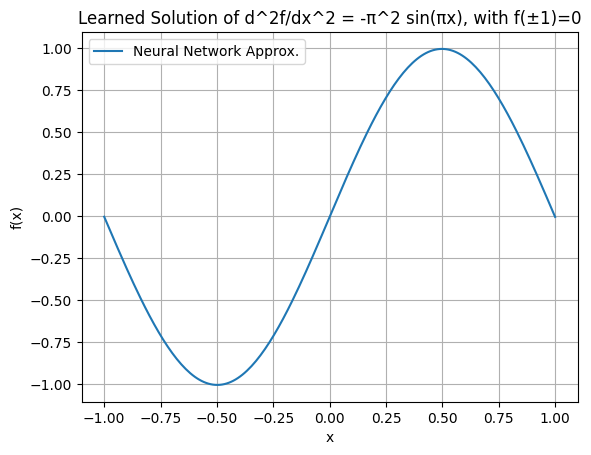

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import time


class MLP1D(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1):
        super(MLP1D, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)


        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):

        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        return self.fc3(x)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def second_derivative(model, x):
    """
    Computes the second derivative d^2f/dx^2 of the model's output f(x).
    """
    # Enable gradient tracking
    x.requires_grad_(True)

    # Forward pass
    f = model(x)

    # First derivative df/dx
    df_dx = torch.autograd.grad(
        f, x,
        grad_outputs=torch.ones_like(f),
        create_graph=True
    )[0]

    # Second derivative d^2f/dx^2
    d2f_dx2 = torch.autograd.grad(
        df_dx, x,
        grad_outputs=torch.ones_like(df_dx),
        create_graph=True
    )[0]

    return d2f_dx2

# ---- 3) Training Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
learning_rate = 1e-3
hidden_dim = 50
epochs = 5000
batch_size = 256

# Create the model
model = MLP1D(input_dim=1, hidden_dim=hidden_dim, output_dim=1).to(device)
print("Model Architecture:")
print(model)
print(f"Total number of trainable parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
max_norm = 1.0  # for gradient clipping
alpha = 0.01    # weight on PDE vs. boundary condition loss

# ---- 4) Training Loop ----
start_time = time.time()

for epoch in range(epochs):

    x_interior = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, 1))).to(device)


    d2f_dx2 = second_derivative(model, x_interior)

    rhs = (np.pi**2) * torch.sin(np.pi * x_interior)
    pde_residual = d2f_dx2 + rhs
    pde_loss = torch.mean(pde_residual**2)

    x_bc_left  = torch.full((batch_size // 2, 1), -1.0).to(device)
    x_bc_right = torch.full((batch_size // 2, 1),  1.0).to(device)
    x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)

    f_bc = model(x_bc)
    bc_loss = torch.mean(f_bc**2)  # enforce f(x_bc)=0

    # Total loss
    loss = alpha * pde_loss + bc_loss


    optimizer.zero_grad()
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs}, PDE Loss: {pde_loss.item():.4e}, BC Loss: {bc_loss.item():.4e}, Total Loss: {loss.item():.4e}")

end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining finished in {training_time:.2f} seconds.")


x_test = np.linspace(-1, 1, 200)
x_test_torch = torch.FloatTensor(x_test).unsqueeze(-1).to(device)

f_pred = model(x_test_torch).detach().cpu().numpy().flatten()


plt.figure()
plt.plot(x_test, f_pred, label='Neural Network Approx.')
plt.title('Learned Solution of d^2f/dx^2 = -π^2 sin(πx), with f(±1)=0')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        return self.fc3(x)


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print model details
print("Model Architecture:")
print(model)
print(f"Total number of trainable parameters: {count_params(model)}\n")

def true_solution(x, y):

    x = torch.tensor(x) if not isinstance(x, torch.Tensor) else x
    y = torch.tensor(y) if not isinstance(y, torch.Tensor) else y
    return torch.sin(np.pi * x) * torch.sin(np.pi * y)


# Laplacian of the function
def laplacian(model, x, y):
    x.requires_grad = True
    y.requires_grad = True
    u = model(torch.cat([x, y], dim=1))
    # Compute gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]


    return u_xx + u_yy
from tabulate import tabulate
import time


learning_rates = [1e-3, 1e-4]
hidden_dims = [50, 100]
batch_sizes = [256, 512]
max_norms = [0.5, 1.0]
alphas = [0.01,0.1]


best_loss = float('inf')
best_params = {}


results = []


for lr in learning_rates:
    for hidden in hidden_dims:
        for batch_size in batch_sizes:
            for max_norm in max_norms:
                for alpha in alphas:
                    print(f"Training with: LR={lr}, Hidden Dim={hidden}, Batch Size={batch_size}, Max Norm={max_norm}")


                    model = MLP(input_dim, hidden, output_dim).to(device)

                        # Print model details
                    print("Model Architecture:")
                    print(model)
                    model_number_parameters = count_params(model)
                    print(f"Total number of trainable parameters: {model_number_parameters}\n")
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    start_time = time.time()  # Start the timer

                    # Training loop
                    for epoch in range(epochs):

                        x = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, 1))).to(device)  # Move data to the correct device
                        y = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, 1))).to(device)  # Move data to the correct device


                        u_true = true_solution(x, y).to(device)


                        lap = laplacian(model, x, y)


                        pde_loss = torch.mean((lap + 2 * np.pi ** 2 * torch.sin(np.pi * x) * torch.sin(np.pi * y)) ** 2)


                        x_bc = torch.cat([torch.full((batch_size // 4, 1), -1.0), torch.full((batch_size // 4, 1), 1.0),
                                          torch.rand(batch_size // 2, 1) * 2 - 1], dim=0).to(device)
                        y_bc = torch.cat([torch.rand(batch_size // 4, 1) * 2 - 1, torch.full((batch_size // 4, 1), -1.0),
                                          torch.full((batch_size // 2, 1), 1.0)], dim=0).to(device)


                        boundary_output = model(torch.cat([x_bc, y_bc], dim=1))
                        bc_loss = torch.mean(boundary_output ** 2)  # Enforce that the boundary output is zero

                        # Total loss (PDE loss + boundary condition loss)
                        loss = alpha * pde_loss + bc_loss


                        optimizer.zero_grad()
                        loss.backward()


                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

                        optimizer.step()

                        if epoch % 1000 == 0:
                            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4e}")

                    # End the timer after training
                    end_time = time.time()
                    training_time = end_time - start_time

                    # Store the results
                    results.append({
                        'Learning Rate': lr,
                        'Hidden Dim': hidden,
                        'Batch Size': batch_size,
                        'Max Norm': max_norm,
                        'PDE Loss': pde_loss.item(),
                        'BC Loss': bc_loss.item(),
                        'Total Loss': loss.item(),
                        'Training Time': training_time,
                        'number_of_parameters': model_number_parameters,
                        'alpha': alpha
                    })

                    # Compare and store best model's parameters
                    if loss.item() < best_loss:
                        best_loss = loss.item()
                        best_params = {
                            'learning_rate': lr,
                            'hidden_dim': hidden,
                            'batch_size': batch_size,
                            'max_norm': max_norm
                        }

# Print the best hyperparameters found
print(f"\nBest Hyperparameters: {best_params}")

# Convert the results to a list of lists for tabulate
table_data = [
    [r['Learning Rate'], r['Hidden Dim'], r['Batch Size'], r['Max Norm'], r['PDE Loss'], r['BC Loss'], r['Total Loss'], r['Training Time'],r['number_of_parameters'],r['alpha']]
    for r in results
]

# Define the headers for the table
headers = ['Learning Rate', 'Hidden Dim', 'Batch Size', 'Max Norm', 'PDE Loss', 'BC Loss', 'Total Loss', 'Training Time','number_of_parameters','alpha']

# Print the table
print("\nGrid Search Results:")
print(tabulate(table_data, headers=headers, floatfmt=".4e"))



Model Architecture:
MLP(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
Total number of trainable parameters: 2751

Training with: LR=0.001, Hidden Dim=50, Batch Size=256, Max Norm=0.5
Model Architecture:
MLP(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
Total number of trainable parameters: 2751

Epoch 0/10000, Loss: 1.3780e+00
Epoch 1000/10000, Loss: 5.8151e-03
Epoch 2000/10000, Loss: 2.1040e-03
Epoch 3000/10000, Loss: 1.0701e-03
Epoch 4000/10000, Loss: 7.4583e-04
Epoch 5000/10000, Loss: 4.9854e-04
Epoch 6000/10000, Loss: 4.0076e-04
Epoch 7000/10000, Loss: 3.3208e-04
Epoch 8000/10000, Loss: 2.4009e-04
Epoch 9000/10000, Loss: 1.4739e-04
Training with: LR=0.001, Hidden Dim=50, Batch Size=256, Max Norm=0.5
Model Architectur

Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 7.59e-01 | bc loss: 1.24e-03 | l2: 7.02e-04 : 100%|███████| 50/50 [02:53<00:00,  3.47s/it]
pde loss: 9.40e-02 | bc loss: 1.41e-04 | l2: 3.43e-05 : 100%|███████| 50/50 [03:39<00:00,  4.38s/it]
pde loss: 1.59e-02 | bc loss: 7.02e-05 | l2: 1.72e-05 : 100%|███████| 50/50 [04:50<00:00,  5.80s/it]


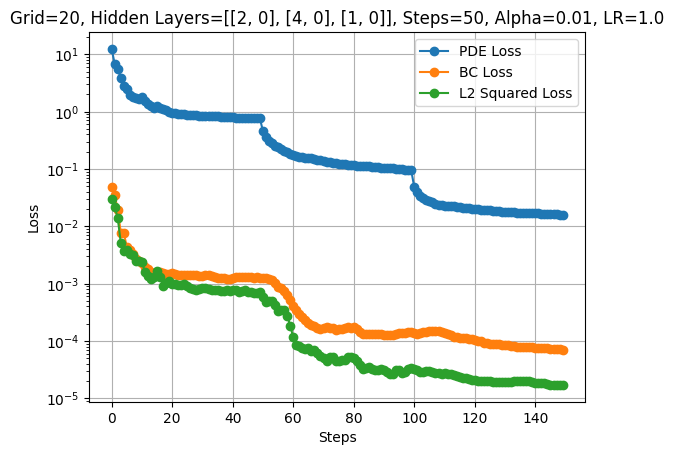

   Alpha  Learning Rate  Grid             Hidden Layers  Steps Final PDE Loss  \
0   0.01            1.0    20  [[2, 0], [4, 0], [1, 0]]     50     0.01592362   

  Final BC Loss  Final L2 Loss  
0  7.023006e-05  1.7203885e-05  

Final Results Summary:
 Alpha  Learning Rate  Grid            Hidden Layers  Steps Final PDE Loss Final BC Loss Final L2 Loss
  0.01            1.0    20 [[2, 0], [4, 0], [1, 0]]     50     0.01592362  7.023006e-05 1.7203885e-05
Visualize model =  [0.01, 1.0, [[2, 0], [4, 0], [1, 0]], 50]


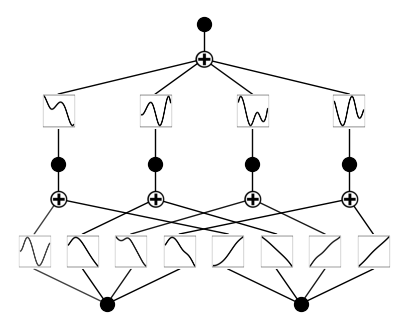

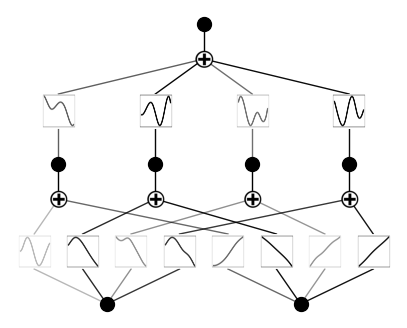

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []

# Hyperparameters
dim = 2
np_i = 51
np_b = 51
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
sampling_mode = 'mesh'  # 'random' or 'mesh'
grids = [5, 10, 20]
steps = 50

# Define functions
sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])
source_fun = lambda x: -2 * torch.pi**2 * torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

# Prepare data
x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

if sampling_mode == 'mesh':
    x_i = torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
else:
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

x_i = x_i.to(device)

helper = lambda X, Y: torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0).to(device)

# Training function
def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # Boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if step % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses



# Define hyperparameter ranges
alphas = [0.01]
learning_rates = [1.0]
grids = [5,10,20]
hidden_layers_list = [ [2, 4,1]]
steps_list = [50]

pde_losses, bc_losses,l2_losses = [],[],[]

log = 1


# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):
    # Initialize model
    pde_losses ,bc_losses,l2_losses = [],[],[]
    for grid in grids:
      if grid == grids[0]:
          model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
          models.append(model)
          parameters_to_print.append([alpha, learning_rate,hidden_layers, steps])
          model = model.speed()
      else:
          model.save_act = True
          model.get_act(x_i)
          model = model.refine(grid)
          model = model.speed()
      # Train model
      pde_losses, bc_losses, l2_losses= train_model(model, x_i, x_b, steps, alpha, log_interval)
      # Store results
    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        'Final PDE Loss': pde_losses[-1],
        'Final BC Loss': bc_losses[-1],
        'Final L2 Loss': l2_losses[-1]
    })

    plt.plot(pde_losses, marker='o', label='PDE Loss')
    plt.plot(bc_losses, marker='o', label='BC Loss')
    plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    plt.grid(True)
    plt.show()


# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save results to CSV and print
results_df.to_csv('kan_hyperparameter_results.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))
for i in range(len(models)):
  print("Visualize model = ",parameters_to_print[i])
  models[i].plot(beta = 10)
  models[i].plot()

In [ ]:
from kan import *

models[0].fix_symbolic(0,0,0,'sin')
models[0].fix_symbolic(0,0,1,'x^2')
models[0].fix_symbolic(0,0,2,'x^2')
models[0].fix_symbolic(0,0,3,'x^2')

models[0].fix_symbolic(0,1,0,'x')
models[0].fix_symbolic(0,1,1,'x')
models[0].fix_symbolic(0,1,2,'x')
models[0].fix_symbolic(0,1,3,'x')


models[0].fix_symbolic(1,0,0,'sin')
models[0].fix_symbolic(1,1,0,'sin')
models[0].fix_symbolic(1,2,0,'sin')
models[0].fix_symbolic(1,3,0,'sin')

formula = models[0].symbolic_formula()[0][0]
ex_round(formula,6)

r2 is 0.9886255264282227
r2 is 0.9626656770706177
r2 is 0.9748450517654419
r2 is 0.9528643488883972
r2 is 0.9777929186820984
r2 is 0.9973254203796387
r2 is 0.9952199459075928
r2 is 0.998357892036438
r2 is 0.5380551815032959
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.43255558609962463
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.5866597890853882
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.7965955138206482
r2 is not very high, please double check if you are choosing the correct symbolic function.


0.112087*sin(-3.38579*x_2 + 2.764128*(-x_1 - 0.587391)**2 + 0.071236) - 17.660736*sin(0.118507*x_2 + 0.044403*sin(3.6332*x_1 + 9.79912) + 4.757365) - 1.630295*sin(0.719528*x_2 + 0.376784*(-x_1 - 0.597168)**2 + 7.558735) + 0.432167*sin(2.172303*x_2 - 0.894807*(-x_1 - 0.736883)**2 + 1.907195) - 16.256271

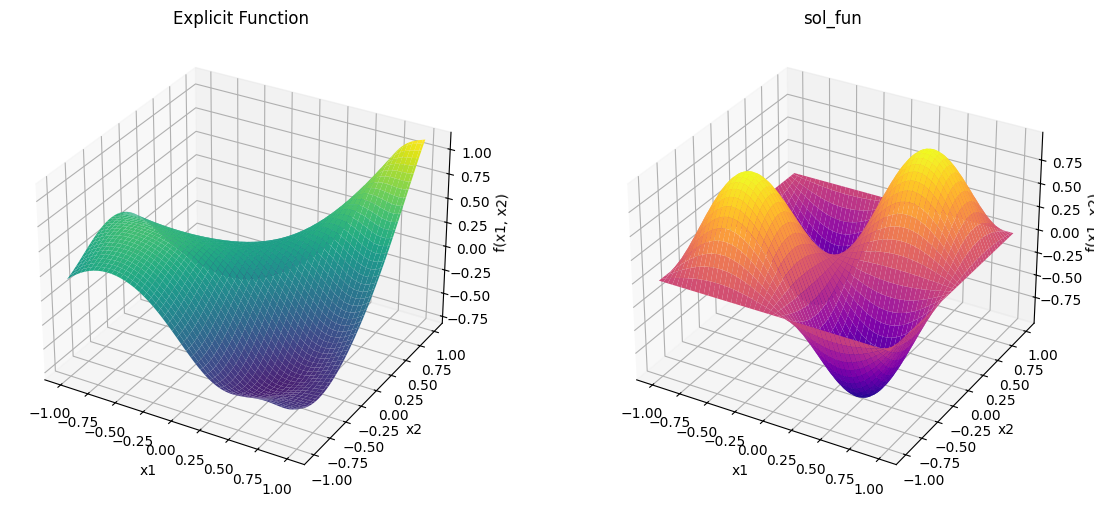

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the first function
def explicit_function(x1, x2):
    return (
        0.112087 * np.sin(-3.38579 * x2 + 2.764128 * (-x1 - 0.587391)**2 + 0.071236)
        - 17.660736 * np.sin(0.118507 * x2 + 0.044403 * np.sin(3.6332 * x1 + 9.79912) + 4.757365)
        - 1.630295 * np.sin(0.719528 * x2 + 0.376784 * (-x1 - 0.597168)**2 + 7.558735)
        + 0.432167 * np.sin(2.172303 * x2 - 0.894807 * (-x1 - 0.736883)**2 + 1.907195)
        - 16.256271
    )

# Define the second function using PyTorch
sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])

# Create a grid
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)

# Evaluate the first function
Z1 = explicit_function(X1, X2)

# Evaluate the second function
X = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=torch.float32)
Z2 = sol_fun(X).numpy().reshape(X1.shape)

# Plot both functions
fig, ax = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

# Plot explicit function
ax[0].plot_surface(X1, X2, Z1, cmap='viridis')
ax[0].set_title("Explicit Function")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_zlabel("f(x1, x2)")

# Plot sol_fun
ax[1].plot_surface(X1, X2, Z2, cmap='plasma')
ax[1].set_title("sol_fun")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].set_zlabel("f(x1, x2)")

plt.show()


Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.41e-01 | bc loss: 7.44e-06 | l2: 1.23e-05 : 100%|███████| 50/50 [02:23<00:00,  2.86s/it]
pde loss: 1.64e-02 | bc loss: 2.56e-07 | l2: 6.23e-07 : 100%|███████| 50/50 [02:48<00:00,  3.36s/it]
pde loss: 2.36e-03 | bc loss: 1.98e-07 | l2: 3.88e-07 : 100%|███████| 50/50 [03:10<00:00,  3.81s/it]


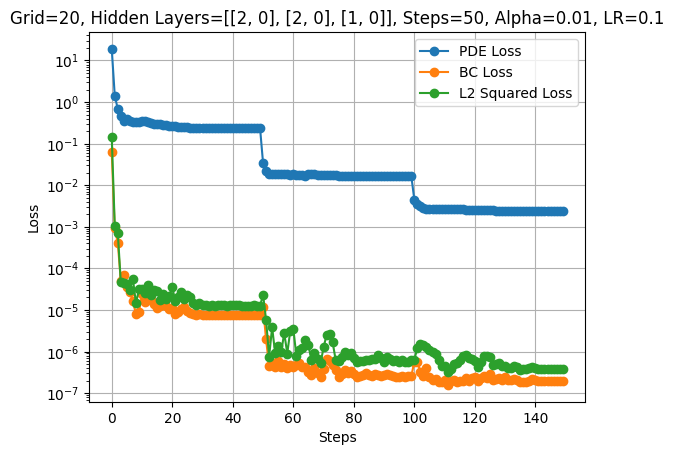

   Alpha  Learning Rate  Grid             Hidden Layers  Steps Final PDE Loss  \
0   0.01            0.1    20  [[2, 0], [2, 0], [1, 0]]     50   0.0023598475   

   Final BC Loss  Final L2 Loss  
0  1.9812833e-07  3.8826303e-07  

Final Results Summary:
 Alpha  Learning Rate  Grid            Hidden Layers  Steps Final PDE Loss Final BC Loss Final L2 Loss
  0.01            0.1    20 [[2, 0], [2, 0], [1, 0]]     50   0.0023598475 1.9812833e-07 3.8826303e-07
Visualize model =  [0.01, 0.1, [[2, 0], [2, 0], [1, 0]], 50]


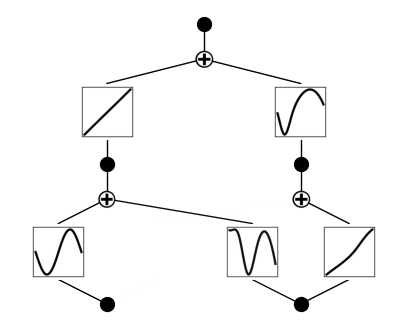

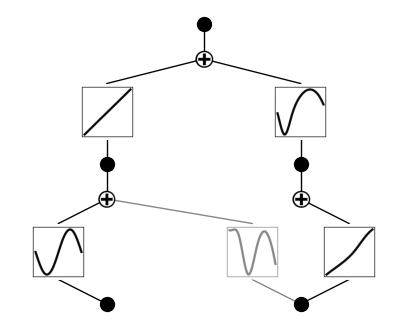

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools
from kan import *
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []

# Hyperparameters
dim = 2
np_i = 51
np_b = 51
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
sampling_mode = 'mesh'  # 'random' or 'mesh'
grids = [5, 10, 20]
steps = 5

# Define functions
sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) + torch.sin(torch.pi * x[:, [1]])
source_fun = lambda x: - torch.pi**2 * torch.sin(torch.pi * x[:, [0]]) -torch.pi**2* torch.sin(torch.pi * x[:, [1]])

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

# Prepare data
x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

if sampling_mode == 'mesh':
    x_i = torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
else:
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

x_i = x_i.to(device)

helper = lambda X, Y: torch.stack([X.reshape(-1), Y.reshape(-1)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0).to(device)

# Training function
def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # Boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if step % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses



# Define hyperparameter ranges
alphas = [0.01]
learning_rates = [ 0.1]
grids = [5,10,20]
hidden_layers_list = [[2, 2, 1]]
steps_list = [50]

pde_losses, bc_losses,l2_losses = [],[],[]

log = 1


# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):
    # Initialize model
    pde_losses ,bc_losses,l2_losses = [],[],[]
    for grid in grids:
      if grid == grids[0]:
          model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
          models.append(model)
          parameters_to_print.append([alpha, learning_rate,hidden_layers, steps])
          model = model.speed()
      else:
          model.save_act = True
          model.get_act(x_i)
          model = model.refine(grid)
          model = model.speed()
      # Train model
      pde_losses, bc_losses, l2_losses= train_model(model, x_i, x_b, steps, alpha, log_interval)
      # Store results
    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        'Final PDE Loss': pde_losses[-1],
        'Final BC Loss': bc_losses[-1],
        'Final L2 Loss': l2_losses[-1]
    })

    plt.plot(pde_losses, marker='o', label='PDE Loss')
    plt.plot(bc_losses, marker='o', label='BC Loss')
    plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    plt.grid(True)
    plt.show()


# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save results to CSV and print
results_df.to_csv('kan_hyperparameter_results.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))
for i in range(len(models)):
  print("Visualize model = ",parameters_to_print[i])
  models[i].plot(beta = 10)
  models[i].plot()
  formula = models[i].symbolic_formula()[0][0]
  ex_round(formula,6)

In [ ]:
from kan import *

models[0].fix_symbolic(0,0,0,'sin')


models[0].fix_symbolic(0,1,0,'sin')
models[0].fix_symbolic(0,1,1,'x')

models[0].fix_symbolic(1,0,0,'x')
models[0].fix_symbolic(1,1,0,'x^2')


formula = models[0].symbolic_formula()[0][0]
ex_round(formula,6)

r2 is 0.9999850988388062
r2 is 0.9785611033439636
Best value at boundary.
r2 is 0.9857663512229919
r2 is 0.9999972581863403
r2 is 0.7361887097358704
r2 is not very high, please double check if you are choosing the correct symbolic function.


-0.660037*(0.745228 - x_2)**2 + 0.996542*sin(3.1396*x_1 + 0.00056) + 0.244261*sin(4.70208*x_2 + 5.4116) + 0.591257

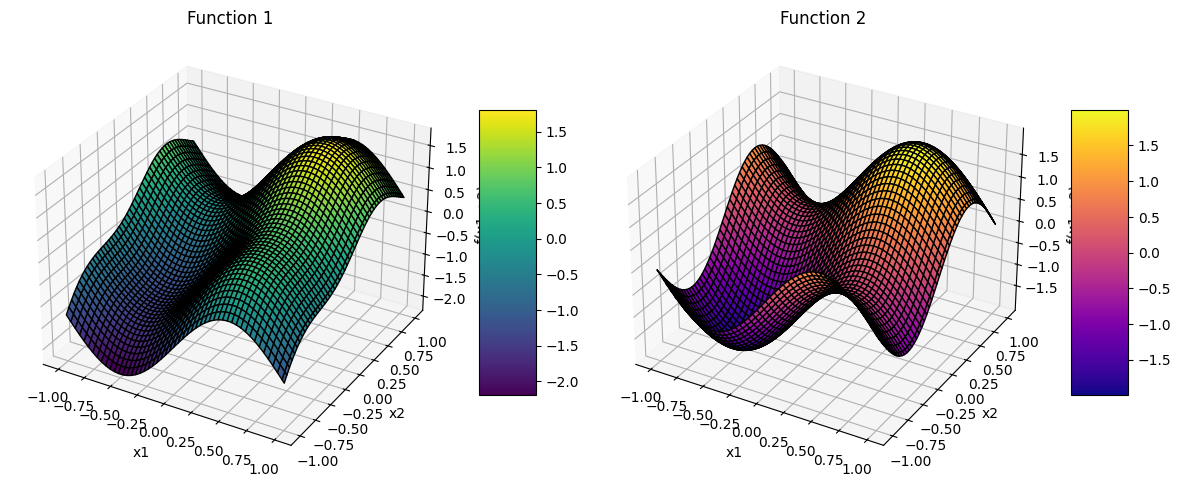

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the two functions
def func1(x1, x2):
    return (-0.660037 * (0.745228 - x2)**2
            + 0.996542 * np.sin(3.1396 * x1 + 0.00056)
            + 0.244261 * np.sin(4.70208 * x2 + 5.4116)
            + 0.591257)

def func2(x1, x2):
    return np.sin(np.pi * x1) + np.sin(np.pi * x2)

# Generate grid for plotting
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
x1, x2 = np.meshgrid(x, y)

# Compute function values
z1 = func1(x1, x2)
z2 = func2(x1, x2)

# Create the plots
fig = plt.figure(figsize=(12, 6))

# Plot for func1
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(x1, x2, z1, cmap='viridis', edgecolor='k')
ax1.set_title('Function 1')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x1, x2)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Plot for func2
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(x1, x2, z2, cmap='plasma', edgecolor='k')
ax2.set_title('Function 2')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('f(x1, x2)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.04e-01 | bc loss: 8.69e-06 | l2: 3.03e-05 : 100%|█████| 100/100 [00:23<00:00,  4.32it/s]
pde loss: 9.86e-05 | bc loss: 6.03e-09 | l2: 3.38e-07 : 100%|█████| 100/100 [00:36<00:00,  2.72it/s]
pde loss: 4.20e-05 | bc loss: 1.45e-07 | l2: 2.99e-07 : 100%|█████| 100/100 [00:17<00:00,  5.56it/s]


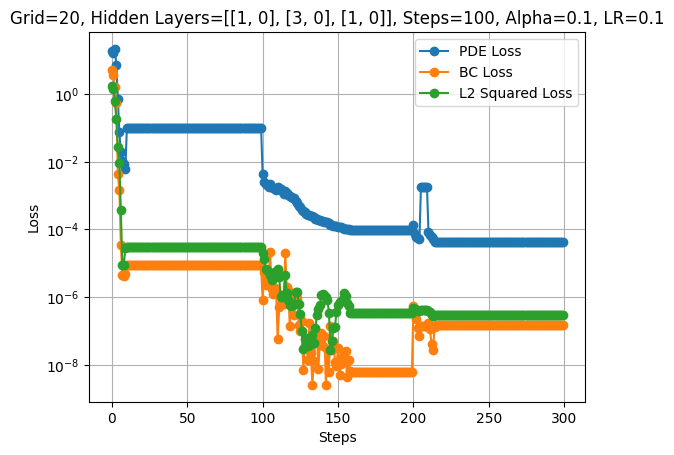

   Alpha  Learning Rate  Grid             Hidden Layers  Steps Final PDE Loss  \
0    0.1            0.1    20  [[1, 0], [3, 0], [1, 0]]    100  4.2043393e-05   

   Final BC Loss  Final L2 Loss  
0  1.4486764e-07  2.9904305e-07  

Final Results Summary:
 Alpha  Learning Rate  Grid            Hidden Layers  Steps Final PDE Loss Final BC Loss Final L2 Loss
   0.1            0.1    20 [[1, 0], [3, 0], [1, 0]]    100  4.2043393e-05 1.4486764e-07 2.9904305e-07
Visualize model =  [0.1, 0.1, [[1, 0], [3, 0], [1, 0]], 100]


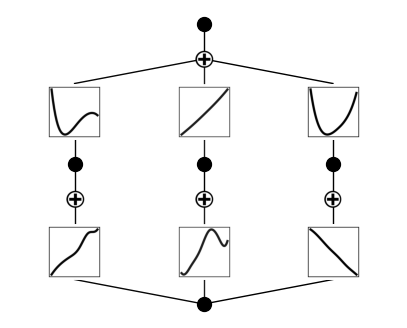

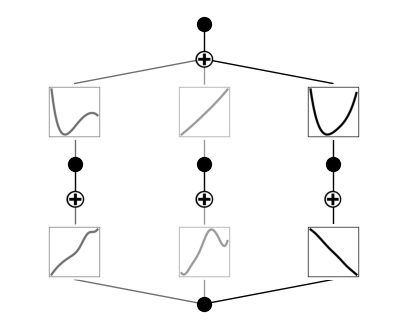

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools
from kan import *

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []

# Hyperparameters
dim = 1
np_i = 51
np_b = 2
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
grids = [5, 10, 20]
steps = 50

# Define functions
sol_fun = lambda x: torch.exp(x**2)  # Analytical solution
source_fun = lambda x: 2*(2*x**2+1)*torch.exp(x**2)  # Source term
def compute_second_derivative(func, x):
    x.requires_grad_(True)
    y = func(x)  # Shape: [batch_size, 1]
    grad1 = autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]  # First derivative
    grad2 = autograd.grad(grad1, x, grad_outputs=torch.ones_like(grad1), create_graph=True)[0]  # Second derivative
    return grad2

x_i = torch.linspace(ranges[0], ranges[1], steps=np_i).unsqueeze(-1).to(device)
x_b = torch.tensor([[ranges[0]], [ranges[1]]], dtype=torch.float32).to(device)

def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)  # Analytical solution
            lap = compute_second_derivative(model, x_i)  # Compute second derivative
            source = source_fun(x_i)  # True source term
            pde_loss = torch.mean((lap - source)**2)  # PDE loss: match Laplacian to source

            # Boundary loss
            bc_true = sol_fun(x_b)  # True solution at boundaries
            bc_pred = model(x_b)   # Predicted solution at boundaries
            bc_loss = torch.mean((bc_pred - bc_true)**2)  # Boundary condition loss

            loss = alpha * pde_loss + bc_loss  # Total loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)  # L2 loss: model vs analytical solution

        if step % log_interval == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " %
                                 (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses



#Define hyperparameter ranges
alphas = [0.1]
learning_rates = [0.1]
grids = [5, 10, 20]
hidden_layers_list = [[1, 3, 1]]
steps_list = [100]


pde_losses, bc_losses, l2_losses = [], [], []
log = 1

# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):
    pde_losses, bc_losses, l2_losses = [], [], []
    for grid in grids:
        if grid == grids[0]:
            model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
            models.append(model)
            parameters_to_print.append([alpha, learning_rate, hidden_layers, steps])
            model = model.speed()
        else:
            model.save_act = True
            model.get_act(x_i)
            model = model.refine(grid)
            model = model.speed()

        # Train model
        pde_losses, bc_losses, l2_losses = train_model(model, x_i, x_b, steps, alpha, log_interval)
        # Store results

    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        'Final PDE Loss': pde_losses[-1],
        'Final BC Loss': bc_losses[-1],
        'Final L2 Loss': l2_losses[-1]
    })

    plt.plot(pde_losses, marker='o', label='PDE Loss')
    plt.plot(bc_losses, marker='o', label='BC Loss')
    plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    plt.yscale('log')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    plt.grid(True)
    plt.show()


# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save results to CSV and print
results_df.to_csv('kan_hyperparameter_results_1d.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))

for i in range(len(models)):
    print("Visualize model = ", parameters_to_print[i])
    models[i].plot(beta=10)
    models[i].plot()
    # formula = models[i].symbolic_formula()[0][0]
    # ex_round(formula,6)
    # print(formula)


In [ ]:
from kan import *

models[0].fix_symbolic(0,0,0,'x')
models[0].fix_symbolic(0,0,1,'sin')
models[0].fix_symbolic(0,0,2,'x')

models[0].fix_symbolic(1,0,0,'sin')
models[0].fix_symbolic(1,1,0,'x')
models[0].fix_symbolic(1,2,0,'x^2')


formula = models[0].symbolic_formula()[0][0]
ex_round(formula,6)

Best value at boundary.
r2 is 0.9814481139183044
r2 is 0.9740533828735352
Best value at boundary.
r2 is 0.9993451237678528
Best value at boundary.
r2 is 0.6946802735328674
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.9976470470428467
r2 is 0.9380261301994324


1.527896*(x_1 - 0.04449)**2 - 0.0992*sin(2.38872*x_1 + 3.81448) - 0.115099*sin(2.743941*x_1 - 4.003622) + 0.945925

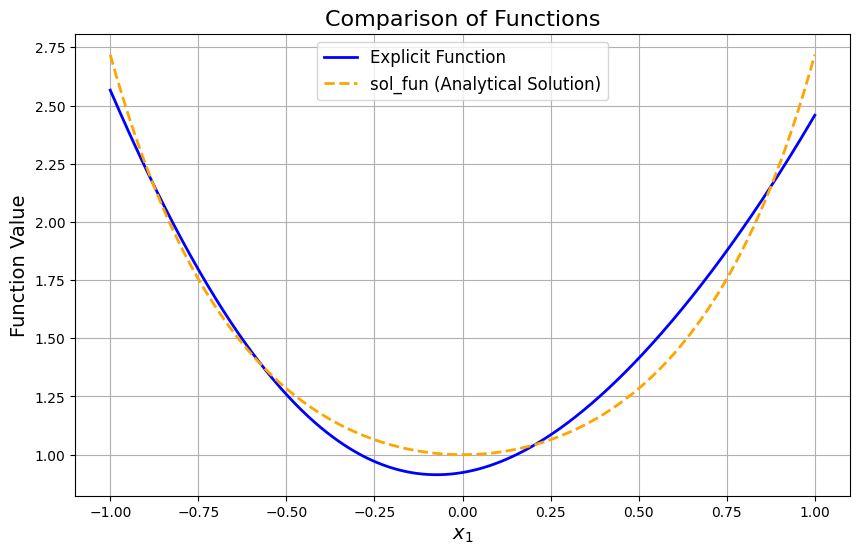

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the explicit function
def explicit_function(x1):
    return (
        1.527896 * (x1 - 0.04449)**2
        - 0.0992 * np.sin(2.38872 * x1 + 3.81448)
        - 0.115099 * np.sin(2.743941 * x1 - 4.003622)
        + 0.945925
    )

# Define the PyTorch function
sol_fun = lambda x: torch.exp(x**2)  # Analytical solution

# Create a grid
x1 = np.linspace(-1, 1, 500)  # High resolution for smooth plots

# Evaluate the explicit function
Z1 = explicit_function(x1)

# Evaluate the PyTorch function
x_torch = torch.tensor(x1, dtype=torch.float32)
Z2 = sol_fun(x_torch).numpy()

# Plot the results
plt.figure(figsize=(10, 6))

# Plot explicit function
plt.plot(x1, Z1, label="Explicit Function", color="blue", linewidth=2)

# Plot sol_fun
plt.plot(x1, Z2, label="sol_fun (Analytical Solution)", color="orange", linestyle="--", linewidth=2)

# Add labels and legend
plt.title("Comparison of Functions", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("Function Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [ ]:

import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import pandas as pd
from kan import KAN, LBFGS
import itertools

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
models = []
parameters_to_print = []

# Hyperparameters
dim = 1
np_i = 51
np_b = 2
ranges = [-1, 1]
alpha = 0.01
log_interval = 1
grids = [5, 10, 20]
steps = 50

# Define functions
sol_fun = lambda x: torch.sin(torch.pi * x)  # Analytical solution
source_fun = lambda x: -(torch.pi**2) * torch.sin(torch.pi * x)  # Source term
def compute_second_derivative(func, x):
    x.requires_grad_(True)
    y = func(x)  # Shape: [batch_size, 1]
    grad1 = autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]  # First derivative
    grad2 = autograd.grad(grad1, x, grad_outputs=torch.ones_like(grad1), create_graph=True)[0]  # Second derivative
    return grad2

x_i = torch.linspace(ranges[0], ranges[1], steps=np_i).unsqueeze(-1).to(device)
x_b = torch.tensor([[ranges[0]], [ranges[1]]], dtype=torch.float32).to(device)

def train_model(model, x_i, x_b, steps, alpha, log_interval):
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe",
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # Interior loss
            sol = sol_fun(x_i)  # Analytical solution
            lap = compute_second_derivative(model, x_i)  # Compute second derivative
            source = source_fun(x_i)  # True source term
            pde_loss = torch.mean((lap - source)**2)  # PDE loss: match Laplacian to source

            # Boundary loss
            bc_true = sol_fun(x_b)  # True solution at boundaries
            bc_pred = model(x_b)   # Predicted solution at boundaries
            bc_loss = torch.mean((bc_pred - bc_true)**2)  # Boundary condition loss

            loss = alpha * pde_loss + bc_loss  # Total loss
            loss.backward()

            return loss

        if step % 5 == 0 and step < 20:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)  # L2 loss: model vs analytical solution

        if step % log_interval == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " %
                                 (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

    return pde_losses, bc_losses, l2_losses



# Define hyperparameter ranges
alphas = [0.01, 0.1]
learning_rates = [0.1, 1.0]
grids = [5, 10, 20]
hidden_layers_list = [[1,1,1],[1, 2, 1],[1, 3, 1]]
steps_list = [50, 100]

pde_losses, bc_losses, l2_losses = [], [], []
log = 1

# Hyperparameter tuning loop
for alpha, learning_rate, hidden_layers, steps in itertools.product(alphas, learning_rates, hidden_layers_list, steps_list):
    pde_losses, bc_losses, l2_losses = [], [], []
    for grid in grids:
        if grid == grids[0]:
            model = KAN(width=hidden_layers, grid=grid, k=3, seed=1, device=device)
            models.append(model)
            parameters_to_print.append([alpha, learning_rate, hidden_layers, steps])
            model = model.speed()
        else:
            model.save_act = True
            model.get_act(x_i)
            model = model.refine(grid)
            model = model.speed()
        def count_params(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)

        # Print the total number of parameters in the KAN model
        print(f"Total number of trainable parameters in the model: {count_params(model)}")



        # Train model
        #pde_losses, bc_losses, l2_losses = train_model(model, x_i, x_b, steps, alpha, log_interval)
        # Store results

    results.append({
        'Alpha': alpha,
        'Learning Rate': learning_rate,
        'Grid': grid,
        'Hidden Layers': hidden_layers,
        'Steps': steps,
        # 'Final PDE Loss': pde_losses[-1],
        # 'Final BC Loss': bc_losses[-1],
        # 'Final L2 Loss': l2_losses[-1]
    })

    # plt.plot(pde_losses, marker='o', label='PDE Loss')
    # plt.plot(bc_losses, marker='o', label='BC Loss')
    # plt.plot(l2_losses, marker='o', label='L2 Squared Loss')
    # plt.yscale('log')
    # plt.xlabel('Steps')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title(f'Grid={grid}, Hidden Layers={hidden_layers}, Steps={steps}, Alpha={alpha}, LR={learning_rate}')
    # plt.grid(True)
    # plt.show()


# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save results to CSV and print
results_df.to_csv('kan_hyperparameter_results_1d.csv', index=False)
print(results_df)

# Display results as a table
print("\nFinal Results Summary:")
print(results_df.to_string(index=False))

for i in range(len(models)):
    print("Visualize model = ", parameters_to_print[i])
    models[i].plot(beta=10)
    models[i].plot()



Using device: cuda
checkpoint directory created: ./model
saving model version 0.0
Total number of trainable parameters in the model: 28
Total number of trainable parameters in the model: 38
Total number of trainable parameters in the model: 58
checkpoint directory created: ./model
saving model version 0.0
Total number of trainable parameters in the model: 28
Total number of trainable parameters in the model: 38
Total number of trainable parameters in the model: 58
checkpoint directory created: ./model
saving model version 0.0
Total number of trainable parameters in the model: 56
Total number of trainable parameters in the model: 76
Total number of trainable parameters in the model: 116
checkpoint directory created: ./model
saving model version 0.0
Total number of trainable parameters in the model: 56
Total number of trainable parameters in the model: 76
Total number of trainable parameters in the model: 116
checkpoint directory created: ./model
saving model version 0.0
Total number of 

UnboundLocalError: cannot access local variable 'coef' where it is not associated with a value